In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from pylab import savefig
import seaborn as sns
import pandas as pd
import csv
%matplotlib inline

In [2]:
# CARREGANDO DADOS IOMETER HDD 80GB teste teste 2 teste3

dfTemp_80HDDMeterCenUm4KB = csv.reader(open('80GBHDD/IOMeter/Cenario1/inst4KB.csv', 'r'))
dfTemp_80HDDMeterCenUm128KB = csv.reader(open('80GBHDD/IOMeter/Cenario1/inst128KB.csv', 'r'))
dfTemp_80HDDMeterCenUm512KB = csv.reader(open('80GBHDD/IOMeter/Cenario1/inst512KB.csv', 'r'))
dfTemp_80HDDMeterCenUm1MB = csv.reader(open('80GBHDD/IOMeter/Cenario1/inst1MB.csv', 'r'))

dfTemp_80HDDMeterCenDois4KB = csv.reader(open('80GBHDD/IOMeter/Cenario2/inst4KB.csv', 'r'))
dfTemp_80HDDMeterCenDois128KB = csv.reader(open('80GBHDD/IOMeter/Cenario2/inst128KB.csv', 'r'))
dfTemp_80HDDMeterCenDois512KB = csv.reader(open('80GBHDD/IOMeter/Cenario2/inst512KB.csv', 'r'))
dfTemp_80HDDMeterCenDois1MB = csv.reader(open('80GBHDD/IOMeter/Cenario2/inst1MB.csv', 'r'))

# CARREGANDO DADOS IOMETER HDD 500GB

dfTemp_500HDDMeterCenUm4KB = csv.reader(open('500GBHDD/IOMeter/Cenario1/inst4KB.csv', 'r'))
dfTemp_500HDDMeterCenUm128KB = csv.reader(open('500GBHDD/IOMeter/Cenario1/inst128KB.csv', 'r'))
dfTemp_500HDDMeterCenUm512KB = csv.reader(open('500GBHDD/IOMeter/Cenario1/inst512KB.csv', 'r'))
dfTemp_500HDDMeterCenUm1MB = csv.reader(open('500GBHDD/IOMeter/Cenario1/inst1MB.csv', 'r'))

dfTemp_500HDDMeterCenDois4KB = csv.reader(open('500GBHDD/IOMeter/Cenario2/inst4KB.csv', 'r'))
dfTemp_500HDDMeterCenDois128KB = csv.reader(open('500GBHDD/IOMeter/Cenario2/inst128KB.csv', 'r'))
dfTemp_500HDDMeterCenDois512KB = csv.reader(open('500GBHDD/IOMeter/Cenario2/inst512KB.csv', 'r'))
dfTemp_500HDDMeterCenDois1MB = csv.reader(open('500GBHDD/IOMeter/Cenario2/inst1MB.csv', 'r'))

# CARREGANDO DADOS IOMETER HDD 1TB

dfTemp_1HDDMeterCenUm4KB = csv.reader(open('1TBHDD/IOMeter/Cenario1/inst4KB.csv', 'r'))
dfTemp_1HDDMeterCenUm128KB = csv.reader(open('1TBHDD/IOMeter/Cenario1/inst128KB.csv', 'r'))
dfTemp_1HDDMeterCenUm512KB = csv.reader(open('1TBHDD/IOMeter/Cenario1/inst512KB.csv', 'r'))
dfTemp_1HDDMeterCenUm1MB = csv.reader(open('1TBHDD/IOMeter/Cenario1/inst1MB.csv', 'r'))

dfTemp_1HDDMeterCenDois4KB = csv.reader(open('1TBHDD/IOMeter/Cenario2/inst4KB.csv', 'r'))
dfTemp_1HDDMeterCenDois128KB = csv.reader(open('1TBHDD/IOMeter/Cenario2/inst128KB.csv', 'r'))
dfTemp_1HDDMeterCenDois512KB = csv.reader(open('1TBHDD/IOMeter/Cenario2/inst512KB.csv', 'r'))
dfTemp_1HDDMeterCenDois1MB = csv.reader(open('1TBHDD/IOMeter/Cenario2/inst1MB.csv', 'r'))

# CARREGANDO DADOS IOMETER WDHDD 1TB

dfTemp_1WDHDDMeterCenUm4KB = csv.reader(open('1TBWDHDD/IOMeter/Cenario1/inst4KB.csv', 'r'))
dfTemp_1WDHDDMeterCenUm128KB = csv.reader(open('1TBWDHDD/IOMeter/Cenario1/inst128KB.csv', 'r'))
dfTemp_1WDHDDMeterCenUm512KB = csv.reader(open('1TBWDHDD/IOMeter/Cenario1/inst512KB.csv', 'r'))
dfTemp_1WDHDDMeterCenUm1MB = csv.reader(open('1TBWDHDD/IOMeter/Cenario1/inst1MB.csv', 'r'))

dfTemp_1WDHDDMeterCenDois4KB = csv.reader(open('1TBWDHDD/IOMeter/Cenario2/inst4KB.csv', 'r'))
dfTemp_1WDHDDMeterCenDois128KB = csv.reader(open('1TBWDHDD/IOMeter/Cenario2/inst128KB.csv', 'r'))
dfTemp_1WDHDDMeterCenDois512KB = csv.reader(open('1TBWDHDD/IOMeter/Cenario2/inst512KB.csv', 'r'))
dfTemp_1WDHDDMeterCenDois1MB = csv.reader(open('1TBWDHDD/IOMeter/Cenario2/inst1MB.csv', 'r'))

# CARREGANDO DADOS IOMETER SSD 120GB

dfTemp_120SSDMeterCenUm4KB = csv.reader(open('120GBSSD/IOMeter/Cenario1/inst4KB.csv', 'r'))
dfTemp_120SSDMeterCenUm128KB = csv.reader(open('120GBSSD/IOMeter/Cenario1/inst128KB.csv', 'r'))
dfTemp_120SSDMeterCenUm512KB = csv.reader(open('120GBSSD/IOMeter/Cenario1/inst512KB.csv', 'r'))
dfTemp_120SSDMeterCenUm1MB = csv.reader(open('120GBSSD/IOMeter/Cenario1/inst1MB.csv', 'r'))

dfTemp_120SSDMeterCenDois4KB = csv.reader(open('120GBSSD/IOMeter/Cenario2/inst4KB.csv', 'r'))
dfTemp_120SSDMeterCenDois128KB = csv.reader(open('120GBSSD/IOMeter/Cenario2/inst128KB.csv', 'r'))
dfTemp_120SSDMeterCenDois512KB = csv.reader(open('120GBSSD/IOMeter/Cenario2/inst512KB.csv', 'r'))
dfTemp_120SSDMeterCenDois1MB = csv.reader(open('120GBSSD/IOMeter/Cenario2/inst1MB.csv', 'r'))

# CARREGANDO DADOS IOMETER Hybrid (SSD 120GB + WDHDD 1TB)

dfTemp_HybridMeterCenUm4KB = csv.reader(open('Hybrid/IOMeter/Cenario1/inst4KB.csv', 'r'))
dfTemp_HybridMeterCenUm128KB = csv.reader(open('Hybrid/IOMeter/Cenario1/inst128KB.csv', 'r'))
dfTemp_HybridMeterCenUm512KB = csv.reader(open('Hybrid/IOMeter/Cenario1/inst512KB.csv', 'r'))
dfTemp_HybridMeterCenUm1MB = csv.reader(open('Hybrid/IOMeter/Cenario1/inst1MB.csv', 'r'))

dfTemp_HybridMeterCenDois4KB = csv.reader(open('Hybrid/IOMeter/Cenario2/inst4KB.csv', 'r'))
dfTemp_HybridMeterCenDois128KB = csv.reader(open('Hybrid/IOMeter/Cenario2/inst128KB.csv', 'r'))
dfTemp_HybridMeterCenDois512KB = csv.reader(open('Hybrid/IOMeter/Cenario2/inst512KB.csv', 'r'))
dfTemp_HybridMeterCenDois1MB = csv.reader(open('Hybrid/IOMeter/Cenario2/inst1MB.csv', 'r'))


In [4]:
# CARREGANDO DADOS BENCH HDD 80GB

df_80HDDBenchCenUm4KB = pd.read_csv("80GBHDD/Bench/Cenario1/4KB.csv", sep=';')
df_80HDDBenchCenUm128KB = pd.read_csv("80GBHDD/Bench/Cenario1/128KB.csv", sep=';')
df_80HDDBenchCenUm512KB = pd.read_csv("80GBHDD/Bench/Cenario1/512KB.csv", sep=';')
df_80HDDBenchCenUm1MB = pd.read_csv("80GBHDD/Bench/Cenario1/1MB.csv", sep=';')

df_80HDDBenchCenDois4KB = pd.read_csv("80GBHDD/Bench/Cenario2/4KB.csv", sep=';')
df_80HDDBenchCenDois128KB = pd.read_csv("80GBHDD/Bench/Cenario2/128KB.csv", sep=';')
df_80HDDBenchCenDois512KB = pd.read_csv("80GBHDD/Bench/Cenario2/512KB.csv", sep=';')
df_80HDDBenchCenDois1MB = pd.read_csv("80GBHDD/Bench/Cenario2/1MB.csv", sep=';')

# CARREGANDO DADOS BENCH HDD 500GB

df_500HDDBenchCenUm4KB = pd.read_csv("500GBHDD/Bench/Cenario1/4KB.csv", sep=';')
df_500HDDBenchCenUm128KB = pd.read_csv("500GBHDD/Bench/Cenario1/128KB.csv", sep=';')
df_500HDDBenchCenUm512KB = pd.read_csv("500GBHDD/Bench/Cenario1/512KB.csv", sep=';')
df_500HDDBenchCenUm1MB = pd.read_csv("500GBHDD/Bench/Cenario1/1MB.csv", sep=';')

df_500HDDBenchCenDois4KB = pd.read_csv("500GBHDD/Bench/Cenario2/4KB.csv", sep=';')
df_500HDDBenchCenDois128KB = pd.read_csv("500GBHDD/Bench/Cenario2/128KB.csv", sep=';')
df_500HDDBenchCenDois512KB = pd.read_csv("500GBHDD/Bench/Cenario2/512KB.csv", sep=';')
df_500HDDBenchCenDois1MB = pd.read_csv("500GBHDD/Bench/Cenario2/1MB.csv", sep=';')

# CARREGANDO DADOS BENCH HDD 1TB

df_1HDDBenchCenUm4KB = pd.read_csv("1TBHDD/Bench/Cenario1/4KB.csv", sep=';')
df_1HDDBenchCenUm128KB = pd.read_csv("1TBHDD/Bench/Cenario1/128KB.csv", sep=';')
df_1HDDBenchCenUm512KB = pd.read_csv("1TBHDD/Bench/Cenario1/512KB.csv", sep=';')
df_1HDDBenchCenUm1MB = pd.read_csv("1TBHDD/Bench/Cenario1/1MB.csv", sep=';')

df_1HDDBenchCenDois4KB = pd.read_csv("1TBHDD/Bench/Cenario2/4KB.csv", sep=';')
df_1HDDBenchCenDois128KB = pd.read_csv("1TBHDD/Bench/Cenario2/128KB.csv", sep=';')
df_1HDDBenchCenDois512KB = pd.read_csv("1TBHDD/Bench/Cenario2/512KB.csv", sep=';')
df_1HDDBenchCenDois1MB = pd.read_csv("1TBHDD/Bench/Cenario2/1MB.csv", sep=';')

# CARREGANDO DADOS BENCH WDHDD 1TB

df_1WDHDDBenchCenUm4KB = pd.read_csv("1TBWDHDD/Bench/Cenario1/4KB.csv", sep=';')
df_1WDHDDBenchCenUm128KB = pd.read_csv("1TBWDHDD/Bench/Cenario1/128KB.csv", sep=';')
df_1WDHDDBenchCenUm512KB = pd.read_csv("1TBWDHDD/Bench/Cenario1/512KB.csv", sep=';')
df_1WDHDDBenchCenUm1MB = pd.read_csv("1TBWDHDD/Bench/Cenario1/1MB.csv", sep=';')

df_1WDHDDBenchCenDois4KB = pd.read_csv("1TBWDHDD/Bench/Cenario2/4KB.csv", sep=';')
df_1WDHDDBenchCenDois128KB = pd.read_csv("1TBWDHDD/Bench/Cenario2/128KB.csv", sep=';')
df_1WDHDDBenchCenDois512KB = pd.read_csv("1TBWDHDD/Bench/Cenario2/512KB.csv", sep=';')
df_1WDHDDBenchCenDois1MB = pd.read_csv("1TBWDHDD/Bench/Cenario2/1MB.csv", sep=';')

# CARREGANDO DADOS BENCH SSD 120GB

df_120SSDBenchCenUm4KB = pd.read_csv("120GBSSD/Bench/Cenario1/4KB.csv", sep=';')
df_120SSDBenchCenUm128KB = pd.read_csv("120GBSSD/Bench/Cenario1/128KB.csv", sep=';')
df_120SSDBenchCenUm512KB = pd.read_csv("120GBSSD/Bench/Cenario1/512KB.csv", sep=';')
df_120SSDBenchCenUm1MB = pd.read_csv("120GBSSD/Bench/Cenario1/1MB.csv", sep=';')

df_120SSDBenchCenDois4KB = pd.read_csv("120GBSSD/Bench/Cenario2/4KB.csv", sep=';')
df_120SSDBenchCenDois128KB = pd.read_csv("120GBSSD/Bench/Cenario2/128KB.csv", sep=';')
df_120SSDBenchCenDois512KB = pd.read_csv("120GBSSD/Bench/Cenario2/512KB.csv", sep=';')
df_120SSDBenchCenDois1MB = pd.read_csv("120GBSSD/Bench/Cenario2/1MB.csv", sep=';')

# CARREGANDO DADOS BENCH Hybrid SSD 120GB

df_Hybrid120SSDBenchCenUm4KB = pd.read_csv("Hybrid/Bench/SSD/Cenario1/4KB.csv", sep=';')
df_Hybrid120SSDBenchCenUm128KB = pd.read_csv("Hybrid/Bench/SSD/Cenario1/128KB.csv", sep=';')
df_Hybrid120SSDBenchCenUm512KB = pd.read_csv("Hybrid/Bench/SSD/Cenario1/512KB.csv", sep=';')
df_Hybrid120SSDBenchCenUm1MB = pd.read_csv("Hybrid/Bench/SSD/Cenario1/1MB.csv", sep=';')

df_Hybrid120SSDBenchCenDois4KB = pd.read_csv("Hybrid/Bench/SSD/Cenario2/4KB.csv", sep=';')
df_Hybrid120SSDBenchCenDois128KB = pd.read_csv("Hybrid/Bench/SSD/Cenario2/128KB.csv", sep=';')
df_Hybrid120SSDBenchCenDois512KB = pd.read_csv("Hybrid/Bench/SSD/Cenario2/512KB.csv", sep=';')
df_Hybrid120SSDBenchCenDois1MB = pd.read_csv("Hybrid/Bench/SSD/Cenario2/1MB.csv", sep=';')

# CARREGANDO DADOS BENCH Hybrid WDHDD 1TB

df_Hybrid1WDHDDBenchCenUm4KB = pd.read_csv("Hybrid/Bench/HDD/Cenario1/4KB.csv", sep=';')
df_Hybrid1WDHDDBenchCenUm128KB = pd.read_csv("Hybrid/Bench/HDD/Cenario1/128KB.csv", sep=';')
df_Hybrid1WDHDDBenchCenUm512KB = pd.read_csv("Hybrid/Bench/HDD/Cenario1/512KB.csv", sep=';')
df_Hybrid1WDHDDBenchCenUm1MB = pd.read_csv("Hybrid/Bench/HDD/Cenario1/1MB.csv", sep=';')

df_Hybrid1WDHDDBenchCenDois4KB = pd.read_csv("Hybrid/Bench/HDD/Cenario2/4KB.csv", sep=';')
df_Hybrid1WDHDDBenchCenDois128KB = pd.read_csv("Hybrid/Bench/HDD/Cenario2/128KB.csv", sep=';')
df_Hybrid1WDHDDBenchCenDois512KB = pd.read_csv("Hybrid/Bench/HDD/Cenario2/512KB.csv", sep=';')
df_Hybrid1WDHDDBenchCenDois1MB = pd.read_csv("Hybrid/Bench/HDD/Cenario2/1MB.csv", sep=';')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Alterando nome das colunas do arquivo bench e transformando a coluna timestamp no tipo datetime

#PARA HDD 80GB

df_80HDDBenchCenUm4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_80HDDBenchCenUm4KB['timestamp'] =  pd.to_datetime(df_80HDDBenchCenUm4KB['timestamp'])

df_80HDDBenchCenUm128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_80HDDBenchCenUm128KB['timestamp'] =  pd.to_datetime(df_80HDDBenchCenUm128KB['timestamp'])

df_80HDDBenchCenUm512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_80HDDBenchCenUm512KB['timestamp'] =  pd.to_datetime(df_80HDDBenchCenUm512KB['timestamp'])

df_80HDDBenchCenUm1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_80HDDBenchCenUm1MB['timestamp'] =  pd.to_datetime(df_80HDDBenchCenUm1MB['timestamp'])

df_80HDDBenchCenDois4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_80HDDBenchCenDois4KB['timestamp'] =  pd.to_datetime(df_80HDDBenchCenDois4KB['timestamp'])

df_80HDDBenchCenDois128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_80HDDBenchCenDois128KB['timestamp'] =  pd.to_datetime(df_80HDDBenchCenDois128KB['timestamp'])

df_80HDDBenchCenDois512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_80HDDBenchCenDois512KB['timestamp'] =  pd.to_datetime(df_80HDDBenchCenDois512KB['timestamp'])

df_80HDDBenchCenDois1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_80HDDBenchCenDois1MB['timestamp'] =  pd.to_datetime(df_80HDDBenchCenDois1MB['timestamp'])

#PARA HDD 500GB

df_500HDDBenchCenUm4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_500HDDBenchCenUm4KB['timestamp'] =  pd.to_datetime(df_500HDDBenchCenUm4KB['timestamp'])

df_500HDDBenchCenUm128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_500HDDBenchCenUm128KB['timestamp'] =  pd.to_datetime(df_500HDDBenchCenUm128KB['timestamp'])

df_500HDDBenchCenUm512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_500HDDBenchCenUm512KB['timestamp'] =  pd.to_datetime(df_500HDDBenchCenUm512KB['timestamp'])

df_500HDDBenchCenUm1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_500HDDBenchCenUm1MB['timestamp'] =  pd.to_datetime(df_500HDDBenchCenUm1MB['timestamp'])

df_500HDDBenchCenDois4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_500HDDBenchCenDois4KB['timestamp'] =  pd.to_datetime(df_500HDDBenchCenDois4KB['timestamp'])

df_500HDDBenchCenDois128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_500HDDBenchCenDois128KB['timestamp'] =  pd.to_datetime(df_500HDDBenchCenDois128KB['timestamp'])

df_500HDDBenchCenDois512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_500HDDBenchCenDois512KB['timestamp'] =  pd.to_datetime(df_500HDDBenchCenDois512KB['timestamp'])

df_500HDDBenchCenDois1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_500HDDBenchCenDois1MB['timestamp'] =  pd.to_datetime(df_500HDDBenchCenDois1MB['timestamp'])


#PARA HDD 1TB

df_1HDDBenchCenUm4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1HDDBenchCenUm4KB['timestamp'] =  pd.to_datetime(df_1HDDBenchCenUm4KB['timestamp'])

df_1HDDBenchCenUm128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1HDDBenchCenUm128KB['timestamp'] =  pd.to_datetime(df_1HDDBenchCenUm128KB['timestamp'])

df_1HDDBenchCenUm512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1HDDBenchCenUm512KB['timestamp'] =  pd.to_datetime(df_1HDDBenchCenUm512KB['timestamp'])

df_1HDDBenchCenUm1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1HDDBenchCenUm1MB['timestamp'] =  pd.to_datetime(df_1HDDBenchCenUm1MB['timestamp'])

df_1HDDBenchCenDois4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1HDDBenchCenDois4KB['timestamp'] =  pd.to_datetime(df_1HDDBenchCenDois4KB['timestamp'])

df_1HDDBenchCenDois128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1HDDBenchCenDois128KB['timestamp'] =  pd.to_datetime(df_1HDDBenchCenDois128KB['timestamp'])

df_1HDDBenchCenDois512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1HDDBenchCenDois512KB['timestamp'] =  pd.to_datetime(df_1HDDBenchCenDois512KB['timestamp'])

df_1HDDBenchCenDois1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1HDDBenchCenDois1MB['timestamp'] =  pd.to_datetime(df_1HDDBenchCenDois1MB['timestamp'])

#PARA WDHDD 1TB

df_1WDHDDBenchCenUm4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1WDHDDBenchCenUm4KB['timestamp'] =  pd.to_datetime(df_1WDHDDBenchCenUm4KB['timestamp'])

df_1WDHDDBenchCenUm128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1WDHDDBenchCenUm128KB['timestamp'] =  pd.to_datetime(df_1WDHDDBenchCenUm128KB['timestamp'])

df_1WDHDDBenchCenUm512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1WDHDDBenchCenUm512KB['timestamp'] =  pd.to_datetime(df_1WDHDDBenchCenUm512KB['timestamp'])

df_1WDHDDBenchCenUm1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1WDHDDBenchCenUm1MB['timestamp'] =  pd.to_datetime(df_1WDHDDBenchCenUm1MB['timestamp'])

df_1WDHDDBenchCenDois4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1WDHDDBenchCenDois4KB['timestamp'] =  pd.to_datetime(df_1WDHDDBenchCenDois4KB['timestamp'])

df_1WDHDDBenchCenDois128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1WDHDDBenchCenDois128KB['timestamp'] =  pd.to_datetime(df_1WDHDDBenchCenDois128KB['timestamp'])

df_1WDHDDBenchCenDois512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1WDHDDBenchCenDois512KB['timestamp'] =  pd.to_datetime(df_1WDHDDBenchCenDois512KB['timestamp'])

df_1WDHDDBenchCenDois1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_1WDHDDBenchCenDois1MB['timestamp'] =  pd.to_datetime(df_1WDHDDBenchCenDois1MB['timestamp'])

#PARA SSD 120GB

df_120SSDBenchCenUm4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_120SSDBenchCenUm4KB['timestamp'] =  pd.to_datetime(df_120SSDBenchCenUm4KB['timestamp'])

df_120SSDBenchCenUm128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_120SSDBenchCenUm128KB['timestamp'] =  pd.to_datetime(df_120SSDBenchCenUm128KB['timestamp'])

df_120SSDBenchCenUm512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_120SSDBenchCenUm512KB['timestamp'] =  pd.to_datetime(df_120SSDBenchCenUm512KB['timestamp'])

df_120SSDBenchCenUm1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_120SSDBenchCenUm1MB['timestamp'] =  pd.to_datetime(df_120SSDBenchCenUm1MB['timestamp'])

df_120SSDBenchCenDois4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_120SSDBenchCenDois4KB['timestamp'] =  pd.to_datetime(df_120SSDBenchCenDois4KB['timestamp'])

df_120SSDBenchCenDois128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_120SSDBenchCenDois128KB['timestamp'] =  pd.to_datetime(df_120SSDBenchCenDois128KB['timestamp'])

df_120SSDBenchCenDois512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_120SSDBenchCenDois512KB['timestamp'] =  pd.to_datetime(df_120SSDBenchCenDois512KB['timestamp'])

df_120SSDBenchCenDois1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_120SSDBenchCenDois1MB['timestamp'] =  pd.to_datetime(df_120SSDBenchCenDois1MB['timestamp'])

#PARA Hybrid SSD 120GB

df_Hybrid120SSDBenchCenUm4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid120SSDBenchCenUm4KB['timestamp'] =  pd.to_datetime(df_Hybrid120SSDBenchCenUm4KB['timestamp'])

df_Hybrid120SSDBenchCenUm128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid120SSDBenchCenUm128KB['timestamp'] =  pd.to_datetime(df_Hybrid120SSDBenchCenUm128KB['timestamp'])

df_Hybrid120SSDBenchCenUm512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid120SSDBenchCenUm512KB['timestamp'] =  pd.to_datetime(df_Hybrid120SSDBenchCenUm512KB['timestamp'])

df_Hybrid120SSDBenchCenUm1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid120SSDBenchCenUm1MB['timestamp'] =  pd.to_datetime(df_Hybrid120SSDBenchCenUm1MB['timestamp'])

df_Hybrid120SSDBenchCenDois4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid120SSDBenchCenDois4KB['timestamp'] =  pd.to_datetime(df_Hybrid120SSDBenchCenDois4KB['timestamp'])

df_Hybrid120SSDBenchCenDois128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid120SSDBenchCenDois128KB['timestamp'] =  pd.to_datetime(df_Hybrid120SSDBenchCenDois128KB['timestamp'])

df_Hybrid120SSDBenchCenDois512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid120SSDBenchCenDois512KB['timestamp'] =  pd.to_datetime(df_Hybrid120SSDBenchCenDois512KB['timestamp'])

df_Hybrid120SSDBenchCenDois1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid120SSDBenchCenDois1MB['timestamp'] =  pd.to_datetime(df_Hybrid120SSDBenchCenDois1MB['timestamp'])

#PARA Hybrid WDHDD 1TB

df_Hybrid1WDHDDBenchCenUm4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid1WDHDDBenchCenUm4KB['timestamp'] =  pd.to_datetime(df_Hybrid1WDHDDBenchCenUm4KB['timestamp'])

df_Hybrid1WDHDDBenchCenUm128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid1WDHDDBenchCenUm128KB['timestamp'] =  pd.to_datetime(df_Hybrid1WDHDDBenchCenUm128KB['timestamp'])

df_Hybrid1WDHDDBenchCenUm512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid1WDHDDBenchCenUm512KB['timestamp'] =  pd.to_datetime(df_Hybrid1WDHDDBenchCenUm512KB['timestamp'])

df_Hybrid1WDHDDBenchCenUm1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid1WDHDDBenchCenUm1MB['timestamp'] =  pd.to_datetime(df_Hybrid1WDHDDBenchCenUm1MB['timestamp'])

df_Hybrid1WDHDDBenchCenDois4KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid1WDHDDBenchCenDois4KB['timestamp'] =  pd.to_datetime(df_Hybrid1WDHDDBenchCenDois4KB['timestamp'])

df_Hybrid1WDHDDBenchCenDois128KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid1WDHDDBenchCenDois128KB['timestamp'] =  pd.to_datetime(df_Hybrid1WDHDDBenchCenDois128KB['timestamp'])

df_Hybrid1WDHDDBenchCenDois512KB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid1WDHDDBenchCenDois512KB['timestamp'] =  pd.to_datetime(df_Hybrid1WDHDDBenchCenDois512KB['timestamp'])

df_Hybrid1WDHDDBenchCenDois1MB.rename(columns = {'Time (s)':'timestamp','Maximum(1) (V)':'maximum_1','Maximum(2) (V)':'maximum_2','Average - Full Screen(1) (V)':'average_1','Average - Full Screen(2) (V)':'average_2'}, inplace=True)
df_Hybrid1WDHDDBenchCenDois1MB['timestamp'] =  pd.to_datetime(df_Hybrid1WDHDDBenchCenDois1MB['timestamp'])

In [6]:
# Combinando todos os DataFrames do IOMeter

#Cenario1

df_IOMeterCenUm_Total = [dfTemp_80HDDMeterCenUm4KB,dfTemp_80HDDMeterCenUm128KB,dfTemp_80HDDMeterCenUm512KB,dfTemp_80HDDMeterCenUm1MB,dfTemp_500HDDMeterCenUm4KB,dfTemp_500HDDMeterCenUm128KB,dfTemp_500HDDMeterCenUm512KB,dfTemp_500HDDMeterCenUm1MB
                         ,dfTemp_1HDDMeterCenUm4KB,dfTemp_1HDDMeterCenUm128KB,dfTemp_1HDDMeterCenUm512KB,dfTemp_1HDDMeterCenUm1MB,dfTemp_1WDHDDMeterCenUm4KB,dfTemp_1WDHDDMeterCenUm128KB,dfTemp_1WDHDDMeterCenUm512KB,dfTemp_1WDHDDMeterCenUm1MB,
                         dfTemp_120SSDMeterCenUm4KB,dfTemp_120SSDMeterCenUm128KB,dfTemp_120SSDMeterCenUm512KB,dfTemp_120SSDMeterCenUm1MB,dfTemp_HybridMeterCenUm4KB,dfTemp_HybridMeterCenUm128KB,dfTemp_HybridMeterCenUm512KB,dfTemp_HybridMeterCenUm1MB]

#Cenario2

df_IOMeterCenDois_Total = [dfTemp_80HDDMeterCenDois4KB,dfTemp_80HDDMeterCenDois128KB,dfTemp_80HDDMeterCenDois512KB,dfTemp_80HDDMeterCenDois1MB,dfTemp_500HDDMeterCenDois4KB,dfTemp_500HDDMeterCenDois128KB,dfTemp_500HDDMeterCenDois512KB,dfTemp_500HDDMeterCenDois1MB
                         ,dfTemp_1HDDMeterCenDois4KB,dfTemp_1HDDMeterCenDois128KB,dfTemp_1HDDMeterCenDois512KB,dfTemp_1HDDMeterCenDois1MB,dfTemp_1WDHDDMeterCenDois4KB,dfTemp_1WDHDDMeterCenDois128KB,dfTemp_1WDHDDMeterCenDois512KB,dfTemp_1WDHDDMeterCenDois1MB
                           ,dfTemp_120SSDMeterCenDois4KB,dfTemp_120SSDMeterCenDois128KB,dfTemp_120SSDMeterCenDois512KB,dfTemp_120SSDMeterCenDois1MB,dfTemp_HybridMeterCenDois4KB,dfTemp_HybridMeterCenDois128KB,dfTemp_HybridMeterCenDois512KB,dfTemp_HybridMeterCenDois1MB]


df_IOMeter_Total = df_IOMeterCenUm_Total + df_IOMeterCenDois_Total

# Combinando todos os DataFrames do Bench

#Cenario1

df_BenchCenUm_Total = [df_80HDDBenchCenUm4KB,df_80HDDBenchCenUm128KB,df_80HDDBenchCenUm512KB,df_80HDDBenchCenUm1MB,df_500HDDBenchCenUm4KB,df_500HDDBenchCenUm128KB,df_500HDDBenchCenUm512KB,df_500HDDBenchCenUm1MB,df_1HDDBenchCenUm4KB
                       ,df_1HDDBenchCenUm128KB,df_1HDDBenchCenUm512KB,df_1HDDBenchCenUm1MB,df_1WDHDDBenchCenUm4KB,df_1WDHDDBenchCenUm128KB,df_1WDHDDBenchCenUm512KB,df_1WDHDDBenchCenUm1MB,df_120SSDBenchCenUm4KB,df_120SSDBenchCenUm128KB
                       ,df_120SSDBenchCenUm512KB,df_120SSDBenchCenUm1MB,df_Hybrid120SSDBenchCenUm4KB,df_Hybrid120SSDBenchCenUm128KB,df_Hybrid120SSDBenchCenUm512KB,df_Hybrid120SSDBenchCenUm1MB,df_Hybrid1WDHDDBenchCenUm4KB,df_Hybrid1WDHDDBenchCenUm128KB
                      ,df_Hybrid1WDHDDBenchCenUm512KB,df_Hybrid1WDHDDBenchCenUm1MB]

#Cenario2

df_BenchCenDois_Total = [df_80HDDBenchCenDois4KB,df_80HDDBenchCenDois128KB,df_80HDDBenchCenDois512KB,df_80HDDBenchCenDois1MB,df_500HDDBenchCenDois4KB,df_500HDDBenchCenDois128KB,df_500HDDBenchCenDois512KB,df_500HDDBenchCenDois1MB,df_1HDDBenchCenDois4KB
                       ,df_1HDDBenchCenDois128KB,df_1HDDBenchCenDois512KB,df_1HDDBenchCenDois1MB,df_1WDHDDBenchCenDois4KB,df_1WDHDDBenchCenDois128KB,df_1WDHDDBenchCenDois512KB,df_1WDHDDBenchCenDois1MB,df_120SSDBenchCenDois4KB,df_120SSDBenchCenDois128KB
                         ,df_120SSDBenchCenDois512KB,df_120SSDBenchCenDois1MB,df_Hybrid120SSDBenchCenDois4KB,df_Hybrid120SSDBenchCenDois128KB,df_Hybrid120SSDBenchCenDois512KB,df_Hybrid120SSDBenchCenDois1MB,df_Hybrid1WDHDDBenchCenDois4KB,df_Hybrid1WDHDDBenchCenDois128KB
                         ,df_Hybrid1WDHDDBenchCenDois512KB,df_Hybrid1WDHDDBenchCenDois1MB]

df_Bench_Total = df_BenchCenUm_Total + df_BenchCenDois_Total



In [10]:
with open('dataset.csv', 'w', newline='') as f:
    dataset = csv.DictWriter(f, fieldnames = ['timestamp','capacity','object_size','pattern','operation','scenario','work_outstd','repetition','sample_count','individual_total','iops_total','iops_read','iops_write','avg_response_time_total','avg_response_time_read','avg_response_time_write','maximum_response_time_total','maximum_response_time_read','maximum_response_time_write','errors_total','errors_read','errors_write','cpu_utilization','power_maximum1_hdd','power_maximum2_hdd','power_average1_hdd','power_average2_hdd','power_maximum1_ssd','power_maximum2_ssd','power_average1_ssd','power_average2_ssd', 'power_total'], delimiter = ',')
    dataset.writeheader()
    #dataset= csv.writer(f, delimiter=',')
    #dataset.writerow(['time_stamp','capacity','object_size','pattern','operation','scenario','work_outstd','repetition','individual_total','iops_total','iops_read','iops_write','avg_response_time_total','avg_response_time_read','avg_response_time_write','maximum_response_time_total','maximum_response_time_read','maximum_response_time_write','errors_total','errors_read','errors_write','cpu_utilization','power'])
    #arquivosaida.writerow({1, 2}) -- inserindo dados
    
    row_index=0
    workers_outstanding=1
    encontrou = False
    sample_count=0
    repetition=1
    pattern=1
    kind='hdd'
    aux_voltage_current= [0,0,0,0]
    aux_voltage_total= [0,0,0,0]
    aux_voltage_current_series = [0,0,0,0]
    aux_voltage_current_hybrid= [0,0,0,0]
    aux_voltage_total_hybrid= [0,0,0,0]
    aux_voltage_current_series_hybrid = [0,0,0,0]
    cenario_atual = 1
    df_IOMeter_index = 0
    
    #indiv_total='I'
    for df_IOMeter in df_IOMeter_Total:                  
        
        if (df_IOMeter_index<4 or (df_IOMeter_index>23 and df_IOMeter_index<28)):
            capacity = '80GBHDD'
            kind='hdd'
            if ((df_IOMeter_index == 0) or (df_IOMeter_index==24)):
                object_size = '4KB'
            elif ((df_IOMeter_index == 1) or (df_IOMeter_index==25)):
                object_size = '128KB'
            elif ((df_IOMeter_index == 2) or (df_IOMeter_index==26)):
                object_size = '512KB'
            elif ((df_IOMeter_index == 3) or (df_IOMeter_index==27)):
                object_size = '1MB'                
        elif ((df_IOMeter_index > 3 and df_IOMeter_index < 8) or (df_IOMeter_index>27 and df_IOMeter_index<32)):
            capacity = '500GBHDD'
            kind='hdd'
            if ((df_IOMeter_index == 4) or (df_IOMeter_index==28)):
                object_size = '4KB'
            elif ((df_IOMeter_index == 5) or (df_IOMeter_index==29)):
                object_size = '128KB'
            elif ((df_IOMeter_index == 6) or (df_IOMeter_index==30)):
                object_size = '512KB'
            elif ((df_IOMeter_index == 7) or (df_IOMeter_index==31)):
                object_size = '1MB'
        elif ((df_IOMeter_index > 7 and df_IOMeter_index < 12) or (df_IOMeter_index>31 and df_IOMeter_index<36)):
            capacity = '1TBHDD'
            kind='hdd'
            if ((df_IOMeter_index == 8) or (df_IOMeter_index==32)):
                object_size = '4KB'
            elif ((df_IOMeter_index == 9) or (df_IOMeter_index==33)):
                object_size = '128KB'
            elif ((df_IOMeter_index == 10) or (df_IOMeter_index==34)):
                object_size = '512KB'
            elif ((df_IOMeter_index == 11) or (df_IOMeter_index==35)):
                object_size = '1MB'
        elif ((df_IOMeter_index > 11 and df_IOMeter_index<16) or (df_IOMeter_index>35 and df_IOMeter_index<40)):
            capacity = '1TBWDHDD'
            kind='hdd'
            if ((df_IOMeter_index == 12) or (df_IOMeter_index==36)):
                object_size = '4KB'
            elif ((df_IOMeter_index == 13) or (df_IOMeter_index==37)):
                object_size = '128KB'
            elif ((df_IOMeter_index == 14) or (df_IOMeter_index==38)):
                object_size = '512KB'
            elif ((df_IOMeter_index == 15) or (df_IOMeter_index==39)):
                object_size = '1MB'
        elif ((df_IOMeter_index > 15 and df_IOMeter_index<20) or (df_IOMeter_index>39 and df_IOMeter_index<44)):
            capacity = '120GBSSD'
            kind = 'ssd'
            if ((df_IOMeter_index == 16) or (df_IOMeter_index==40)):
                object_size = '4KB'
            elif ((df_IOMeter_index == 17) or (df_IOMeter_index==41)):
                object_size = '128KB'
            elif ((df_IOMeter_index == 18) or (df_IOMeter_index==42)):
                object_size = '512KB'
            elif ((df_IOMeter_index == 19) or (df_IOMeter_index==43)):
                object_size = '1MB'
        elif ((df_IOMeter_index > 19 and df_IOMeter_index<24) or (df_IOMeter_index>43 and df_IOMeter_index<48)):
            capacity = 'Hybrid'
            kind = 'hybrid'
            if ((df_IOMeter_index == 20) or (df_IOMeter_index==44)):
                object_size = '4KB'
            elif ((df_IOMeter_index == 21) or (df_IOMeter_index==45)):
                object_size = '128KB'
            elif ((df_IOMeter_index == 22) or (df_IOMeter_index==46)):
                object_size = '512KB'
            elif ((df_IOMeter_index == 23) or (df_IOMeter_index==47)):
                object_size = '1MB'
        for rows in df_IOMeter: 
            if (encontrou):
                #print (rows[0])
                aux_date = datetime.strptime(rows[0], '%Y-%m-%d %H:%M:%S:%f')
                if (workers_outstanding == 1):
                    sample_count = sample_count + 1
                    if (rows[1] == 'ALL'):
                        if (pattern == 1):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 2):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 3):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 4):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 5):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 6):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 7):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 8):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 9):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        
                        if (cenario_atual == 1):
                            workers_outstanding = 2
                        else:
                            workers_outstanding = 4
                        encontrou = False
                        sample_count = 0
                        aux_voltage_current= []
                        aux_voltage_current_series = [0,0,0,0]
                        aux_voltage_total= [0,0,0,0]
                        aux_voltage_current_hybrid= [0,0,0,0]
                        aux_voltage_total_hybrid= [0,0,0,0]
                        aux_voltage_current_series_hybrid = [0,0,0,0]
                    else:
                        if (cenario_atual ==1):
                            aux_voltage_current = df_Bench_Total[df_IOMeter_index].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                            if (kind == 'hybrid'):
                                aux_voltage_current_hybrid = df_Bench_Total[df_IOMeter_index+4].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                        else:
                            aux_voltage_current = df_Bench_Total[df_IOMeter_index+4].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                            if (kind == 'hybrid'):
                                aux_voltage_current_hybrid = df_Bench_Total[df_IOMeter_index+8].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                        if (not aux_voltage_current.empty):
                            aux_voltage_current_series = [float(aux_voltage_current.maximum_1.get_values()[0].replace(',','.')), float(aux_voltage_current.maximum_2.get_values()[0].replace(',','.')), float(aux_voltage_current.average_1.get_values()[0].replace(',','.')), float(aux_voltage_current.average_2.get_values()[0].replace(',','.'))]
                        aux_voltage_total = [(aux_voltage_total[0] + aux_voltage_current_series[0]), (aux_voltage_total[1] + aux_voltage_current_series[1]), (aux_voltage_total[2] + aux_voltage_current_series[2]), (aux_voltage_total[3] + aux_voltage_current_series[3])]
                        if (kind == 'hybrid'):
                            if (not aux_voltage_current_hybrid.empty):
                                aux_voltage_current_series_hybrid = [float(aux_voltage_current_hybrid.maximum_1.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.maximum_2.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.average_1.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.average_2.get_values()[0].replace(',','.'))]
                            aux_voltage_total_hybrid = [(aux_voltage_total_hybrid[0] + aux_voltage_current_series_hybrid[0]), (aux_voltage_total_hybrid[1] + aux_voltage_current_series_hybrid[1]), (aux_voltage_total_hybrid[2] + aux_voltage_current_series_hybrid[2]), (aux_voltage_total_hybrid[3] + aux_voltage_current_series_hybrid[3])]
                        if (pattern == 1):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 2):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 3):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 4):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 5):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 6):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 7):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 8):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 9):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})

                elif ((workers_outstanding == 2) or ((workers_outstanding == 4) and (cenario_atual == 2))):
                    sample_count = sample_count + 1            
                    if (rows[1] == 'ALL'):
                        if (pattern == 1):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 2):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 3):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 4):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 5):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 6):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 7):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 8):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 9):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        
                        if (cenario_atual == 1):
                            workers_outstanding = 4
                        else:
                            workers_outstanding = 16
                        encontrou = False
                        sample_count = 0
                        aux_voltage_current= []
                        aux_voltage_current_series = [0,0,0,0]
                        aux_voltage_total= [0,0,0,0]
                        aux_voltage_current_hybrid= [0,0,0,0]
                        aux_voltage_total_hybrid= [0,0,0,0]
                        aux_voltage_current_series_hybrid = [0,0,0,0]
                    else:
                        if (cenario_atual ==1):
                            aux_voltage_current = df_Bench_Total[df_IOMeter_index].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                            if (kind == 'hybrid'):
                                aux_voltage_current_hybrid = df_Bench_Total[df_IOMeter_index+4].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                        else:
                            aux_voltage_current = df_Bench_Total[df_IOMeter_index+4].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                            if (kind == 'hybrid'):
                                aux_voltage_current_hybrid = df_Bench_Total[df_IOMeter_index+8].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                        if (not aux_voltage_current.empty):
                            aux_voltage_current_series = [float(aux_voltage_current.maximum_1.get_values()[0].replace(',','.')), float(aux_voltage_current.maximum_2.get_values()[0].replace(',','.')), float(aux_voltage_current.average_1.get_values()[0].replace(',','.')), float(aux_voltage_current.average_2.get_values()[0].replace(',','.'))]
                        aux_voltage_total = [(aux_voltage_total[0] + aux_voltage_current_series[0]), (aux_voltage_total[1] + aux_voltage_current_series[1]), (aux_voltage_total[2] + aux_voltage_current_series[2]), (aux_voltage_total[3] + aux_voltage_current_series[3])]
                        if (kind == 'hybrid'):
                            if (not aux_voltage_current_hybrid.empty):
                                aux_voltage_current_series_hybrid = [float(aux_voltage_current_hybrid.maximum_1.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.maximum_2.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.average_1.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.average_2.get_values()[0].replace(',','.'))]
                            aux_voltage_total_hybrid = [(aux_voltage_total_hybrid[0] + aux_voltage_current_series_hybrid[0]), (aux_voltage_total_hybrid[1] + aux_voltage_current_series_hybrid[1]), (aux_voltage_total_hybrid[2] + aux_voltage_current_series_hybrid[2]), (aux_voltage_total_hybrid[3] + aux_voltage_current_series_hybrid[3])]
                        if (pattern == 1):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 2):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 3):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 4):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 5):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 6):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 7):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 8):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 9):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})

                elif (((workers_outstanding == 4) and (cenario_atual == 1)) or (workers_outstanding == 16)):
                    sample_count = sample_count + 1
                    #workers_numbers_aux = 1
                    if (rows[1] == 'ALL'):
                        if (pattern == 1):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 2):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 3):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 4):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 5):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 6):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 7):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 8):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 9):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        
                        if (cenario_atual == 1):
                            workers_outstanding = 1
                            if (repetition <20):
                                repetition = repetition + 1
                            #pattern = pattern + 1
                            else: 
                                repetition = 1
                                pattern = pattern + 1
                        else:
                            workers_outstanding = 64
                        encontrou = False
                        sample_count = 0
                        aux_voltage_current= []
                        aux_voltage_current_series = [0,0,0,0]
                        aux_voltage_total= [0,0,0,0]
                        aux_voltage_current_hybrid= [0,0,0,0]
                        aux_voltage_total_hybrid= [0,0,0,0]
                        aux_voltage_current_series_hybrid = [0,0,0,0]                        
                    else:
                        if (cenario_atual ==1):
                            aux_voltage_current = df_Bench_Total[df_IOMeter_index].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                            if (kind == 'hybrid'):
                                aux_voltage_current_hybrid = df_Bench_Total[df_IOMeter_index+4].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                        else:
                            aux_voltage_current = df_Bench_Total[df_IOMeter_index+4].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                            if (kind == 'hybrid'):
                                aux_voltage_current_hybrid = df_Bench_Total[df_IOMeter_index+8].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                        if (not aux_voltage_current.empty):
                            aux_voltage_current_series = [float(aux_voltage_current.maximum_1.get_values()[0].replace(',','.')), float(aux_voltage_current.maximum_2.get_values()[0].replace(',','.')), float(aux_voltage_current.average_1.get_values()[0].replace(',','.')), float(aux_voltage_current.average_2.get_values()[0].replace(',','.'))]
                        aux_voltage_total = [(aux_voltage_total[0] + aux_voltage_current_series[0]), (aux_voltage_total[1] + aux_voltage_current_series[1]), (aux_voltage_total[2] + aux_voltage_current_series[2]), (aux_voltage_total[3] + aux_voltage_current_series[3])]
                        if (kind == 'hybrid'):
                            if (not aux_voltage_current_hybrid.empty):
                                aux_voltage_current_series_hybrid = [float(aux_voltage_current_hybrid.maximum_1.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.maximum_2.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.average_1.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.average_2.get_values()[0].replace(',','.'))]
                            aux_voltage_total_hybrid = [(aux_voltage_total_hybrid[0] + aux_voltage_current_series_hybrid[0]), (aux_voltage_total_hybrid[1] + aux_voltage_current_series_hybrid[1]), (aux_voltage_total_hybrid[2] + aux_voltage_current_series_hybrid[2]), (aux_voltage_total_hybrid[3] + aux_voltage_current_series_hybrid[3])]
                        if (pattern == 1):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 2):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 3):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 4):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 5):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 6):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 7):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 8):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 9):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                
                elif (workers_outstanding == 64):
                    sample_count = sample_count + 1
                    #workers_numbers_aux = 1
                    if (rows[1] == 'ALL'):
                        if (pattern == 1):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 2):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 3):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 4):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 5):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 6):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 7):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 8):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        if (pattern == 9):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total[3]/(sample_count-1))})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1))})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'T','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':(aux_voltage_total[0]/(sample_count-1)),'power_maximum2_ssd':(aux_voltage_total[1]/(sample_count-1)),'power_average1_ssd':(aux_voltage_total[2]/(sample_count-1)),'power_average2_ssd':(aux_voltage_total[3]/(sample_count-1)),'power_maximum1_hdd':(aux_voltage_total_hybrid[0]/(sample_count-1)),'power_maximum2_hdd':(aux_voltage_total_hybrid[1]/(sample_count-1)),'power_average1_hdd':(aux_voltage_total_hybrid[2]/(sample_count-1)),'power_average2_hdd':(aux_voltage_total_hybrid[3]/(sample_count-1))})
                        
                        
                        workers_outstanding = 1
                        if (repetition <20):
                            repetition = repetition + 1
                            #pattern = pattern + 1
                        else: 
                            repetition = 1
                            pattern = pattern + 1
                        encontrou = False
                        sample_count = 0
                        aux_voltage_current= []
                        aux_voltage_current_series = [0,0,0,0]
                        aux_voltage_total= [0,0,0,0]
                        aux_voltage_current_hybrid= [0,0,0,0]
                        aux_voltage_total_hybrid= [0,0,0,0]
                        aux_voltage_current_series_hybrid = [0,0,0,0]                        
                    else:
                        if (cenario_atual ==1):
                            aux_voltage_current = df_Bench_Total[df_IOMeter_index].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                            if (kind == 'hybrid'):
                                aux_voltage_current_hybrid = df_Bench_Total[df_IOMeter_index+4].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                        else:
                            aux_voltage_current = df_Bench_Total[df_IOMeter_index+4].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                            if (kind == 'hybrid'):
                                aux_voltage_current_hybrid = df_Bench_Total[df_IOMeter_index+8].query('timestamp.dt.month == @aux_date.month & timestamp.dt.day == @aux_date.day & timestamp.dt.hour == @aux_date.hour & timestamp.dt.minute == @aux_date.minute & timestamp.dt.second == @aux_date.second')
                        if (not aux_voltage_current.empty):
                            aux_voltage_current_series = [float(aux_voltage_current.maximum_1.get_values()[0].replace(',','.')), float(aux_voltage_current.maximum_2.get_values()[0].replace(',','.')), float(aux_voltage_current.average_1.get_values()[0].replace(',','.')), float(aux_voltage_current.average_2.get_values()[0].replace(',','.'))]
                        aux_voltage_total = [(aux_voltage_total[0] + aux_voltage_current_series[0]), (aux_voltage_total[1] + aux_voltage_current_series[1]), (aux_voltage_total[2] + aux_voltage_current_series[2]), (aux_voltage_total[3] + aux_voltage_current_series[3])]
                        if (kind == 'hybrid'):
                            if (not aux_voltage_current_hybrid.empty):
                                aux_voltage_current_series_hybrid = [float(aux_voltage_current_hybrid.maximum_1.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.maximum_2.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.average_1.get_values()[0].replace(',','.')), float(aux_voltage_current_hybrid.average_2.get_values()[0].replace(',','.'))]
                            aux_voltage_total_hybrid = [(aux_voltage_total_hybrid[0] + aux_voltage_current_series_hybrid[0]), (aux_voltage_total_hybrid[1] + aux_voltage_current_series_hybrid[1]), (aux_voltage_total_hybrid[2] + aux_voltage_current_series_hybrid[2]), (aux_voltage_total_hybrid[3] + aux_voltage_current_series_hybrid[3])]
                        if (pattern == 1):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 2):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 3):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'W','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 4):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 5):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 6):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'M','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 7):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 8):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'S','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})
                        if (pattern == 9):
                            if (kind == 'hdd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_hdd':aux_voltage_current_series[0],'power_maximum2_hdd':aux_voltage_current_series[1],'power_average1_hdd':aux_voltage_current_series[2],'power_average2_hdd':aux_voltage_current_series[3]})
                            elif (kind == 'ssd'):
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3]})
                            else:
                                dataset.writerow({'timestamp': aux_date,'capacity': capacity,'object_size':object_size,'pattern':'80R','operation':'R','scenario': cenario_atual,'work_outstd': workers_outstanding,'repetition': repetition,'sample_count': sample_count,'individual_total': 'I','iops_total': rows[7],'iops_read':rows[8],'iops_write':rows[9],'avg_response_time_total':rows[18],'avg_response_time_read':rows[19],'avg_response_time_write':rows[20],'maximum_response_time_total':rows[23],'maximum_response_time_read':rows[24],'maximum_response_time_write':rows[25],'errors_total':rows[28],'errors_read':rows[29],'errors_write':rows[30],'cpu_utilization':rows[49],'power_maximum1_ssd':aux_voltage_current_series[0],'power_maximum2_ssd':aux_voltage_current_series[1],'power_average1_ssd':aux_voltage_current_series[2],'power_average2_ssd':aux_voltage_current_series[3],'power_maximum1_hdd':aux_voltage_current_series_hybrid[0],'power_maximum2_hdd':aux_voltage_current_series_hybrid[1],'power_average1_hdd':aux_voltage_current_series_hybrid[2],'power_average2_hdd':aux_voltage_current_series_hybrid[3]})   
                    
                    
            # código dentro do for de rows
            if (rows[0] == 'TimeStamp'):
                encontrou = True
            row_index = row_index + 1
        # ALINHADO COM O FOR DE ROWS
        # código para que seja selecionado o próximo df iometer do array
        df_IOMeter_index = df_IOMeter_index + 1
        # zerar as variáveis para o próximo df iometer
        pattern = 1
        repetition = 1
        workers_outstanding = 1
        encontrou = False
        sample_count=0
        #condicao para seguir para a parte do array com o cenario 2
        if (df_IOMeter_index == 24):
            cenario_atual = 2
        
            
    
    



In [2]:
# Carregando dados filtrados em um dataframe para graficos de performance

dataset = pd.read_csv("dataset.csv")

# Separando por cenários

##Cenário 1
dataset_cenUm = dataset.query('scenario == 1')

##Cenário 2
dataset_cenDois = dataset.query('scenario == 2')

# Separando por tipo de operação

##Cenário 1

### Escrita
dataset_write_cenUm = dataset_cenUm.query('operation == "W" & individual_total == "T"')

### Leitura
dataset_read_cenUm = dataset_cenUm.query('operation == "R" & individual_total == "T"')

### Mix
dataset_mix_cenUm = dataset_cenUm.query('operation == "M" & individual_total == "T"')

##Cenário 2

### Escrita
dataset_write_cenDois = dataset_cenDois.query('operation == "W" & individual_total == "T"')

### Leitura
dataset_read_cenDois = dataset_cenDois.query('operation == "R" & individual_total == "T"')

### Mix
dataset_mix_cenDois = dataset_cenDois.query('operation == "M" & individual_total == "T"')


In [2]:
# Carregando dados filtrados em um dataframe para SPN

dataset_SPN = pd.read_csv("dataset.csv")

# Separando por cenários

##Cenário 1
dataset_cenUm_SPN = dataset_SPN.query('scenario == 1')

##Cenário 2
dataset_cenDois_SPN = dataset_SPN.query('scenario == 2')

# Separando por tipo de operação

##Cenário 1

### Escrita
dataset_write_cenUm_SPN = dataset_cenUm_SPN.query('operation == "W" & individual_total == "I"')

### Leitura
dataset_read_cenUm_SPN = dataset_cenUm_SPN.query('operation == "R" & individual_total == "I"')

### Mix
dataset_mix_cenUm_SPN = dataset_cenUm_SPN.query('operation == "M" & individual_total == "I"')

##Cenário 2

### Escrita
dataset_write_cenDois_SPN = dataset_cenDois_SPN.query('operation == "W" & individual_total == "I"')

### Leitura
dataset_read_cenDois_SPN = dataset_cenDois_SPN.query('operation == "R" & individual_total == "I"')

### Mix
dataset_mix_cenDois_SPN = dataset_cenDois_SPN.query('operation == "M" & individual_total == "I"')

In [14]:
### VERIFICANDO SE O RESULTADO EH COMPATIVEL COM A QUANTIDADE DE DADOS COLETADOS

dataset_cenUm_total = dataset_cenUm.query('individual_total == "T"')
dataset_cenDois_total = dataset_cenDois.query('individual_total == "T"')

In [16]:
### QUANTIDADE DE CONJUNTOS DE DADOS DO CENARIO 1

dataset_cenUm_total.shape

(12960, 32)

In [18]:
### QUANTIDADE DE CONJUNTOS DE DADOS DO CENARIO 2

dataset_cenDois_total.shape

(17280, 32)

In [3]:
# INVERTENDO COLUNA IOPS TOTAL para performance

## Cenario 1

dataset_write_cenUm.iops_total[dataset_write_cenUm.iops_total != 0] = (1/dataset_write_cenUm.iops_total)

dataset_read_cenUm.iops_total[dataset_read_cenUm.iops_total != 0] = (1/dataset_read_cenUm.iops_total)

dataset_mix_cenUm.iops_total[dataset_mix_cenUm.iops_total != 0] = (1/dataset_mix_cenUm.iops_total)

## Cenario 2

dataset_write_cenDois.iops_total[dataset_write_cenDois.iops_total != 0] = (1/dataset_write_cenDois.iops_total)

dataset_read_cenDois.iops_total[dataset_read_cenDois.iops_total != 0] = (1/dataset_read_cenDois.iops_total)

dataset_mix_cenDois.iops_total[dataset_mix_cenDois.iops_total != 0] = (1/dataset_mix_cenDois.iops_total)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

In [3]:
# INVERTENDO COLUNA IOPS TOTAL para SPN

## Cenario 1

dataset_write_cenUm_SPN.iops_total[dataset_write_cenUm_SPN.iops_total != 0] = (1/dataset_write_cenUm_SPN.iops_total)

dataset_read_cenUm_SPN.iops_total[dataset_read_cenUm_SPN.iops_total != 0] = (1/dataset_read_cenUm_SPN.iops_total)

dataset_mix_cenUm_SPN.iops_total[dataset_mix_cenUm_SPN.iops_total != 0] = (1/dataset_mix_cenUm_SPN.iops_total)

## Cenario 2

dataset_write_cenDois_SPN.iops_total[dataset_write_cenDois_SPN.iops_total != 0] = (1/dataset_write_cenDois_SPN.iops_total)

dataset_read_cenDois_SPN.iops_total[dataset_read_cenDois_SPN.iops_total != 0] = (1/dataset_read_cenDois_SPN.iops_total)

dataset_mix_cenDois_SPN.iops_total[dataset_mix_cenDois_SPN.iops_total != 0] = (1/dataset_mix_cenDois_SPN.iops_total)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

In [4]:
## RETIRANDO RUÍDOS DAS MEDIÇÕES DE TENSÃO para performance

##Cenário 1

### Escrita

dataset_write_cenUm.power_average1_hdd = dataset_write_cenUm.power_average1_hdd.astype(str)
dataset_write_cenUm['power_average1_hdd'] = dataset_write_cenUm['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_write_cenUm.power_average1_hdd = dataset_write_cenUm.power_average1_hdd.astype(float)

dataset_write_cenUm.power_average2_hdd = dataset_write_cenUm.power_average2_hdd.astype(str)
dataset_write_cenUm['power_average2_hdd'] = dataset_write_cenUm['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_write_cenUm.power_average2_hdd = dataset_write_cenUm.power_average2_hdd.astype(float)

dataset_write_cenUm.power_average1_ssd = dataset_write_cenUm.power_average1_ssd.astype(str)
dataset_write_cenUm['power_average1_ssd'] = dataset_write_cenUm['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_write_cenUm.power_average1_ssd = dataset_write_cenUm.power_average1_ssd.astype(float)

dataset_write_cenUm.power_average2_ssd = dataset_write_cenUm.power_average2_ssd.astype(str)
dataset_write_cenUm['power_average2_ssd'] = dataset_write_cenUm['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_write_cenUm.power_average2_ssd = dataset_write_cenUm.power_average2_ssd.astype(float)

### Leitura

dataset_read_cenUm.power_average1_hdd = dataset_read_cenUm.power_average1_hdd.astype(str)
dataset_read_cenUm['power_average1_hdd'] = dataset_read_cenUm['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_read_cenUm.power_average1_hdd = dataset_read_cenUm.power_average1_hdd.astype(float)

dataset_read_cenUm.power_average2_hdd = dataset_read_cenUm.power_average2_hdd.astype(str)
dataset_read_cenUm['power_average2_hdd'] = dataset_read_cenUm['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_read_cenUm.power_average2_hdd = dataset_read_cenUm.power_average2_hdd.astype(float)

dataset_read_cenUm.power_average1_ssd = dataset_read_cenUm.power_average1_ssd.astype(str)
dataset_read_cenUm['power_average1_ssd'] = dataset_read_cenUm['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_read_cenUm.power_average1_ssd = dataset_read_cenUm.power_average1_ssd.astype(float)

dataset_read_cenUm.power_average2_ssd = dataset_read_cenUm.power_average2_ssd.astype(str)
dataset_read_cenUm['power_average2_ssd'] = dataset_read_cenUm['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_read_cenUm.power_average2_ssd = dataset_read_cenUm.power_average2_ssd.astype(float)

### Mix

dataset_mix_cenUm.power_average1_hdd = dataset_mix_cenUm.power_average1_hdd.astype(str)
dataset_mix_cenUm['power_average1_hdd'] = dataset_mix_cenUm['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenUm.power_average1_hdd = dataset_mix_cenUm.power_average1_hdd.astype(float)

dataset_mix_cenUm.power_average2_hdd = dataset_mix_cenUm.power_average2_hdd.astype(str)
dataset_mix_cenUm['power_average2_hdd'] = dataset_mix_cenUm['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenUm.power_average2_hdd = dataset_mix_cenUm.power_average2_hdd.astype(float)

dataset_mix_cenUm.power_average1_ssd = dataset_mix_cenUm.power_average1_ssd.astype(str)
dataset_mix_cenUm['power_average1_ssd'] = dataset_mix_cenUm['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenUm.power_average1_ssd = dataset_mix_cenUm.power_average1_ssd.astype(float)

dataset_mix_cenUm.power_average2_ssd = dataset_mix_cenUm.power_average2_ssd.astype(str)
dataset_mix_cenUm['power_average2_ssd'] = dataset_mix_cenUm['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenUm.power_average2_ssd = dataset_mix_cenUm.power_average2_ssd.astype(float)

##Cenário 2

### Escrita

dataset_write_cenDois.power_average1_hdd = dataset_write_cenDois.power_average1_hdd.astype(str)
dataset_write_cenDois['power_average1_hdd'] = dataset_write_cenDois['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_write_cenDois.power_average1_hdd = dataset_write_cenDois.power_average1_hdd.astype(float)

dataset_write_cenDois.power_average2_hdd = dataset_write_cenDois.power_average2_hdd.astype(str)
dataset_write_cenDois['power_average2_hdd'] = dataset_write_cenDois['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_write_cenDois.power_average2_hdd = dataset_write_cenDois.power_average2_hdd.astype(float)

dataset_write_cenDois.power_average1_ssd = dataset_write_cenDois.power_average1_ssd.astype(str)
dataset_write_cenDois['power_average1_ssd'] = dataset_write_cenDois['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_write_cenDois.power_average1_ssd = dataset_write_cenDois.power_average1_ssd.astype(float)

dataset_write_cenDois.power_average2_ssd = dataset_write_cenDois.power_average2_ssd.astype(str)
dataset_write_cenDois['power_average2_ssd'] = dataset_write_cenDois['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_write_cenDois.power_average2_ssd = dataset_write_cenDois.power_average2_ssd.astype(float)

###Leitura

dataset_read_cenDois.power_average1_hdd = dataset_read_cenDois.power_average1_hdd.astype(str)
dataset_read_cenDois['power_average1_hdd'] = dataset_read_cenDois['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_read_cenDois.power_average1_hdd = dataset_read_cenDois.power_average1_hdd.astype(float)

dataset_read_cenDois.power_average2_hdd = dataset_read_cenDois.power_average2_hdd.astype(str)
dataset_read_cenDois['power_average2_hdd'] = dataset_read_cenDois['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_read_cenDois.power_average2_hdd = dataset_read_cenDois.power_average2_hdd.astype(float)

dataset_read_cenDois.power_average1_ssd = dataset_read_cenDois.power_average1_ssd.astype(str)
dataset_read_cenDois['power_average1_ssd'] = dataset_read_cenDois['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_read_cenDois.power_average1_ssd = dataset_read_cenDois.power_average1_ssd.astype(float)

dataset_read_cenDois.power_average2_ssd = dataset_read_cenDois.power_average2_ssd.astype(str)
dataset_read_cenDois['power_average2_ssd'] = dataset_read_cenDois['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_read_cenDois.power_average2_ssd = dataset_read_cenDois.power_average2_ssd.astype(float)

###Mix

dataset_mix_cenDois.power_average1_hdd = dataset_mix_cenDois.power_average1_hdd.astype(str)
dataset_mix_cenDois['power_average1_hdd'] = dataset_mix_cenDois['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenDois.power_average1_hdd = dataset_mix_cenDois.power_average1_hdd.astype(float)

dataset_mix_cenDois.power_average2_hdd = dataset_mix_cenDois.power_average2_hdd.astype(str)
dataset_mix_cenDois['power_average2_hdd'] = dataset_mix_cenDois['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenDois.power_average2_hdd = dataset_mix_cenDois.power_average2_hdd.astype(float)

dataset_mix_cenDois.power_average1_ssd = dataset_mix_cenDois.power_average1_ssd.astype(str)
dataset_mix_cenDois['power_average1_ssd'] = dataset_mix_cenDois['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenDois.power_average1_ssd = dataset_mix_cenDois.power_average1_ssd.astype(float)

dataset_mix_cenDois.power_average2_ssd = dataset_mix_cenDois.power_average2_ssd.astype(str)
dataset_mix_cenDois['power_average2_ssd'] = dataset_mix_cenDois['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenDois.power_average2_ssd = dataset_mix_cenDois.power_average2_ssd.astype(float)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [4]:
## RETIRANDO RUÍDOS DAS MEDIÇÕES DE TENSÃO para SPN

##Cenário 1

### Escrita

dataset_write_cenUm_SPN.power_average1_hdd = dataset_write_cenUm_SPN.power_average1_hdd.astype(str)
dataset_write_cenUm_SPN['power_average1_hdd'] = dataset_write_cenUm_SPN['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_write_cenUm_SPN.power_average1_hdd = dataset_write_cenUm_SPN.power_average1_hdd.astype(float)

dataset_write_cenUm_SPN.power_average2_hdd = dataset_write_cenUm_SPN.power_average2_hdd.astype(str)
dataset_write_cenUm_SPN['power_average2_hdd'] = dataset_write_cenUm_SPN['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_write_cenUm_SPN.power_average2_hdd = dataset_write_cenUm_SPN.power_average2_hdd.astype(float)

dataset_write_cenUm_SPN.power_average1_ssd = dataset_write_cenUm_SPN.power_average1_ssd.astype(str)
dataset_write_cenUm_SPN['power_average1_ssd'] = dataset_write_cenUm_SPN['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_write_cenUm_SPN.power_average1_ssd = dataset_write_cenUm_SPN.power_average1_ssd.astype(float)

dataset_write_cenUm_SPN.power_average2_ssd = dataset_write_cenUm_SPN.power_average2_ssd.astype(str)
dataset_write_cenUm_SPN['power_average2_ssd'] = dataset_write_cenUm_SPN['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_write_cenUm_SPN.power_average2_ssd = dataset_write_cenUm_SPN.power_average2_ssd.astype(float)

### Leitura

dataset_read_cenUm_SPN.power_average1_hdd = dataset_read_cenUm_SPN.power_average1_hdd.astype(str)
dataset_read_cenUm_SPN['power_average1_hdd'] = dataset_read_cenUm_SPN['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_read_cenUm_SPN.power_average1_hdd = dataset_read_cenUm_SPN.power_average1_hdd.astype(float)

dataset_read_cenUm_SPN.power_average2_hdd = dataset_read_cenUm_SPN.power_average2_hdd.astype(str)
dataset_read_cenUm_SPN['power_average2_hdd'] = dataset_read_cenUm_SPN['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_read_cenUm_SPN.power_average2_hdd = dataset_read_cenUm_SPN.power_average2_hdd.astype(float)

dataset_read_cenUm_SPN.power_average1_ssd = dataset_read_cenUm_SPN.power_average1_ssd.astype(str)
dataset_read_cenUm_SPN['power_average1_ssd'] = dataset_read_cenUm_SPN['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_read_cenUm_SPN.power_average1_ssd = dataset_read_cenUm_SPN.power_average1_ssd.astype(float)

dataset_read_cenUm_SPN.power_average2_ssd = dataset_read_cenUm_SPN.power_average2_ssd.astype(str)
dataset_read_cenUm_SPN['power_average2_ssd'] = dataset_read_cenUm_SPN['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_read_cenUm_SPN.power_average2_ssd = dataset_read_cenUm_SPN.power_average2_ssd.astype(float)

### Mix

dataset_mix_cenUm_SPN.power_average1_hdd = dataset_mix_cenUm_SPN.power_average1_hdd.astype(str)
dataset_mix_cenUm_SPN['power_average1_hdd'] = dataset_mix_cenUm_SPN['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenUm_SPN.power_average1_hdd = dataset_mix_cenUm_SPN.power_average1_hdd.astype(float)

dataset_mix_cenUm_SPN.power_average2_hdd = dataset_mix_cenUm_SPN.power_average2_hdd.astype(str)
dataset_mix_cenUm_SPN['power_average2_hdd'] = dataset_mix_cenUm_SPN['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenUm_SPN.power_average2_hdd = dataset_mix_cenUm_SPN.power_average2_hdd.astype(float)

dataset_mix_cenUm_SPN.power_average1_ssd = dataset_mix_cenUm_SPN.power_average1_ssd.astype(str)
dataset_mix_cenUm_SPN['power_average1_ssd'] = dataset_mix_cenUm_SPN['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenUm_SPN.power_average1_ssd = dataset_mix_cenUm_SPN.power_average1_ssd.astype(float)

dataset_mix_cenUm_SPN.power_average2_ssd = dataset_mix_cenUm_SPN.power_average2_ssd.astype(str)
dataset_mix_cenUm_SPN['power_average2_ssd'] = dataset_mix_cenUm_SPN['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenUm_SPN.power_average2_ssd = dataset_mix_cenUm_SPN.power_average2_ssd.astype(float)

##Cenário 2

### Escrita

dataset_write_cenDois_SPN.power_average1_hdd = dataset_write_cenDois_SPN.power_average1_hdd.astype(str)
dataset_write_cenDois_SPN['power_average1_hdd'] = dataset_write_cenDois_SPN['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_write_cenDois_SPN.power_average1_hdd = dataset_write_cenDois_SPN.power_average1_hdd.astype(float)

dataset_write_cenDois_SPN.power_average2_hdd = dataset_write_cenDois_SPN.power_average2_hdd.astype(str)
dataset_write_cenDois_SPN['power_average2_hdd'] = dataset_write_cenDois_SPN['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_write_cenDois_SPN.power_average2_hdd = dataset_write_cenDois_SPN.power_average2_hdd.astype(float)

dataset_write_cenDois_SPN.power_average1_ssd = dataset_write_cenDois_SPN.power_average1_ssd.astype(str)
dataset_write_cenDois_SPN['power_average1_ssd'] = dataset_write_cenDois_SPN['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_write_cenDois_SPN.power_average1_ssd = dataset_write_cenDois_SPN.power_average1_ssd.astype(float)

dataset_write_cenDois_SPN.power_average2_ssd = dataset_write_cenDois_SPN.power_average2_ssd.astype(str)
dataset_write_cenDois_SPN['power_average2_ssd'] = dataset_write_cenDois_SPN['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_write_cenDois_SPN.power_average2_ssd = dataset_write_cenDois_SPN.power_average2_ssd.astype(float)

###Leitura

dataset_read_cenDois_SPN.power_average1_hdd = dataset_read_cenDois_SPN.power_average1_hdd.astype(str)
dataset_read_cenDois_SPN['power_average1_hdd'] = dataset_read_cenDois_SPN['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_read_cenDois_SPN.power_average1_hdd = dataset_read_cenDois_SPN.power_average1_hdd.astype(float)

dataset_read_cenDois_SPN.power_average2_hdd = dataset_read_cenDois_SPN.power_average2_hdd.astype(str)
dataset_read_cenDois_SPN['power_average2_hdd'] = dataset_read_cenDois_SPN['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_read_cenDois_SPN.power_average2_hdd = dataset_read_cenDois_SPN.power_average2_hdd.astype(float)

dataset_read_cenDois_SPN.power_average1_ssd = dataset_read_cenDois_SPN.power_average1_ssd.astype(str)
dataset_read_cenDois_SPN['power_average1_ssd'] = dataset_read_cenDois_SPN['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_read_cenDois_SPN.power_average1_ssd = dataset_read_cenDois_SPN.power_average1_ssd.astype(float)

dataset_read_cenDois_SPN.power_average2_ssd = dataset_read_cenDois_SPN.power_average2_ssd.astype(str)
dataset_read_cenDois_SPN['power_average2_ssd'] = dataset_read_cenDois_SPN['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_read_cenDois_SPN.power_average2_ssd = dataset_read_cenDois_SPN.power_average2_ssd.astype(float)

###Mix

dataset_mix_cenDois_SPN.power_average1_hdd = dataset_mix_cenDois_SPN.power_average1_hdd.astype(str)
dataset_mix_cenDois_SPN['power_average1_hdd'] = dataset_mix_cenDois_SPN['power_average1_hdd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenDois_SPN.power_average1_hdd = dataset_mix_cenDois_SPN.power_average1_hdd.astype(float)

dataset_mix_cenDois_SPN.power_average2_hdd = dataset_mix_cenDois_SPN.power_average2_hdd.astype(str)
dataset_mix_cenDois_SPN['power_average2_hdd'] = dataset_mix_cenDois_SPN['power_average2_hdd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenDois_SPN.power_average2_hdd = dataset_mix_cenDois_SPN.power_average2_hdd.astype(float)

dataset_mix_cenDois_SPN.power_average1_ssd = dataset_mix_cenDois_SPN.power_average1_ssd.astype(str)
dataset_mix_cenDois_SPN['power_average1_ssd'] = dataset_mix_cenDois_SPN['power_average1_ssd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenDois_SPN.power_average1_ssd = dataset_mix_cenDois_SPN.power_average1_ssd.astype(float)

dataset_mix_cenDois_SPN.power_average2_ssd = dataset_mix_cenDois_SPN.power_average2_ssd.astype(str)
dataset_mix_cenDois_SPN['power_average2_ssd'] = dataset_mix_cenDois_SPN['power_average2_ssd'].apply(lambda x: x.split("e")[0])
dataset_mix_cenDois_SPN.power_average2_ssd = dataset_mix_cenDois_SPN.power_average2_ssd.astype(float)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [154]:
#dataset_write_cenUm.power_average1_hdd
#dataset_teste = dataset_write_cenUm.query('capacity == "120GBSSD"')
#dataset_teste.power_average2_ssd
dataset_teste = dataset_write_cenDois.query('capacity == "80GBHDD"')
#dataset_teste.power_average1_hdd
dataset_teste.head()

,timestamp,capacity,object_size,pattern,operation,scenario,work_outstd,repetition,sample_count,individual_total,...,cpu_utilization,power_maximum1_hdd,power_maximum2_hdd,power_average1_hdd,power_average2_hdd,power_maximum1_ssd,power_maximum2_ssd,power_average1_ssd,power_average2_ssd,power_total
471334,2018-05-26 07:05:20.939000,80GBHDD,4KB,R,W,2,1,1,81,T,...,50.430251,0.0,0.0,0.0,0.0,6.39875,12.57680,6.241085,12.351365,NaN
471415,2018-05-26 07:05:42.400000,80GBHDD,4KB,R,W,2,4,1,81,T,...,50.948671,0.0,0.0,0.0,0.0,6.40200,12.57825,6.242559,12.353204,NaN
471496,2018-05-26 07:06:04.539000,80GBHDD,4KB,R,W,2,16,1,81,T,...,45.019740,0.0,0.0,0.0,0.0,6.39900,12.57860,6.247941,12.334457,NaN
471577,2018-05-26 07:06:28.162000,80GBHDD,4KB,R,W,2,64,1,81,T,...,44.806546,0.0,0.0,0.0,0.0,6.39450,12.57810,6.235005,12.337777,NaN
471658,2018-05-26 07:06:48.602000,80GBHDD,4KB,R,W,2,1,2,81,T,...,25.185249,0.0,0.0,0.0,0.0,6.39700,12.57275,6.252178,12.331677,NaN


In [5]:
# CORRIGINDO CENARIO 2 DOS HDD (JA ESTA CORRIGIDO NO CODIGO, PARA O CASO DE SER NECESSARIO RODAR NOVAMENTE)
# PARA performance
# HDD 80GB

dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '80GBHDD'] = dataset_write_cenDois.power_average1_ssd[dataset_write_cenDois.capacity == '80GBHDD']
dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '80GBHDD'] = dataset_read_cenDois.power_average1_ssd[dataset_read_cenDois.capacity == '80GBHDD']
dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '80GBHDD'] = dataset_mix_cenDois.power_average1_ssd[dataset_mix_cenDois.capacity == '80GBHDD']

dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '80GBHDD'] = dataset_write_cenDois.power_average2_ssd[dataset_write_cenDois.capacity == '80GBHDD']
dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '80GBHDD'] = dataset_read_cenDois.power_average2_ssd[dataset_read_cenDois.capacity == '80GBHDD']
dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '80GBHDD'] = dataset_mix_cenDois.power_average2_ssd[dataset_mix_cenDois.capacity == '80GBHDD']

dataset_write_cenDois.power_maximum1_hdd[dataset_write_cenDois.capacity == '80GBHDD'] = dataset_write_cenDois.power_maximum1_ssd[dataset_write_cenDois.capacity == '80GBHDD']
dataset_read_cenDois.power_maximum1_hdd[dataset_read_cenDois.capacity == '80GBHDD'] = dataset_read_cenDois.power_maximum1_ssd[dataset_read_cenDois.capacity == '80GBHDD']
dataset_mix_cenDois.power_maximum1_hdd[dataset_mix_cenDois.capacity == '80GBHDD'] = dataset_mix_cenDois.power_maximum1_ssd[dataset_mix_cenDois.capacity == '80GBHDD']

dataset_write_cenDois.power_maximum2_hdd[dataset_write_cenDois.capacity == '80GBHDD'] = dataset_write_cenDois.power_maximum2_ssd[dataset_write_cenDois.capacity == '80GBHDD']
dataset_read_cenDois.power_maximum2_hdd[dataset_read_cenDois.capacity == '80GBHDD'] = dataset_read_cenDois.power_maximum2_ssd[dataset_read_cenDois.capacity == '80GBHDD']
dataset_mix_cenDois.power_maximum2_hdd[dataset_mix_cenDois.capacity == '80GBHDD'] = dataset_mix_cenDois.power_maximum2_ssd[dataset_mix_cenDois.capacity == '80GBHDD']

#HDD 500GB

dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '500GBHDD'] = dataset_write_cenDois.power_average1_ssd[dataset_write_cenDois.capacity == '500GBHDD']
dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '500GBHDD'] = dataset_read_cenDois.power_average1_ssd[dataset_read_cenDois.capacity == '500GBHDD']
dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '500GBHDD'] = dataset_mix_cenDois.power_average1_ssd[dataset_mix_cenDois.capacity == '500GBHDD']

dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '500GBHDD'] = dataset_write_cenDois.power_average2_ssd[dataset_write_cenDois.capacity == '500GBHDD']
dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '500GBHDD'] = dataset_read_cenDois.power_average2_ssd[dataset_read_cenDois.capacity == '500GBHDD']
dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '500GBHDD'] = dataset_mix_cenDois.power_average2_ssd[dataset_mix_cenDois.capacity == '500GBHDD']

dataset_write_cenDois.power_maximum1_hdd[dataset_write_cenDois.capacity == '500GBHDD'] = dataset_write_cenDois.power_maximum1_ssd[dataset_write_cenDois.capacity == '500GBHDD']
dataset_read_cenDois.power_maximum1_hdd[dataset_read_cenDois.capacity == '500GBHDD'] = dataset_read_cenDois.power_maximum1_ssd[dataset_read_cenDois.capacity == '500GBHDD']
dataset_mix_cenDois.power_maximum1_hdd[dataset_mix_cenDois.capacity == '500GBHDD'] = dataset_mix_cenDois.power_maximum1_ssd[dataset_mix_cenDois.capacity == '500GBHDD']

dataset_write_cenDois.power_maximum2_hdd[dataset_write_cenDois.capacity == '500GBHDD'] = dataset_write_cenDois.power_maximum2_ssd[dataset_write_cenDois.capacity == '500GBHDD']
dataset_read_cenDois.power_maximum2_hdd[dataset_read_cenDois.capacity == '500GBHDD'] = dataset_read_cenDois.power_maximum2_ssd[dataset_read_cenDois.capacity == '500GBHDD']
dataset_mix_cenDois.power_maximum2_hdd[dataset_mix_cenDois.capacity == '500GBHDD'] = dataset_mix_cenDois.power_maximum2_ssd[dataset_mix_cenDois.capacity == '500GBHDD']

#HDD 1TB

dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '1TBHDD'] = dataset_write_cenDois.power_average1_ssd[dataset_write_cenDois.capacity == '1TBHDD']
dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '1TBHDD'] = dataset_read_cenDois.power_average1_ssd[dataset_read_cenDois.capacity == '1TBHDD']
dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '1TBHDD'] = dataset_mix_cenDois.power_average1_ssd[dataset_mix_cenDois.capacity == '1TBHDD']

dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '1TBHDD'] = dataset_write_cenDois.power_average2_ssd[dataset_write_cenDois.capacity == '1TBHDD']
dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '1TBHDD'] = dataset_read_cenDois.power_average2_ssd[dataset_read_cenDois.capacity == '1TBHDD']
dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '1TBHDD'] = dataset_mix_cenDois.power_average2_ssd[dataset_mix_cenDois.capacity == '1TBHDD']

dataset_write_cenDois.power_maximum1_hdd[dataset_write_cenDois.capacity == '1TBHDD'] = dataset_write_cenDois.power_maximum1_ssd[dataset_write_cenDois.capacity == '1TBHDD']
dataset_read_cenDois.power_maximum1_hdd[dataset_read_cenDois.capacity == '1TBHDD'] = dataset_read_cenDois.power_maximum1_ssd[dataset_read_cenDois.capacity == '1TBHDD']
dataset_mix_cenDois.power_maximum1_hdd[dataset_mix_cenDois.capacity == '1TBHDD'] = dataset_mix_cenDois.power_maximum1_ssd[dataset_mix_cenDois.capacity == '1TBHDD']

dataset_write_cenDois.power_maximum2_hdd[dataset_write_cenDois.capacity == '1TBHDD'] = dataset_write_cenDois.power_maximum2_ssd[dataset_write_cenDois.capacity == '1TBHDD']
dataset_read_cenDois.power_maximum2_hdd[dataset_read_cenDois.capacity == '1TBHDD'] = dataset_read_cenDois.power_maximum2_ssd[dataset_read_cenDois.capacity == '1TBHDD']
dataset_mix_cenDois.power_maximum2_hdd[dataset_mix_cenDois.capacity == '1TBHDD'] = dataset_mix_cenDois.power_maximum2_ssd[dataset_mix_cenDois.capacity == '1TBHDD']

#WDHDD 1TB

dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '1TBWDHDD'] = dataset_write_cenDois.power_average1_ssd[dataset_write_cenDois.capacity == '1TBWDHDD']
dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '1TBWDHDD'] = dataset_read_cenDois.power_average1_ssd[dataset_read_cenDois.capacity == '1TBWDHDD']
dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '1TBWDHDD'] = dataset_mix_cenDois.power_average1_ssd[dataset_mix_cenDois.capacity == '1TBWDHDD']

dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '1TBWDHDD'] = dataset_write_cenDois.power_average2_ssd[dataset_write_cenDois.capacity == '1TBWDHDD']
dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '1TBWDHDD'] = dataset_read_cenDois.power_average2_ssd[dataset_read_cenDois.capacity == '1TBWDHDD']
dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '1TBWDHDD'] = dataset_mix_cenDois.power_average2_ssd[dataset_mix_cenDois.capacity == '1TBWDHDD']

dataset_write_cenDois.power_maximum1_hdd[dataset_write_cenDois.capacity == '1TBWDHDD'] = dataset_write_cenDois.power_maximum1_ssd[dataset_write_cenDois.capacity == '1TBWDHDD']
dataset_read_cenDois.power_maximum1_hdd[dataset_read_cenDois.capacity == '1TBWDHDD'] = dataset_read_cenDois.power_maximum1_ssd[dataset_read_cenDois.capacity == '1TBWDHDD']
dataset_mix_cenDois.power_maximum1_hdd[dataset_mix_cenDois.capacity == '1TBWDHDD'] = dataset_mix_cenDois.power_maximum1_ssd[dataset_mix_cenDois.capacity == '1TBWDHDD']

dataset_write_cenDois.power_maximum2_hdd[dataset_write_cenDois.capacity == '1TBWDHDD'] = dataset_write_cenDois.power_maximum2_ssd[dataset_write_cenDois.capacity == '1TBWDHDD']
dataset_read_cenDois.power_maximum2_hdd[dataset_read_cenDois.capacity == '1TBWDHDD'] = dataset_read_cenDois.power_maximum2_ssd[dataset_read_cenDois.capacity == '1TBWDHDD']
dataset_mix_cenDois.power_maximum2_hdd[dataset_mix_cenDois.capacity == '1TBWDHDD'] = dataset_mix_cenDois.power_maximum2_ssd[dataset_mix_cenDois.capacity == '1TBWDHDD']




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [5]:
# CORRIGINDO CENARIO 2 DOS HDD (JA ESTA CORRIGIDO NO CODIGO, PARA O CASO DE SER NECESSARIO RODAR NOVAMENTE)
# PARA SPN
# HDD 80GB

dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '80GBHDD'] = dataset_write_cenDois_SPN.power_average1_ssd[dataset_write_cenDois_SPN.capacity == '80GBHDD']
dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '80GBHDD'] = dataset_read_cenDois_SPN.power_average1_ssd[dataset_read_cenDois_SPN.capacity == '80GBHDD']
dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '80GBHDD'] = dataset_mix_cenDois_SPN.power_average1_ssd[dataset_mix_cenDois_SPN.capacity == '80GBHDD']

dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '80GBHDD'] = dataset_write_cenDois_SPN.power_average2_ssd[dataset_write_cenDois_SPN.capacity == '80GBHDD']
dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '80GBHDD'] = dataset_read_cenDois_SPN.power_average2_ssd[dataset_read_cenDois_SPN.capacity == '80GBHDD']
dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '80GBHDD'] = dataset_mix_cenDois_SPN.power_average2_ssd[dataset_mix_cenDois_SPN.capacity == '80GBHDD']

dataset_write_cenDois_SPN.power_maximum1_hdd[dataset_write_cenDois_SPN.capacity == '80GBHDD'] = dataset_write_cenDois_SPN.power_maximum1_ssd[dataset_write_cenDois_SPN.capacity == '80GBHDD']
dataset_read_cenDois_SPN.power_maximum1_hdd[dataset_read_cenDois_SPN.capacity == '80GBHDD'] = dataset_read_cenDois_SPN.power_maximum1_ssd[dataset_read_cenDois_SPN.capacity == '80GBHDD']
dataset_mix_cenDois_SPN.power_maximum1_hdd[dataset_mix_cenDois_SPN.capacity == '80GBHDD'] = dataset_mix_cenDois_SPN.power_maximum1_ssd[dataset_mix_cenDois_SPN.capacity == '80GBHDD']

dataset_write_cenDois_SPN.power_maximum2_hdd[dataset_write_cenDois_SPN.capacity == '80GBHDD'] = dataset_write_cenDois_SPN.power_maximum2_ssd[dataset_write_cenDois_SPN.capacity == '80GBHDD']
dataset_read_cenDois_SPN.power_maximum2_hdd[dataset_read_cenDois_SPN.capacity == '80GBHDD'] = dataset_read_cenDois_SPN.power_maximum2_ssd[dataset_read_cenDois_SPN.capacity == '80GBHDD']
dataset_mix_cenDois_SPN.power_maximum2_hdd[dataset_mix_cenDois_SPN.capacity == '80GBHDD'] = dataset_mix_cenDois_SPN.power_maximum2_ssd[dataset_mix_cenDois_SPN.capacity == '80GBHDD']

#HDD 500GB

dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '500GBHDD'] = dataset_write_cenDois_SPN.power_average1_ssd[dataset_write_cenDois_SPN.capacity == '500GBHDD']
dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '500GBHDD'] = dataset_read_cenDois_SPN.power_average1_ssd[dataset_read_cenDois_SPN.capacity == '500GBHDD']
dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '500GBHDD'] = dataset_mix_cenDois_SPN.power_average1_ssd[dataset_mix_cenDois_SPN.capacity == '500GBHDD']

dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '500GBHDD'] = dataset_write_cenDois_SPN.power_average2_ssd[dataset_write_cenDois_SPN.capacity == '500GBHDD']
dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '500GBHDD'] = dataset_read_cenDois_SPN.power_average2_ssd[dataset_read_cenDois_SPN.capacity == '500GBHDD']
dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '500GBHDD'] = dataset_mix_cenDois_SPN.power_average2_ssd[dataset_mix_cenDois_SPN.capacity == '500GBHDD']

dataset_write_cenDois_SPN.power_maximum1_hdd[dataset_write_cenDois_SPN.capacity == '500GBHDD'] = dataset_write_cenDois_SPN.power_maximum1_ssd[dataset_write_cenDois_SPN.capacity == '500GBHDD']
dataset_read_cenDois_SPN.power_maximum1_hdd[dataset_read_cenDois_SPN.capacity == '500GBHDD'] = dataset_read_cenDois_SPN.power_maximum1_ssd[dataset_read_cenDois_SPN.capacity == '500GBHDD']
dataset_mix_cenDois_SPN.power_maximum1_hdd[dataset_mix_cenDois_SPN.capacity == '500GBHDD'] = dataset_mix_cenDois_SPN.power_maximum1_ssd[dataset_mix_cenDois_SPN.capacity == '500GBHDD']

dataset_write_cenDois_SPN.power_maximum2_hdd[dataset_write_cenDois_SPN.capacity == '500GBHDD'] = dataset_write_cenDois_SPN.power_maximum2_ssd[dataset_write_cenDois_SPN.capacity == '500GBHDD']
dataset_read_cenDois_SPN.power_maximum2_hdd[dataset_read_cenDois_SPN.capacity == '500GBHDD'] = dataset_read_cenDois_SPN.power_maximum2_ssd[dataset_read_cenDois_SPN.capacity == '500GBHDD']
dataset_mix_cenDois_SPN.power_maximum2_hdd[dataset_mix_cenDois_SPN.capacity == '500GBHDD'] = dataset_mix_cenDois_SPN.power_maximum2_ssd[dataset_mix_cenDois_SPN.capacity == '500GBHDD']

#HDD 1TB

dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '1TBHDD'] = dataset_write_cenDois_SPN.power_average1_ssd[dataset_write_cenDois_SPN.capacity == '1TBHDD']
dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '1TBHDD'] = dataset_read_cenDois_SPN.power_average1_ssd[dataset_read_cenDois_SPN.capacity == '1TBHDD']
dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '1TBHDD'] = dataset_mix_cenDois_SPN.power_average1_ssd[dataset_mix_cenDois_SPN.capacity == '1TBHDD']

dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '1TBHDD'] = dataset_write_cenDois_SPN.power_average2_ssd[dataset_write_cenDois_SPN.capacity == '1TBHDD']
dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '1TBHDD'] = dataset_read_cenDois_SPN.power_average2_ssd[dataset_read_cenDois_SPN.capacity == '1TBHDD']
dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '1TBHDD'] = dataset_mix_cenDois_SPN.power_average2_ssd[dataset_mix_cenDois_SPN.capacity == '1TBHDD']

dataset_write_cenDois_SPN.power_maximum1_hdd[dataset_write_cenDois_SPN.capacity == '1TBHDD'] = dataset_write_cenDois_SPN.power_maximum1_ssd[dataset_write_cenDois_SPN.capacity == '1TBHDD']
dataset_read_cenDois_SPN.power_maximum1_hdd[dataset_read_cenDois_SPN.capacity == '1TBHDD'] = dataset_read_cenDois_SPN.power_maximum1_ssd[dataset_read_cenDois_SPN.capacity == '1TBHDD']
dataset_mix_cenDois_SPN.power_maximum1_hdd[dataset_mix_cenDois_SPN.capacity == '1TBHDD'] = dataset_mix_cenDois_SPN.power_maximum1_ssd[dataset_mix_cenDois_SPN.capacity == '1TBHDD']

dataset_write_cenDois_SPN.power_maximum2_hdd[dataset_write_cenDois_SPN.capacity == '1TBHDD'] = dataset_write_cenDois_SPN.power_maximum2_ssd[dataset_write_cenDois_SPN.capacity == '1TBHDD']
dataset_read_cenDois_SPN.power_maximum2_hdd[dataset_read_cenDois_SPN.capacity == '1TBHDD'] = dataset_read_cenDois_SPN.power_maximum2_ssd[dataset_read_cenDois_SPN.capacity == '1TBHDD']
dataset_mix_cenDois_SPN.power_maximum2_hdd[dataset_mix_cenDois_SPN.capacity == '1TBHDD'] = dataset_mix_cenDois_SPN.power_maximum2_ssd[dataset_mix_cenDois_SPN.capacity == '1TBHDD']

#WDHDD 1TB

dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_write_cenDois_SPN.power_average1_ssd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD']
dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_read_cenDois_SPN.power_average1_ssd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD']
dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_mix_cenDois_SPN.power_average1_ssd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD']

dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_write_cenDois_SPN.power_average2_ssd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD']
dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_read_cenDois_SPN.power_average2_ssd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD']
dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_mix_cenDois_SPN.power_average2_ssd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD']

dataset_write_cenDois_SPN.power_maximum1_hdd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_write_cenDois_SPN.power_maximum1_ssd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD']
dataset_read_cenDois_SPN.power_maximum1_hdd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_read_cenDois_SPN.power_maximum1_ssd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD']
dataset_mix_cenDois_SPN.power_maximum1_hdd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_mix_cenDois_SPN.power_maximum1_ssd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD']

dataset_write_cenDois_SPN.power_maximum2_hdd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_write_cenDois_SPN.power_maximum2_ssd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD']
dataset_read_cenDois_SPN.power_maximum2_hdd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_read_cenDois_SPN.power_maximum2_ssd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD']
dataset_mix_cenDois_SPN.power_maximum2_hdd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD'] = dataset_mix_cenDois_SPN.power_maximum2_ssd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD']





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [6]:
## PARA PERFORMANCE
## Calculando consumo de energia total hdd 80GB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '80GBHDD'] = (((6.8-dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == '80GBHDD'])/(1.08))*(dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == '80GBHDD']))+(((12.7-dataset_write_cenUm.power_average2_hdd[dataset_write_cenUm.capacity == '80GBHDD']) /(0.68))*(dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == '80GBHDD']))
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '80GBHDD'] = (((6.8-dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == '80GBHDD']) /(1.08))*(dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == '80GBHDD']))+(((12.7-dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == '80GBHDD']) /(0.68))*(dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == '80GBHDD']))
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '80GBHDD'] = (((6.8-dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == '80GBHDD']) /(1.08))*(dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == '80GBHDD']))+(((12.7-dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == '80GBHDD']) /(0.68))*(dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == '80GBHDD']))

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '80GBHDD'] = (((6.8-dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '80GBHDD']) /(1.08))*(dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '80GBHDD']))+(((12.7-dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '80GBHDD']) /(0.68))*(dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '80GBHDD']))
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '80GBHDD'] = (((6.8-dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '80GBHDD'])/(1.08))*(dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '80GBHDD']))+(((12.7-dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '80GBHDD'])/(0.68))*(dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '80GBHDD']))
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '80GBHDD'] = (((6.8-dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '80GBHDD'])/(1.08))*(dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '80GBHDD']))+(((12.7-dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '80GBHDD'])/(0.68))*(dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '80GBHDD']))


## Calculando consumo de energia total hdd 500GB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '500GBHDD'] = (((6.8-dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == '500GBHDD'])/(1.08))*(dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == '500GBHDD']))+(((12.4-dataset_write_cenUm.power_average2_hdd[dataset_write_cenUm.capacity == '500GBHDD'])/(0.87))*(dataset_write_cenUm.power_average2_hdd[dataset_write_cenUm.capacity == '500GBHDD']))
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '500GBHDD'] = (((6.8-dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == '500GBHDD'])/(1.08))*(dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == '500GBHDD']))+(((12.4-dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == '500GBHDD'])/(0.87))*(dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == '500GBHDD']))
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '500GBHDD'] = (((6.8-dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == '500GBHDD'])/(1.08))*(dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == '500GBHDD']))+(((12.4-dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == '500GBHDD'])/(0.87))*(dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == '500GBHDD']))

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '500GBHDD'] = (((6.8-dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '500GBHDD'])/(1.08))*(dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '500GBHDD']))+(((12.4-dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '500GBHDD'])/(0.87))*(dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '500GBHDD']))
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '500GBHDD'] = (((6.8-dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '500GBHDD'])/(1.08))*(dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '500GBHDD']))+(((12.4-dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '500GBHDD'])/(0.87))*(dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '500GBHDD']))
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '500GBHDD'] = (((6.8-dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '500GBHDD'])/(1.08))*(dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '500GBHDD']))+(((12.4-dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '500GBHDD'])/(0.87))*(dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '500GBHDD']))

## Calculando consumo de energia total hdd 1TB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '1TBHDD'] = (((6.8-dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == '1TBHDD'])/(1.08))*(dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == '1TBHDD']))+(((12.4-dataset_write_cenUm.power_average2_hdd[dataset_write_cenUm.capacity == '1TBHDD'])/(0.87))*(dataset_write_cenUm.power_average2_hdd[dataset_write_cenUm.capacity == '1TBHDD']))
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '1TBHDD'] = (((6.8-dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == '1TBHDD'])/(1.08))*(dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == '1TBHDD']))+(((12.4-dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == '1TBHDD'])/(0.87))*(dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == '1TBHDD']))
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '1TBHDD'] = (((6.8-dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == '1TBHDD'])/(1.08))*(dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == '1TBHDD']))+(((12.4-dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == '1TBHDD'])/(0.87))*(dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == '1TBHDD']))

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '1TBHDD'] = (((6.8-dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '1TBHDD'])/(1.08))*(dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '1TBHDD']))+(((12.4-dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '1TBHDD'])/(0.87))*(dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '1TBHDD']))
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '1TBHDD'] = (((6.8-dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '1TBHDD'])/(1.08))*(dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '1TBHDD']))+(((12.4-dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '1TBHDD'])/(0.87))*(dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '1TBHDD']))
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '1TBHDD'] = (((6.8-dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '1TBHDD'])/(1.08))*(dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '1TBHDD']))+(((12.4-dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '1TBHDD'])/(0.87))*(dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '1TBHDD']))

## Calculando consumo de energia total wdhdd 1TB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '1TBWDHDD'] = (((12.79-dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == '1TBWDHDD'])/(0.52))*(dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == '1TBWDHDD']))+(((6.78-dataset_write_cenUm.power_average2_hdd[dataset_write_cenUm.capacity == '1TBWDHDD'])/(0.43))*(dataset_write_cenUm.power_average2_hdd[dataset_write_cenUm.capacity == '1TBWDHDD']))
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '1TBWDHDD'] = (((12.79-dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == '1TBWDHDD'])/(0.52))*(dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == '1TBWDHDD']))+(((6.78-dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == '1TBWDHDD'])/(0.43))*(dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == '1TBWDHDD']))
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '1TBWDHDD'] = (((12.79-dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == '1TBWDHDD'])/(0.52))*(dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == '1TBWDHDD']))+(((6.78-dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == '1TBWDHDD'])/(0.43))*(dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == '1TBWDHDD']))

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '1TBWDHDD'] = (((12.79-dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '1TBWDHDD'])/(0.52))*(dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == '1TBWDHDD']))+(((6.78-dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '1TBWDHDD'])/(0.43))*(dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == '1TBWDHDD']))
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '1TBWDHDD'] = (((12.79-dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '1TBWDHDD'])/(0.52))*(dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == '1TBWDHDD']))+(((6.78-dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '1TBWDHDD'])/(0.43))*(dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == '1TBWDHDD']))
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '1TBWDHDD'] = (((12.79-dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '1TBWDHDD'])/(0.52))*(dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == '1TBWDHDD']))+(((6.78-dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '1TBWDHDD'])/(0.43))*(dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == '1TBWDHDD']))

## Calculando consumo de energia total ssd 120GB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '120GBSSD'] = (((5.2-dataset_write_cenUm.power_average2_ssd[dataset_write_cenUm.capacity == '120GBSSD'])/(0.92))*(dataset_write_cenUm.power_average2_ssd[dataset_write_cenUm.capacity == '120GBSSD']))
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '120GBSSD'] = (((5.2-dataset_read_cenUm.power_average2_ssd[dataset_read_cenUm.capacity == '120GBSSD'])/(0.92))*(dataset_read_cenUm.power_average2_ssd[dataset_read_cenUm.capacity == '120GBSSD']))
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '120GBSSD'] = (((5.2-dataset_mix_cenUm.power_average2_ssd[dataset_mix_cenUm.capacity == '120GBSSD'])/(0.92))*(dataset_mix_cenUm.power_average2_ssd[dataset_mix_cenUm.capacity == '120GBSSD']))

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '120GBSSD'] = (((5.2-dataset_write_cenDois.power_average2_ssd[dataset_write_cenDois.capacity == '120GBSSD'])/(0.92))*(dataset_write_cenDois.power_average2_ssd[dataset_write_cenDois.capacity == '120GBSSD']))
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '120GBSSD'] = (((5.2-dataset_read_cenDois.power_average2_ssd[dataset_read_cenDois.capacity == '120GBSSD'])/(0.92))*(dataset_read_cenDois.power_average2_ssd[dataset_read_cenDois.capacity == '120GBSSD']))
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '120GBSSD'] = (((5.2-dataset_mix_cenDois.power_average2_ssd[dataset_mix_cenDois.capacity == '120GBSSD'])/(0.92))*(dataset_mix_cenDois.power_average2_ssd[dataset_mix_cenDois.capacity == '120GBSSD']))

## Calculando consumo de energia total hybrid

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == 'Hybrid'] = (((12.79-dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == 'Hybrid'])/(0.52))*(dataset_write_cenUm.power_average1_hdd[dataset_write_cenUm.capacity == 'Hybrid']))+(((6.78-dataset_write_cenUm.power_average2_hdd[dataset_write_cenUm.capacity == 'Hybrid'])/(0.43))*(dataset_write_cenUm.power_average2_hdd[dataset_write_cenUm.capacity == 'Hybrid']))+(((5.2-dataset_write_cenUm.power_average2_ssd[dataset_write_cenUm.capacity == 'Hybrid'])/(0.92))*(dataset_write_cenUm.power_average2_ssd[dataset_write_cenUm.capacity == 'Hybrid']))
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == 'Hybrid'] = (((12.79-dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == 'Hybrid'])/(0.52))*(dataset_read_cenUm.power_average1_hdd[dataset_read_cenUm.capacity == 'Hybrid']))+(((6.78-dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == 'Hybrid'])/(0.43))*(dataset_read_cenUm.power_average2_hdd[dataset_read_cenUm.capacity == 'Hybrid']))+(((5.2-dataset_read_cenUm.power_average2_ssd[dataset_read_cenUm.capacity == 'Hybrid'])/(0.92))*(dataset_read_cenUm.power_average2_ssd[dataset_read_cenUm.capacity == 'Hybrid']))
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == 'Hybrid'] = (((12.79-dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == 'Hybrid'])/(0.52))*(dataset_mix_cenUm.power_average1_hdd[dataset_mix_cenUm.capacity == 'Hybrid']))+(((6.78-dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == 'Hybrid'])/(0.43))*(dataset_mix_cenUm.power_average2_hdd[dataset_mix_cenUm.capacity == 'Hybrid']))+(((5.2-dataset_mix_cenUm.power_average2_ssd[dataset_mix_cenUm.capacity == 'Hybrid'])/(0.92))*(dataset_mix_cenUm.power_average2_ssd[dataset_mix_cenUm.capacity == 'Hybrid']))

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == 'Hybrid'] = (((12.79-dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == 'Hybrid'])/(0.52))*(dataset_write_cenDois.power_average1_hdd[dataset_write_cenDois.capacity == 'Hybrid']))+(((6.78-dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == 'Hybrid'])/(0.43))*(dataset_write_cenDois.power_average2_hdd[dataset_write_cenDois.capacity == 'Hybrid']))+(((5.2-dataset_write_cenDois.power_average2_ssd[dataset_write_cenDois.capacity == 'Hybrid'])/(0.92))*(dataset_write_cenDois.power_average2_ssd[dataset_write_cenDois.capacity == 'Hybrid']))
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == 'Hybrid'] = (((12.79-dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == 'Hybrid'])/(0.52))*(dataset_read_cenDois.power_average1_hdd[dataset_read_cenDois.capacity == 'Hybrid']))+(((6.78-dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == 'Hybrid'])/(0.43))*(dataset_read_cenDois.power_average2_hdd[dataset_read_cenDois.capacity == 'Hybrid']))+(((5.2-dataset_read_cenDois.power_average2_ssd[dataset_read_cenDois.capacity == 'Hybrid'])/(0.92))*(dataset_read_cenDois.power_average2_ssd[dataset_read_cenDois.capacity == 'Hybrid']))
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == 'Hybrid'] = (((12.79-dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == 'Hybrid'])/(0.52))*(dataset_mix_cenDois.power_average1_hdd[dataset_mix_cenDois.capacity == 'Hybrid']))+(((6.78-dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == 'Hybrid'])/(0.43))*(dataset_mix_cenDois.power_average2_hdd[dataset_mix_cenDois.capacity == 'Hybrid']))+(((5.2-dataset_mix_cenDois.power_average2_ssd[dataset_mix_cenDois.capacity == 'Hybrid'])/(0.92))*(dataset_mix_cenDois.power_average2_ssd[dataset_mix_cenDois.capacity == 'Hybrid']))



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [6]:
## PARA SPN
## Calculando consumo de energia total hdd 80GB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '80GBHDD'] = (((6.8-dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == '80GBHDD'])/(1.08))*(dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == '80GBHDD']))+(((12.7-dataset_write_cenUm_SPN.power_average2_hdd[dataset_write_cenUm_SPN.capacity == '80GBHDD']) /(0.68))*(dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == '80GBHDD']))
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '80GBHDD'] = (((6.8-dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == '80GBHDD']) /(1.08))*(dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == '80GBHDD']))+(((12.7-dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == '80GBHDD']) /(0.68))*(dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == '80GBHDD']))
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '80GBHDD'] = (((6.8-dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == '80GBHDD']) /(1.08))*(dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == '80GBHDD']))+(((12.7-dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == '80GBHDD']) /(0.68))*(dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == '80GBHDD']))

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '80GBHDD'] = (((6.8-dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '80GBHDD']) /(1.08))*(dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '80GBHDD']))+(((12.7-dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '80GBHDD']) /(0.68))*(dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '80GBHDD']))
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '80GBHDD'] = (((6.8-dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '80GBHDD'])/(1.08))*(dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '80GBHDD']))+(((12.7-dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '80GBHDD'])/(0.68))*(dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '80GBHDD']))
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '80GBHDD'] = (((6.8-dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '80GBHDD'])/(1.08))*(dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '80GBHDD']))+(((12.7-dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '80GBHDD'])/(0.68))*(dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '80GBHDD']))


## Calculando consumo de energia total hdd 500GB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '500GBHDD'] = (((6.8-dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == '500GBHDD'])/(1.08))*(dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == '500GBHDD']))+(((12.4-dataset_write_cenUm_SPN.power_average2_hdd[dataset_write_cenUm_SPN.capacity == '500GBHDD'])/(0.87))*(dataset_write_cenUm_SPN.power_average2_hdd[dataset_write_cenUm_SPN.capacity == '500GBHDD']))
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '500GBHDD'] = (((6.8-dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == '500GBHDD'])/(1.08))*(dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == '500GBHDD']))+(((12.4-dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == '500GBHDD'])/(0.87))*(dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == '500GBHDD']))
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '500GBHDD'] = (((6.8-dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == '500GBHDD'])/(1.08))*(dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == '500GBHDD']))+(((12.4-dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == '500GBHDD'])/(0.87))*(dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == '500GBHDD']))

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '500GBHDD'] = (((6.8-dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '500GBHDD'])/(1.08))*(dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '500GBHDD']))+(((12.4-dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '500GBHDD'])/(0.87))*(dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '500GBHDD']))
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '500GBHDD'] = (((6.8-dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '500GBHDD'])/(1.08))*(dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '500GBHDD']))+(((12.4-dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '500GBHDD'])/(0.87))*(dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '500GBHDD']))
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '500GBHDD'] = (((6.8-dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '500GBHDD'])/(1.08))*(dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '500GBHDD']))+(((12.4-dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '500GBHDD'])/(0.87))*(dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '500GBHDD']))

## Calculando consumo de energia total hdd 1TB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '1TBHDD'] = (((6.8-dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == '1TBHDD'])/(1.08))*(dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == '1TBHDD']))+(((12.4-dataset_write_cenUm_SPN.power_average2_hdd[dataset_write_cenUm_SPN.capacity == '1TBHDD'])/(0.87))*(dataset_write_cenUm_SPN.power_average2_hdd[dataset_write_cenUm_SPN.capacity == '1TBHDD']))
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '1TBHDD'] = (((6.8-dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == '1TBHDD'])/(1.08))*(dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == '1TBHDD']))+(((12.4-dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == '1TBHDD'])/(0.87))*(dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == '1TBHDD']))
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '1TBHDD'] = (((6.8-dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == '1TBHDD'])/(1.08))*(dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == '1TBHDD']))+(((12.4-dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == '1TBHDD'])/(0.87))*(dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == '1TBHDD']))

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '1TBHDD'] = (((6.8-dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '1TBHDD'])/(1.08))*(dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '1TBHDD']))+(((12.4-dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '1TBHDD'])/(0.87))*(dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '1TBHDD']))
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '1TBHDD'] = (((6.8-dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '1TBHDD'])/(1.08))*(dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '1TBHDD']))+(((12.4-dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '1TBHDD'])/(0.87))*(dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '1TBHDD']))
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '1TBHDD'] = (((6.8-dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '1TBHDD'])/(1.08))*(dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '1TBHDD']))+(((12.4-dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '1TBHDD'])/(0.87))*(dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '1TBHDD']))

## Calculando consumo de energia total wdhdd 1TB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '1TBWDHDD'] = (((12.79-dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == '1TBWDHDD'])/(0.52))*(dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == '1TBWDHDD']))+(((6.78-dataset_write_cenUm_SPN.power_average2_hdd[dataset_write_cenUm_SPN.capacity == '1TBWDHDD'])/(0.43))*(dataset_write_cenUm_SPN.power_average2_hdd[dataset_write_cenUm_SPN.capacity == '1TBWDHDD']))
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '1TBWDHDD'] = (((12.79-dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == '1TBWDHDD'])/(0.52))*(dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == '1TBWDHDD']))+(((6.78-dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == '1TBWDHDD'])/(0.43))*(dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == '1TBWDHDD']))
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '1TBWDHDD'] = (((12.79-dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == '1TBWDHDD'])/(0.52))*(dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == '1TBWDHDD']))+(((6.78-dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == '1TBWDHDD'])/(0.43))*(dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == '1TBWDHDD']))

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '1TBWDHDD'] = (((12.79-dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD'])/(0.52))*(dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD']))+(((6.78-dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD'])/(0.43))*(dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == '1TBWDHDD']))
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '1TBWDHDD'] = (((12.79-dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD'])/(0.52))*(dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD']))+(((6.78-dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD'])/(0.43))*(dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == '1TBWDHDD']))
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD'] = (((12.79-dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD'])/(0.52))*(dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD']))+(((6.78-dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD'])/(0.43))*(dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD']))

## Calculando consumo de energia total ssd 120GB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '120GBSSD'] = (((5.2-dataset_write_cenUm_SPN.power_average2_ssd[dataset_write_cenUm_SPN.capacity == '120GBSSD'])/(0.92))*(dataset_write_cenUm_SPN.power_average2_ssd[dataset_write_cenUm_SPN.capacity == '120GBSSD']))
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '120GBSSD'] = (((5.2-dataset_read_cenUm_SPN.power_average2_ssd[dataset_read_cenUm_SPN.capacity == '120GBSSD'])/(0.92))*(dataset_read_cenUm_SPN.power_average2_ssd[dataset_read_cenUm_SPN.capacity == '120GBSSD']))
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '120GBSSD'] = (((5.2-dataset_mix_cenUm_SPN.power_average2_ssd[dataset_mix_cenUm_SPN.capacity == '120GBSSD'])/(0.92))*(dataset_mix_cenUm_SPN.power_average2_ssd[dataset_mix_cenUm_SPN.capacity == '120GBSSD']))

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '120GBSSD'] = (((5.2-dataset_write_cenDois_SPN.power_average2_ssd[dataset_write_cenDois_SPN.capacity == '120GBSSD'])/(0.92))*(dataset_write_cenDois_SPN.power_average2_ssd[dataset_write_cenDois_SPN.capacity == '120GBSSD']))
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '120GBSSD'] = (((5.2-dataset_read_cenDois_SPN.power_average2_ssd[dataset_read_cenDois_SPN.capacity == '120GBSSD'])/(0.92))*(dataset_read_cenDois_SPN.power_average2_ssd[dataset_read_cenDois_SPN.capacity == '120GBSSD']))
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '120GBSSD'] = (((5.2-dataset_mix_cenDois_SPN.power_average2_ssd[dataset_mix_cenDois_SPN.capacity == '120GBSSD'])/(0.92))*(dataset_mix_cenDois_SPN.power_average2_ssd[dataset_mix_cenDois_SPN.capacity == '120GBSSD']))

## Calculando consumo de energia total hybrid

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == 'Hybrid'] = (((12.79-dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == 'Hybrid'])/(0.52))*(dataset_write_cenUm_SPN.power_average1_hdd[dataset_write_cenUm_SPN.capacity == 'Hybrid']))+(((6.78-dataset_write_cenUm_SPN.power_average2_hdd[dataset_write_cenUm_SPN.capacity == 'Hybrid'])/(0.43))*(dataset_write_cenUm_SPN.power_average2_hdd[dataset_write_cenUm_SPN.capacity == 'Hybrid']))+(((5.2-dataset_write_cenUm_SPN.power_average2_ssd[dataset_write_cenUm_SPN.capacity == 'Hybrid'])/(0.92))*(dataset_write_cenUm_SPN.power_average2_ssd[dataset_write_cenUm_SPN.capacity == 'Hybrid']))
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == 'Hybrid'] = (((12.79-dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == 'Hybrid'])/(0.52))*(dataset_read_cenUm_SPN.power_average1_hdd[dataset_read_cenUm_SPN.capacity == 'Hybrid']))+(((6.78-dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == 'Hybrid'])/(0.43))*(dataset_read_cenUm_SPN.power_average2_hdd[dataset_read_cenUm_SPN.capacity == 'Hybrid']))+(((5.2-dataset_read_cenUm_SPN.power_average2_ssd[dataset_read_cenUm_SPN.capacity == 'Hybrid'])/(0.92))*(dataset_read_cenUm_SPN.power_average2_ssd[dataset_read_cenUm_SPN.capacity == 'Hybrid']))
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == 'Hybrid'] = (((12.79-dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == 'Hybrid'])/(0.52))*(dataset_mix_cenUm_SPN.power_average1_hdd[dataset_mix_cenUm_SPN.capacity == 'Hybrid']))+(((6.78-dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == 'Hybrid'])/(0.43))*(dataset_mix_cenUm_SPN.power_average2_hdd[dataset_mix_cenUm_SPN.capacity == 'Hybrid']))+(((5.2-dataset_mix_cenUm_SPN.power_average2_ssd[dataset_mix_cenUm_SPN.capacity == 'Hybrid'])/(0.92))*(dataset_mix_cenUm_SPN.power_average2_ssd[dataset_mix_cenUm_SPN.capacity == 'Hybrid']))

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == 'Hybrid'] = (((12.79-dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == 'Hybrid'])/(0.52))*(dataset_write_cenDois_SPN.power_average1_hdd[dataset_write_cenDois_SPN.capacity == 'Hybrid']))+(((6.78-dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == 'Hybrid'])/(0.43))*(dataset_write_cenDois_SPN.power_average2_hdd[dataset_write_cenDois_SPN.capacity == 'Hybrid']))+(((5.2-dataset_write_cenDois_SPN.power_average2_ssd[dataset_write_cenDois_SPN.capacity == 'Hybrid'])/(0.92))*(dataset_write_cenDois_SPN.power_average2_ssd[dataset_write_cenDois_SPN.capacity == 'Hybrid']))
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == 'Hybrid'] = (((12.79-dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == 'Hybrid'])/(0.52))*(dataset_read_cenDois_SPN.power_average1_hdd[dataset_read_cenDois_SPN.capacity == 'Hybrid']))+(((6.78-dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == 'Hybrid'])/(0.43))*(dataset_read_cenDois_SPN.power_average2_hdd[dataset_read_cenDois_SPN.capacity == 'Hybrid']))+(((5.2-dataset_read_cenDois_SPN.power_average2_ssd[dataset_read_cenDois_SPN.capacity == 'Hybrid'])/(0.92))*(dataset_read_cenDois_SPN.power_average2_ssd[dataset_read_cenDois_SPN.capacity == 'Hybrid']))
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == 'Hybrid'] = (((12.79-dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == 'Hybrid'])/(0.52))*(dataset_mix_cenDois_SPN.power_average1_hdd[dataset_mix_cenDois_SPN.capacity == 'Hybrid']))+(((6.78-dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == 'Hybrid'])/(0.43))*(dataset_mix_cenDois_SPN.power_average2_hdd[dataset_mix_cenDois_SPN.capacity == 'Hybrid']))+(((5.2-dataset_mix_cenDois_SPN.power_average2_ssd[dataset_mix_cenDois_SPN.capacity == 'Hybrid'])/(0.92))*(dataset_mix_cenDois_SPN.power_average2_ssd[dataset_mix_cenDois_SPN.capacity == 'Hybrid']))





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [160]:
dataset_teste = dataset_write_cenDois.query('capacity == "1TBWDHDD"')
dataset_teste.power_total

864050     2.986859
864131     3.039209
864212     3.133755
864293     2.925799
864374     2.885654
864451     2.862067
864528     2.974546
864605     2.957001
864682     2.984796
864759     3.190109
864836     2.971008
864913     2.937081
864990     2.959086
865067     2.835836
865140     2.860310
865213     2.750893
865286     2.946873
865359     3.076788
865432     3.022795
865505     2.947750
865578     3.290269
865651     2.933774
865724     2.872931
865797     2.937629
865870     2.786335
865943     3.014777
866016     3.037570
866089     2.771854
866158     3.093235
866227     2.796128
            ...    
980852     3.077041
980897     3.097899
980942     1.879610
980987     3.601277
981032     3.421056
981077     3.244556
981122     2.255350
981167     3.084554
981212     1.717554
981257    25.313085
981302     3.599384
981347     3.437194
981392    16.416788
981437    25.422542
981482     1.781708
981527     2.944478
981572     3.114851
981617     3.324077
981662     3.179891


In [7]:
# APLICANDO O MODULO para performance

## hdd 80GB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '80GBHDD'] = abs(dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '80GBHDD'])
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '80GBHDD'] = abs(dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '80GBHDD'])
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '80GBHDD'] = abs(dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '80GBHDD'])

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '80GBHDD'] = abs(dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '80GBHDD'])
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '80GBHDD'] = abs(dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '80GBHDD'])
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '80GBHDD'] = abs(dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '80GBHDD'])


##hdd 500GB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '500GBHDD'] = abs(dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '500GBHDD'])
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '500GBHDD'] = abs(dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '500GBHDD'])
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '500GBHDD'] = abs(dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '500GBHDD'])

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '500GBHDD'] = abs(dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '500GBHDD'])
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '500GBHDD'] = abs(dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '500GBHDD'])
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '500GBHDD'] = abs(dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '500GBHDD'])

##hdd 1TB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '1TBHDD'] = abs(dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '1TBHDD'])
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '1TBHDD'] = abs(dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '1TBHDD'])
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '1TBHDD'] = abs(dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '1TBHDD'])

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '1TBHDD'] = abs(dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '1TBHDD'])
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '1TBHDD'] = abs(dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '1TBHDD'])
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '1TBHDD'] = abs(dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '1TBHDD'])

##wdhdd 1TB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '1TBWDHDD'] = abs(dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '1TBWDHDD'])
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '1TBWDHDD'] = abs(dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '1TBWDHDD'])
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '1TBWDHDD'] = abs(dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '1TBWDHDD'])

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '1TBWDHDD'] = abs(dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '1TBWDHDD'])
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '1TBWDHDD'] = abs(dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '1TBWDHDD'])
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '1TBWDHDD'] = abs(dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '1TBWDHDD'])

##ssd 120GB

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '120GBSSD'] = abs(dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == '120GBSSD'])
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '120GBSSD'] = abs(dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == '120GBSSD'])
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '120GBSSD'] = abs(dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == '120GBSSD'])

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '120GBSSD'] = abs(dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == '120GBSSD'])
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '120GBSSD'] = abs(dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == '120GBSSD'])
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '120GBSSD'] = abs(dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == '120GBSSD'])

##hybrid

dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == 'Hybrid'] = abs(dataset_write_cenUm.power_total[dataset_write_cenUm.capacity == 'Hybrid'])
dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == 'Hybrid'] = abs(dataset_read_cenUm.power_total[dataset_read_cenUm.capacity == 'Hybrid'])
dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == 'Hybrid'] = abs(dataset_mix_cenUm.power_total[dataset_mix_cenUm.capacity == 'Hybrid'])

dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == 'Hybrid'] = abs(dataset_write_cenDois.power_total[dataset_write_cenDois.capacity == 'Hybrid'])
dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == 'Hybrid'] = abs(dataset_read_cenDois.power_total[dataset_read_cenDois.capacity == 'Hybrid'])
dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == 'Hybrid'] = abs(dataset_mix_cenDois.power_total[dataset_mix_cenDois.capacity == 'Hybrid'])





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [7]:
# APLICANDO O MODULO para SPN

## hdd 80GB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '80GBHDD'] = abs(dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '80GBHDD'])
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '80GBHDD'] = abs(dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '80GBHDD'])
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '80GBHDD'] = abs(dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '80GBHDD'])

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '80GBHDD'] = abs(dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '80GBHDD'])
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '80GBHDD'] = abs(dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '80GBHDD'])
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '80GBHDD'] = abs(dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '80GBHDD'])


##hdd 500GB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '500GBHDD'] = abs(dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '500GBHDD'])
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '500GBHDD'] = abs(dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '500GBHDD'])
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '500GBHDD'] = abs(dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '500GBHDD'])

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '500GBHDD'] = abs(dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '500GBHDD'])
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '500GBHDD'] = abs(dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '500GBHDD'])
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '500GBHDD'] = abs(dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '500GBHDD'])

##hdd 1TB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '1TBHDD'] = abs(dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '1TBHDD'])
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '1TBHDD'] = abs(dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '1TBHDD'])
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '1TBHDD'] = abs(dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '1TBHDD'])

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '1TBHDD'] = abs(dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '1TBHDD'])
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '1TBHDD'] = abs(dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '1TBHDD'])
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '1TBHDD'] = abs(dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '1TBHDD'])

##wdhdd 1TB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '1TBWDHDD'] = abs(dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '1TBWDHDD'])
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '1TBWDHDD'] = abs(dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '1TBWDHDD'])
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '1TBWDHDD'] = abs(dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '1TBWDHDD'])

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '1TBWDHDD'] = abs(dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '1TBWDHDD'])
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '1TBWDHDD'] = abs(dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '1TBWDHDD'])
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD'] = abs(dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '1TBWDHDD'])

##ssd 120GB

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '120GBSSD'] = abs(dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == '120GBSSD'])
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '120GBSSD'] = abs(dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == '120GBSSD'])
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '120GBSSD'] = abs(dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == '120GBSSD'])

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '120GBSSD'] = abs(dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == '120GBSSD'])
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '120GBSSD'] = abs(dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == '120GBSSD'])
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '120GBSSD'] = abs(dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == '120GBSSD'])

##hybrid

dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == 'Hybrid'] = abs(dataset_write_cenUm_SPN.power_total[dataset_write_cenUm_SPN.capacity == 'Hybrid'])
dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == 'Hybrid'] = abs(dataset_read_cenUm_SPN.power_total[dataset_read_cenUm_SPN.capacity == 'Hybrid'])
dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == 'Hybrid'] = abs(dataset_mix_cenUm_SPN.power_total[dataset_mix_cenUm_SPN.capacity == 'Hybrid'])

dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == 'Hybrid'] = abs(dataset_write_cenDois_SPN.power_total[dataset_write_cenDois_SPN.capacity == 'Hybrid'])
dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == 'Hybrid'] = abs(dataset_read_cenDois_SPN.power_total[dataset_read_cenDois_SPN.capacity == 'Hybrid'])
dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == 'Hybrid'] = abs(dataset_mix_cenDois_SPN.power_total[dataset_mix_cenDois_SPN.capacity == 'Hybrid'])




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [9]:
dataset_teste = dataset_write_cenDois.query('capacity == "Hybrid"')
dataset_teste.power_average1_hdd

1143902     5.076923
1144051    12.710603
1144192    12.710651
1144333    12.708209
1144474    12.715364
1144607    12.709407
1144740    12.708564
1144873    12.719210
1145006    12.725805
1145131    12.721809
1145256    12.713696
1145381    12.702855
1145506    12.706062
1145631    12.714751
1145748    12.711362
1145865    12.706018
1145982    12.714571
1146099    12.719594
1146216    12.713401
1146333    12.711843
1146442    12.706975
1146551    12.714980
1146660    12.715481
1146769    12.717771
1146878    12.710351
1146987    12.725188
1147096    12.723380
1147197    12.717761
1147298    12.716121
1147399    12.720727
             ...    
1301800    12.730621
1301861    12.723965
1301922    12.735342
1301983    12.731933
1302044    12.743052
1302105    12.740624
1302166    12.730715
1302227    12.737103
1302288    12.734755
1302349    12.735834
1302410    12.740538
1302471    12.737727
1302532    12.735150
1302593    12.730982
1302654    12.735154
1302715    12.733548
1302776    12

In [180]:
## Salvando valores de energia consumida, no csv, para adicionar na analise individual do storage hibrido
# Para Performance

dataset_write_cenUm_hdd = dataset_write_cenUm.query('capacity == "Hybrid"')
dataset_read_cenUm_hdd = dataset_read_cenUm.query('capacity == "Hybrid"')
dataset_mix_cenUm_hdd = dataset_mix_cenUm.query('capacity == "Hybrid"')

dataset_write_cenDois_hdd = dataset_write_cenDois.query('capacity == "Hybrid"')
dataset_read_cenDois_hdd = dataset_read_cenDois.query('capacity == "Hybrid"')
dataset_mix_cenDois_hdd = dataset_mix_cenDois.query('capacity == "Hybrid"')

dataset_write_cenUm_ssd = dataset_write_cenUm.query('capacity == "Hybrid"')
dataset_read_cenUm_ssd = dataset_read_cenUm.query('capacity == "Hybrid"')
dataset_mix_cenUm_ssd = dataset_mix_cenUm.query('capacity == "Hybrid"')

dataset_write_cenDois_ssd = dataset_write_cenDois.query('capacity == "Hybrid"')
dataset_read_cenDois_ssd = dataset_read_cenDois.query('capacity == "Hybrid"')
dataset_mix_cenDois_ssd = dataset_mix_cenDois.query('capacity == "Hybrid"')


dataset_write_cenUm_hdd.power_total[dataset_write_cenUm_hdd.capacity == 'Hybrid'] = abs((((12.79-dataset_write_cenUm_hdd.power_average1_hdd[dataset_write_cenUm_hdd.capacity == 'Hybrid'])/(0.52))*(dataset_write_cenUm_hdd.power_average1_hdd[dataset_write_cenUm_hdd.capacity == 'Hybrid']))+(((6.78-dataset_write_cenUm_hdd.power_average2_hdd[dataset_write_cenUm_hdd.capacity == 'Hybrid'])/(0.43))*(dataset_write_cenUm_hdd.power_average2_hdd[dataset_write_cenUm_hdd.capacity == 'Hybrid'])))
dataset_read_cenUm_hdd.power_total[dataset_read_cenUm_hdd.capacity == 'Hybrid'] = abs((((12.79-dataset_read_cenUm_hdd.power_average1_hdd[dataset_read_cenUm_hdd.capacity == 'Hybrid'])/(0.52))*(dataset_read_cenUm_hdd.power_average1_hdd[dataset_read_cenUm_hdd.capacity == 'Hybrid']))+(((6.78-dataset_read_cenUm_hdd.power_average2_hdd[dataset_read_cenUm_hdd.capacity == 'Hybrid'])/(0.43))*(dataset_read_cenUm_hdd.power_average2_hdd[dataset_read_cenUm_hdd.capacity == 'Hybrid'])))
dataset_mix_cenUm_hdd.power_total[dataset_mix_cenUm_hdd.capacity == 'Hybrid'] = abs((((12.79-dataset_mix_cenUm_hdd.power_average1_hdd[dataset_mix_cenUm_hdd.capacity == 'Hybrid'])/(0.52))*(dataset_mix_cenUm_hdd.power_average1_hdd[dataset_mix_cenUm_hdd.capacity == 'Hybrid']))+(((6.78-dataset_mix_cenUm_hdd.power_average2_hdd[dataset_mix_cenUm_hdd.capacity == 'Hybrid'])/(0.43))*(dataset_mix_cenUm_hdd.power_average2_hdd[dataset_mix_cenUm_hdd.capacity == 'Hybrid'])))

dataset_write_cenDois_hdd.power_total[dataset_write_cenDois_hdd.capacity == 'Hybrid'] = abs((((12.79-dataset_write_cenDois_hdd.power_average1_hdd[dataset_write_cenDois_hdd.capacity == 'Hybrid'])/(0.52))*(dataset_write_cenDois_hdd.power_average1_hdd[dataset_write_cenDois_hdd.capacity == 'Hybrid']))+(((6.78-dataset_write_cenDois_hdd.power_average2_hdd[dataset_write_cenDois_hdd.capacity == 'Hybrid'])/(0.43))*(dataset_write_cenDois_hdd.power_average2_hdd[dataset_write_cenDois_hdd.capacity == 'Hybrid'])))
dataset_read_cenDois_hdd.power_total[dataset_read_cenDois_hdd.capacity == 'Hybrid'] = abs((((12.79-dataset_read_cenDois_hdd.power_average1_hdd[dataset_read_cenDois_hdd.capacity == 'Hybrid'])/(0.52))*(dataset_read_cenDois_hdd.power_average1_hdd[dataset_read_cenDois_hdd.capacity == 'Hybrid']))+(((6.78-dataset_read_cenDois_hdd.power_average2_hdd[dataset_read_cenDois_hdd.capacity == 'Hybrid'])/(0.43))*(dataset_read_cenDois_hdd.power_average2_hdd[dataset_read_cenDois_hdd.capacity == 'Hybrid'])))
dataset_mix_cenDois_hdd.power_total[dataset_mix_cenDois_hdd.capacity == 'Hybrid'] = abs((((12.79-dataset_mix_cenDois_hdd.power_average1_hdd[dataset_mix_cenDois_hdd.capacity == 'Hybrid'])/(0.52))*(dataset_mix_cenDois_hdd.power_average1_hdd[dataset_mix_cenDois_hdd.capacity == 'Hybrid']))+(((6.78-dataset_mix_cenDois_hdd.power_average2_hdd[dataset_mix_cenDois_hdd.capacity == 'Hybrid'])/(0.43))*(dataset_mix_cenDois_hdd.power_average2_hdd[dataset_mix_cenDois_hdd.capacity == 'Hybrid'])))

dataset_write_cenUm_ssd.power_total[dataset_write_cenUm_ssd.capacity == 'Hybrid'] = abs((((5.2-dataset_write_cenUm_ssd.power_average2_ssd[dataset_write_cenUm_ssd.capacity == 'Hybrid'])/(0.92))*(dataset_write_cenUm_ssd.power_average2_ssd[dataset_write_cenUm_ssd.capacity == 'Hybrid'])))
dataset_read_cenUm_ssd.power_total[dataset_read_cenUm_ssd.capacity == 'Hybrid'] = abs((((5.2-dataset_read_cenUm_ssd.power_average2_ssd[dataset_read_cenUm_ssd.capacity == 'Hybrid'])/(0.92))*(dataset_read_cenUm_ssd.power_average2_ssd[dataset_read_cenUm_ssd.capacity == 'Hybrid'])))
dataset_mix_cenUm_ssd.power_total[dataset_mix_cenUm_ssd.capacity == 'Hybrid'] = abs((((5.2-dataset_mix_cenUm_ssd.power_average2_ssd[dataset_mix_cenUm_ssd.capacity == 'Hybrid'])/(0.92))*(dataset_mix_cenUm_ssd.power_average2_ssd[dataset_mix_cenUm_ssd.capacity == 'Hybrid'])))

dataset_write_cenDois_ssd.power_total[dataset_write_cenDois_ssd.capacity == 'Hybrid'] = abs((((5.2-dataset_write_cenDois_ssd.power_average2_ssd[dataset_write_cenDois_ssd.capacity == 'Hybrid'])/(0.92))*(dataset_write_cenDois_ssd.power_average2_ssd[dataset_write_cenDois_ssd.capacity == 'Hybrid'])))
dataset_read_cenDois_ssd.power_total[dataset_read_cenDois_ssd.capacity == 'Hybrid'] = abs((((5.2-dataset_read_cenDois_ssd.power_average2_ssd[dataset_read_cenDois_ssd.capacity == 'Hybrid'])/(0.92))*(dataset_read_cenDois_ssd.power_average2_ssd[dataset_read_cenDois_ssd.capacity == 'Hybrid'])))
dataset_mix_cenDois_ssd.power_total[dataset_mix_cenDois_ssd.capacity == 'Hybrid'] = abs((((5.2-dataset_mix_cenDois_ssd.power_average2_ssd[dataset_mix_cenDois_ssd.capacity == 'Hybrid'])/(0.92))*(dataset_mix_cenDois_ssd.power_average2_ssd[dataset_mix_cenDois_ssd.capacity == 'Hybrid'])))


dataset_power_total_hybrid_hdd = pd.concat([dataset_write_cenUm_hdd,dataset_read_cenUm_hdd,dataset_mix_cenUm_hdd,dataset_write_cenDois_hdd,dataset_read_cenDois_hdd,dataset_mix_cenDois_hdd])
dataset_power_total_hybrid_ssd = pd.concat([dataset_write_cenUm_ssd,dataset_read_cenUm_ssd,dataset_mix_cenUm_ssd,dataset_write_cenDois_ssd,dataset_read_cenDois_ssd,dataset_mix_cenDois_ssd])

dataset_power_total_hybrid_hdd.to_csv('hybridpowerconsumption_hdd.csv', index=False)
dataset_power_total_hybrid_ssd.to_csv('hybridpowerconsumption_ssd.csv', index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2

In [86]:
## FILTRO DE DADOS PARA Performance PARA GERACAO DE GRAFICOS (ESTA COM ERRO NA VARIAVEL DO #OUTSTANDING - Esta criando pastas de acordo com evolucao de workers, erroneamente )

scenarios = ['1', '2']
storages = ['80GBHDD', '500GBHDD', '1TBHDD', '1TBWDHDD', '120GBSSD', 'Hybrid']
metrics = ['iops_total', 'avg_response_time_total', 'power_total', 'cpu_utilization']
objects_size = ['4KB', '128KB', '512KB', '1MB']
patterns = ['80R', 'R', 'S']
workers = ['1', '2', '4']
outstd = ['1','4','16','64']
operations = ['Write', 'Read', 'Mix']

for scenario in scenarios:
    for operation in operations:
        for metric in metrics:
            for storage in storages:
                for object_size in objects_size:
                    for pattern in patterns:
                        if scenario == '1':
                            for work in workers:
                                    if operation == 'Write':
                                        dataset_filter = dataset_write_cenUm.query('scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')             
                                    elif operation == 'Read':
                                        dataset_filter = dataset_read_cenUm.query('scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')
                                    else:
                                        dataset_filter = dataset_mix_cenUm.query('scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')
                                   
                        else:
                            for out in outstd:
                                    if operation == 'Write':
                                        dataset_filter = dataset_write_cenDois.query('scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @out')             
                                    elif operation == 'Read':
                                        dataset_filter = dataset_read_cenDois.query('scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @out')
                                    else:
                                        dataset_filter = dataset_mix_cenDois.query('scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @out')
                            
                            Columns = [metric,'repetition']
                            dataset_metric = pd.DataFrame(columns=Columns)
                            dataset_metric[metric] = dataset_filter[metric]
                            dataset_metric['repetition'] = dataset_filter.repetition
                            filename = "Performance/" + scenario + "/" + operation + "/" + metric + "/" + storage + "/" + object_size + "/" + pattern + "/" + work + "/" + "FilteredData.csv"
                            dataset_metric.to_csv(filename, index=False)

In [8]:
## FILTRO DE DADOS PARA Performance PARA DOE Minitab (com 20 replicates) - cenario 1

scenario = '1'
storages = ['80GBHDD', '500GBHDD', '1TBHDD', '1TBWDHDD', '120GBSSD']
metrics = ['iops_total', 'avg_response_time_total', 'power_total', 'cpu_utilization']
objects_size = ['4KB', '128KB', '512KB', '1MB']
patterns = ['80R', 'R', 'S']
replicates = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
work_outstd = ['1', '2', '4']
operations = ['Write', 'Read', 'Mix']
dataset_metric2 = pd.DataFrame()

for metric in metrics:
    for run in replicates:
        for operation in operations:
             for storage in storages:
                    for object_size in objects_size:
                        for pattern in patterns:
                            for work in work_outstd:

                                if operation == 'Write':
                                    dataset_filter = dataset_write_cenUm.query('repetition == @run & scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')             
                                elif operation == 'Read':
                                    dataset_filter = dataset_read_cenUm.query('repetition == @run & scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')
                                else:
                                    dataset_filter = dataset_mix_cenUm.query('repetition == @run & scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')


                                Columns = [metric]
                                dataset_metric = pd.DataFrame(columns=Columns)
                                dataset_metric[metric] = dataset_filter[metric]
                                dataset_metric2 = dataset_metric2.append(dataset_metric)
                                #dataset_metric['repetition'] = dataset_filter.repetition
    filename = "Performance/" + "DOE/" + scenario + "/" + metric + "/" + "FilteredData.csv"
    dataset_metric2.to_csv(filename, index=False)
    dataset_metric2 = pd.DataFrame()

In [10]:
## FILTRO DE DADOS PARA Performance PARA DOE Minitab Experimento II (Hybrid, 1TBWDHDD, 120GBSSD, com 20 replicates) - cenario 1

scenario = '1'
storages = ['Hybrid', '1TBWDHDD', '120GBSSD']
metrics = ['iops_total', 'avg_response_time_total', 'power_total', 'cpu_utilization']
objects_size = ['4KB', '128KB', '512KB', '1MB']
patterns = ['80R', 'R', 'S']
replicates = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
work_outstd = ['1', '2', '4']
operations = ['Write', 'Read', 'Mix']
dataset_metric2 = pd.DataFrame()

for metric in metrics:
    for run in replicates:
        for operation in operations:
             for storage in storages:
                    for object_size in objects_size:
                        for pattern in patterns:
                            for work in work_outstd:

                                if operation == 'Write':
                                    dataset_filter = dataset_write_cenUm.query('repetition == @run & scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')             
                                elif operation == 'Read':
                                    dataset_filter = dataset_read_cenUm.query('repetition == @run & scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')
                                else:
                                    dataset_filter = dataset_mix_cenUm.query('repetition == @run & scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')


                                Columns = [metric]
                                dataset_metric = pd.DataFrame(columns=Columns)
                                dataset_metric[metric] = dataset_filter[metric]
                                dataset_metric2 = dataset_metric2.append(dataset_metric)
                                #dataset_metric['repetition'] = dataset_filter.repetition
    filename = "Performance/" + "DOE/" + scenario + "/" + "Exp2/" + metric + "/" + "FilteredData.csv"
    dataset_metric2.to_csv(filename, index=False)
    dataset_metric2 = pd.DataFrame()

In [17]:
#BORRAO

metric = "iops_total"
dataset_metric2 = pd.DataFrame()

dataset_filter = dataset_mix_cenUm.query('repetition == "1" & scenario == "1" & capacity == "500GBHDD" & object_size == "4KB" & pattern == "80R" & work_outstd == "2"')
Columns = [metric]
dataset_metric = pd.DataFrame(columns=Columns)
dataset_metric[metric] = dataset_filter[metric]
dataset_metric2 = dataset_metric2.append(dataset_metric)

dataset_filter = dataset_mix_cenUm.query('repetition == "2" & scenario == "1" & capacity == "500GBHDD" & object_size == "4KB" & pattern == "80R" & work_outstd == "2"')
Columns = [metric]
dataset_metric = pd.DataFrame(columns=Columns)
dataset_metric[metric] = dataset_filter[metric]
dataset_metric2 = dataset_metric2.append(dataset_metric)

dataset_metric2 = pd.DataFrame()

#dataset_metric2.head()

,iops_total
83290,0.009712
83378,0.009839


In [9]:
## FILTRO DE DADOS PARA Performance PARA DOE Minitab (com 20 replicates) - cenario 2

scenario = '2'
storages = ['80GBHDD', '500GBHDD', '1TBHDD', '1TBWDHDD', '120GBSSD']
metrics = ['iops_total', 'avg_response_time_total', 'power_total', 'cpu_utilization']
objects_size = ['4KB', '128KB', '512KB', '1MB']
patterns = ['80R', 'R', 'S']
replicates = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
work_outstd = ['1', '4', '16','64']
operations = ['Write', 'Read', 'Mix']
dataset_metric2 = pd.DataFrame()

for metric in metrics:
    for run in replicates:
        for operation in operations:
             for storage in storages:
                    for object_size in objects_size:
                        for pattern in patterns:
                            for work in work_outstd:

                                if operation == 'Write':
                                    dataset_filter = dataset_write_cenDois.query('repetition == @run & scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')             
                                elif operation == 'Read':
                                    dataset_filter = dataset_read_cenDois.query('repetition == @run & scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')
                                else:
                                    dataset_filter = dataset_mix_cenDois.query('repetition == @run & scenario == @scenario & capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')


                                Columns = [metric]
                                dataset_metric = pd.DataFrame(columns=Columns)
                                dataset_metric[metric] = dataset_filter[metric]
                                dataset_metric2 = dataset_metric2.append(dataset_metric)
                                #dataset_metric['repetition'] = dataset_filter.repetition
    filename = "Performance/" + "DOE/" + scenario + "/" + metric + "/" + "FilteredData.csv"
    dataset_metric2.to_csv(filename, index=False)
    dataset_metric2 = pd.DataFrame()

In [97]:
## FILTRO DE DADOS PARA O MODELO SPN 1 (easyfit)

storages = ['80GBHDD', '500GBHDD', '1TBHDD', '1TBWDHDD', '120GBSSD', 'Hybrid']
metrics = ['iops_total', 'avg_response_time_total', 'power_total']
objects_size = ['4KB', '128KB', '512KB', '1MB']
patterns = ['80R', 'R', 'S']
work_outstd = ['1', '2', '4']
operations = ['Write', 'Read', 'Mix']

for operation in operations:
    for metric in metrics:
        for storage in storages:
            for object_size in objects_size:
                for pattern in patterns:
                    for work in work_outstd:
                        if operation == 'Write':
                            dataset_filter = dataset_write_cenUm_SPN.query('capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')             
                        elif operation == 'Read':
                            dataset_filter = dataset_read_cenUm_SPN.query('capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')
                        else:
                            dataset_filter = dataset_mix_cenUm_SPN.query('capacity == @storage & object_size == @object_size & pattern == @pattern & work_outstd == @work')
                        Columns = [metric,'repetition']
                        Columns2 = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
                        dataset_metric = pd.DataFrame(columns=Columns)
                        dataset_metric2 = pd.DataFrame()
                        dataset_metric[metric] = dataset_filter[metric]
                        dataset_metric['repetition'] = dataset_filter.repetition
                        for col in Columns2:
                            dataset_metric_temp = dataset_metric.query('repetition == @col')
                            dataset_metric3 = pd.DataFrame()
                            dataset_metric3[col] = dataset_metric_temp[metric].get_values()[:]
                            dataset_metric2 = pd.concat([dataset_metric2,dataset_metric3], ignore_index=True, axis=1)
                        filename = "SPN1/" + operation + "/" + metric + "/" + storage + "/" + object_size + "/" + pattern + "/" + work + "/" + "FilteredData.csv"
                        dataset_metric2.to_csv(filename, index=False)

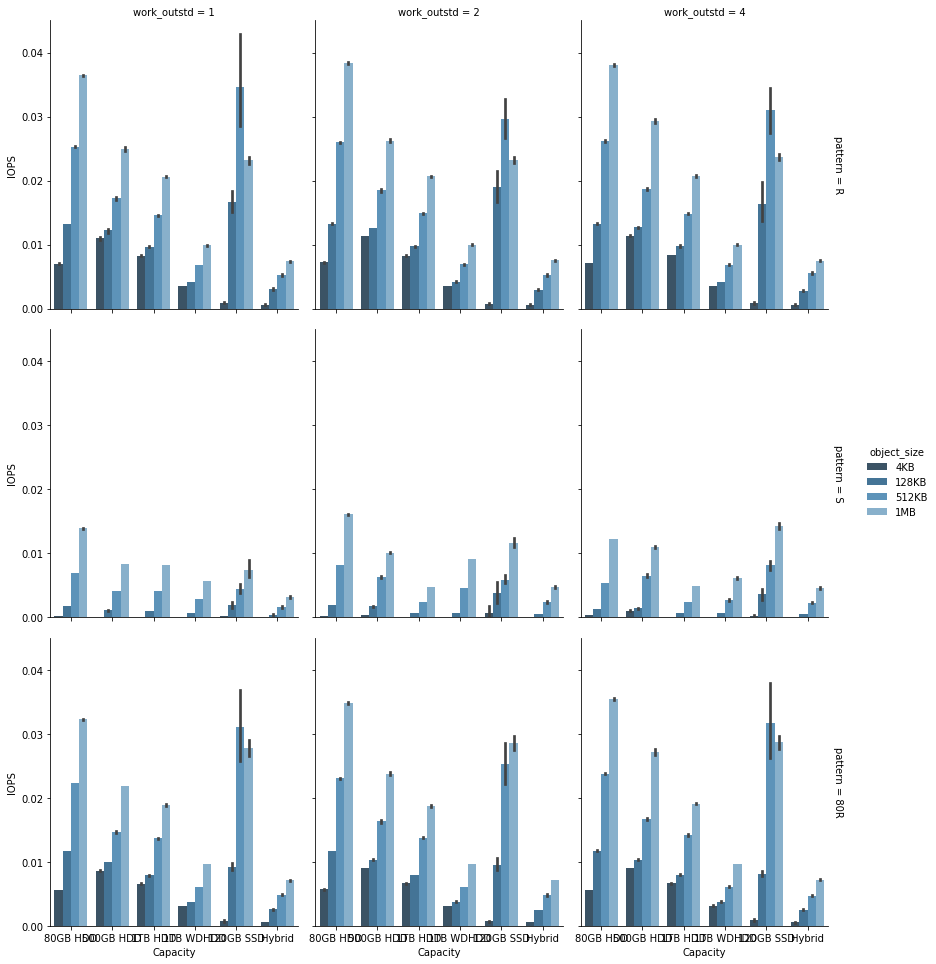

In [23]:
# CENARIO 1

## WRITE IOPS

fig = sns.catplot(x="capacity", y="iops_total", hue="object_size", data=dataset_write_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "IOPS")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('write_iops.pdf', dpi=1200)

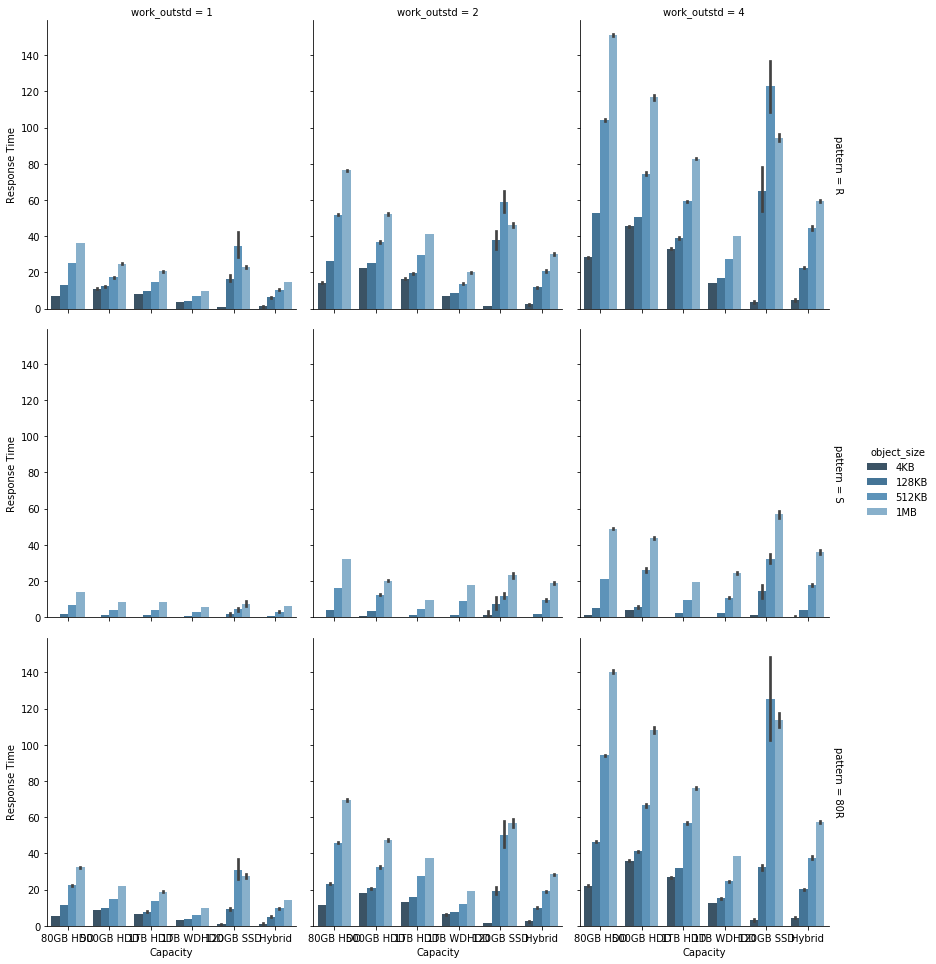

In [24]:
# CENARIO 1

## WRITE RESPONSE TIME

fig = sns.catplot(x="capacity", y="avg_response_time_total", hue="object_size", data=dataset_write_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Response Time")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('write_responsetime.pdf', dpi=1200)

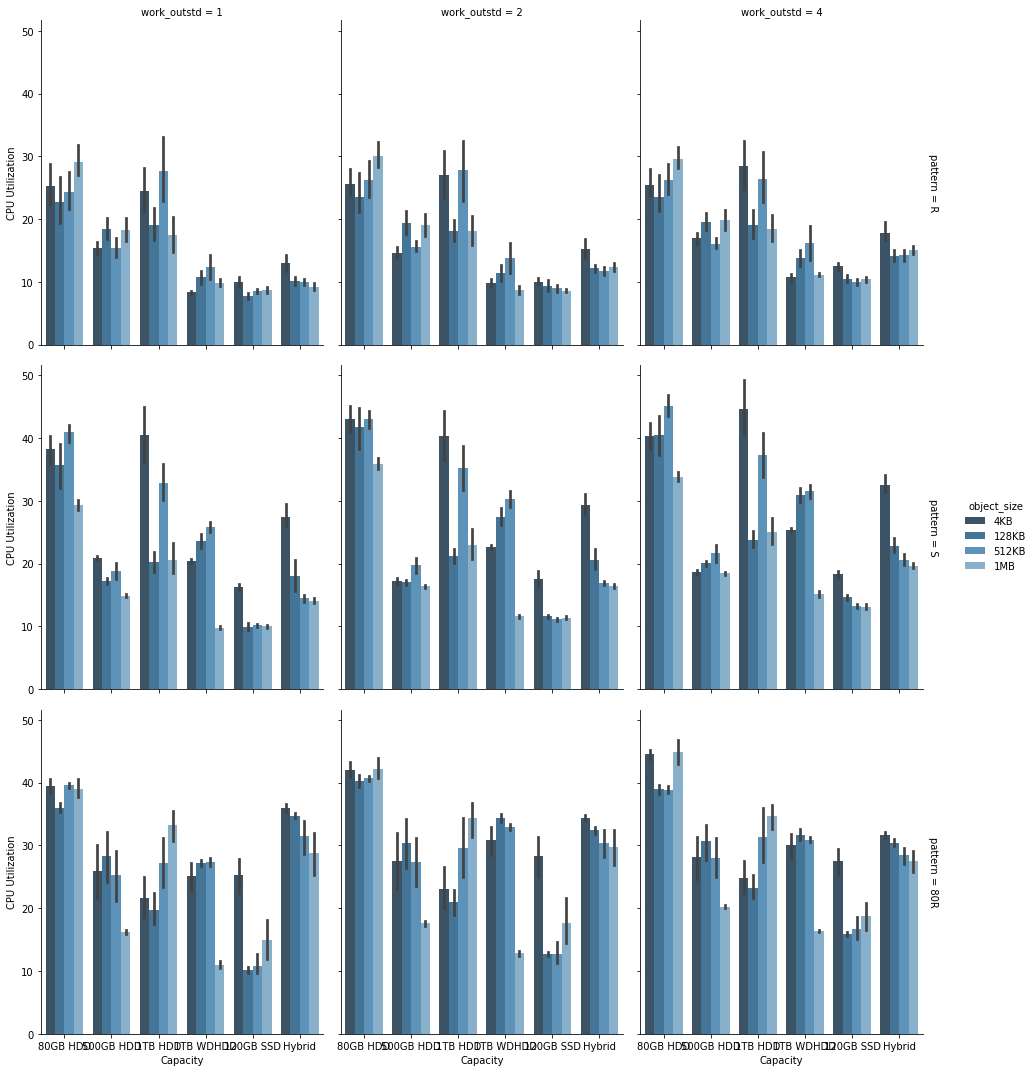

In [26]:
# CENARIO 1

## WRITE CPU UTILIZATION

fig = sns.catplot(x="capacity", y="cpu_utilization", hue="object_size", data=dataset_write_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "CPU Utilization")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])
plt.savefig('write_cpuutilization.pdf', dpi=1200)

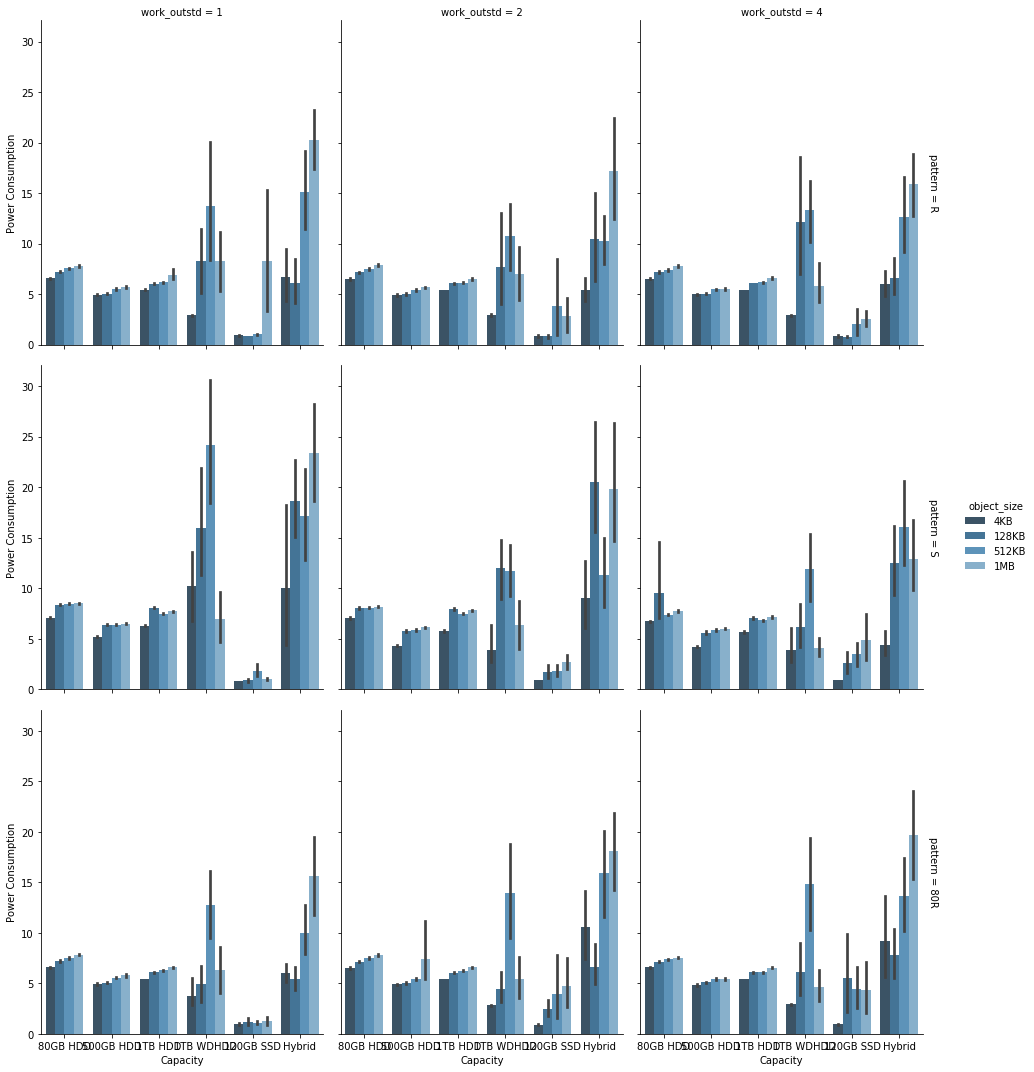

In [118]:
# CENARIO 1

## WRITE POWER CONSUMPTION

fig = sns.catplot(x="capacity", y="power_total", hue="object_size", data=dataset_write_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Power Consumption")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])

plt.savefig('write_power_consumption.pdf', dpi=1200)

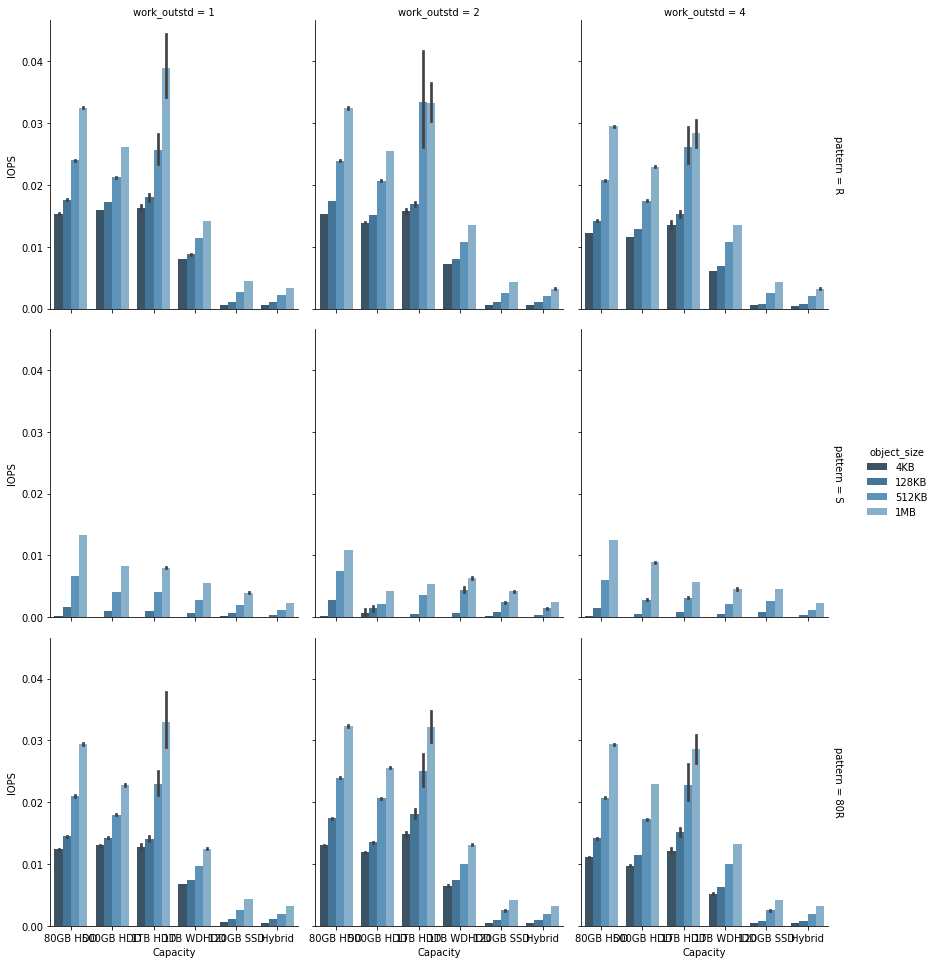

In [119]:
#CENARIO 1

## READ IOPS

fig = sns.catplot(x="capacity", y="iops_total", hue="object_size", data=dataset_read_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "IOPS")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('read_iops.pdf', dpi=1200)

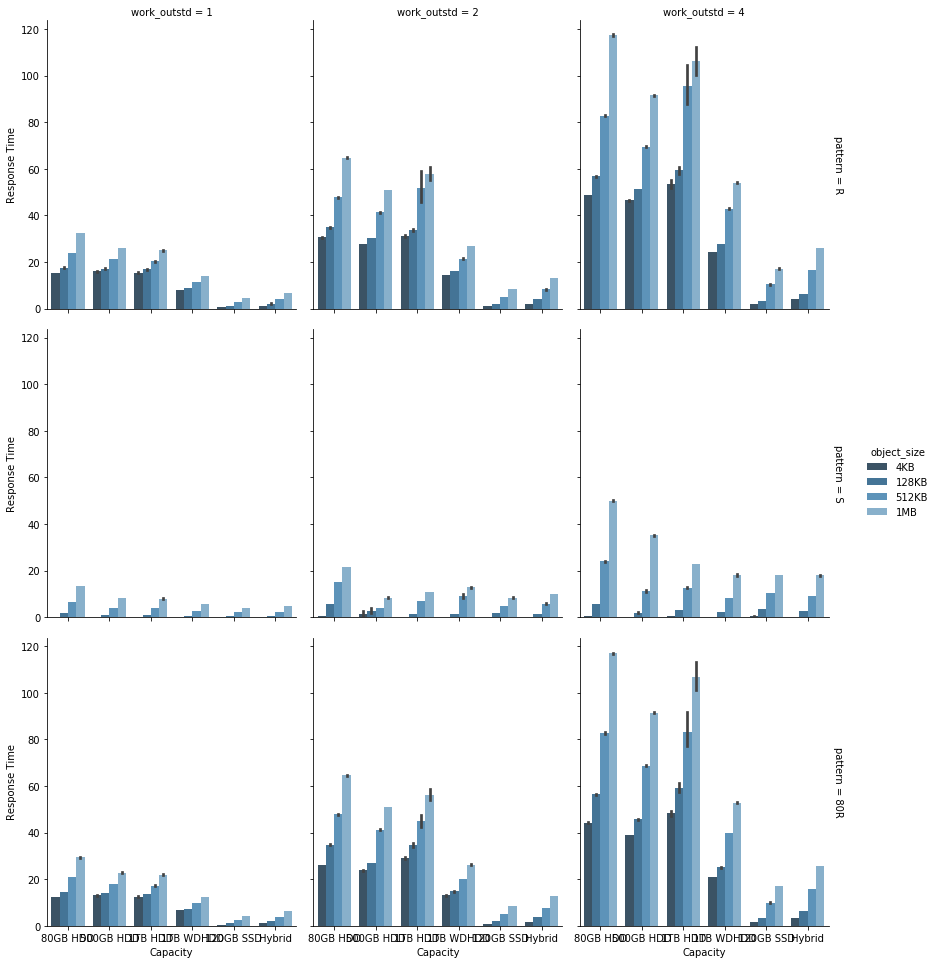

In [121]:
# CENARIO 1

## READ RESPONSE TIME

fig = sns.catplot(x="capacity", y="avg_response_time_total", hue="object_size", data=dataset_read_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Response Time")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('read_responsetime.pdf', dpi=1200)

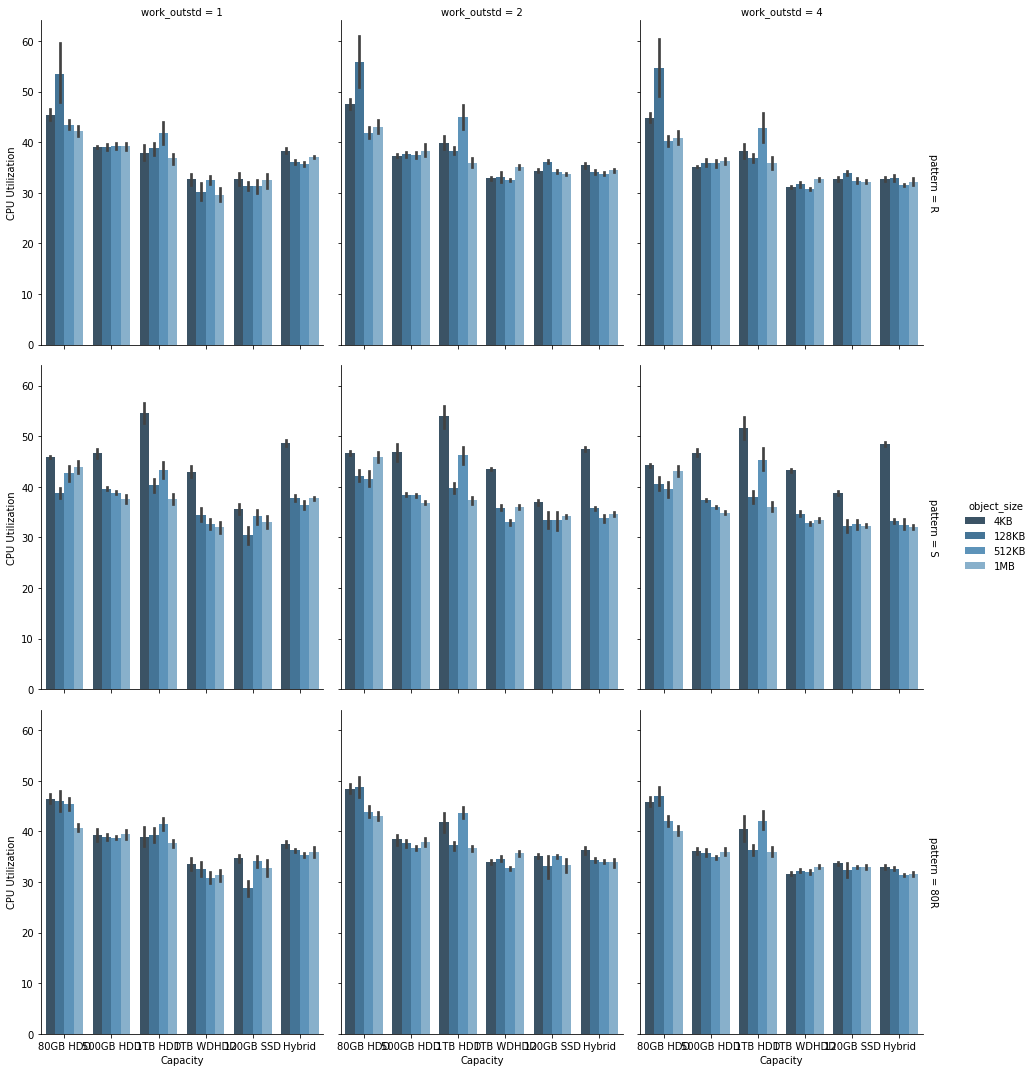

In [122]:
# CENARIO 1

## READ CPU UTILIZATION

fig = sns.catplot(x="capacity", y="cpu_utilization", hue="object_size", data=dataset_read_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "CPU Utilization")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])
plt.savefig('read_cpuutilization.pdf', dpi=1200)

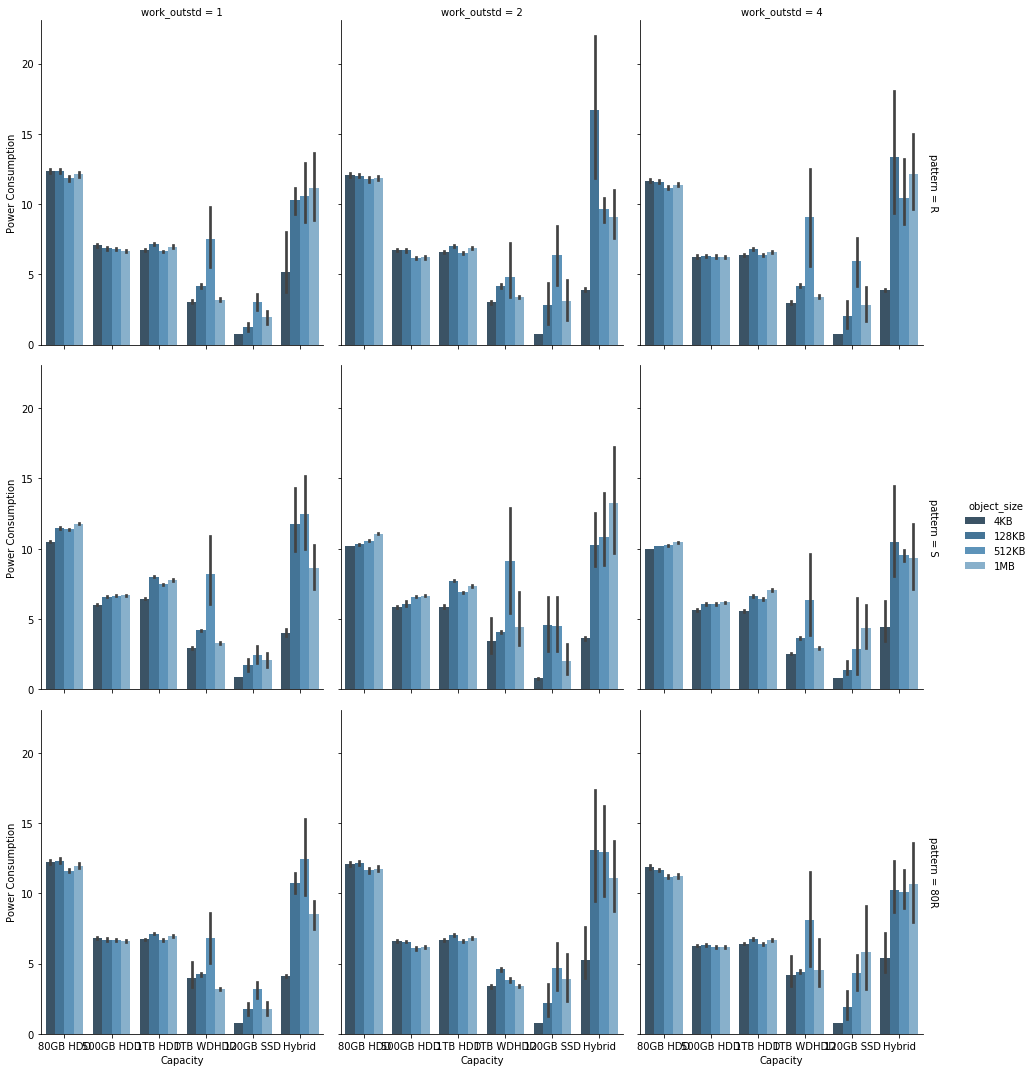

In [123]:
# CENARIO 1

    ## READ POWER CONSUMPTION

fig = sns.catplot(x="capacity", y="power_total", hue="object_size", data=dataset_read_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Power Consumption")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])

plt.savefig('read_power_consumption.pdf', dpi=1200)

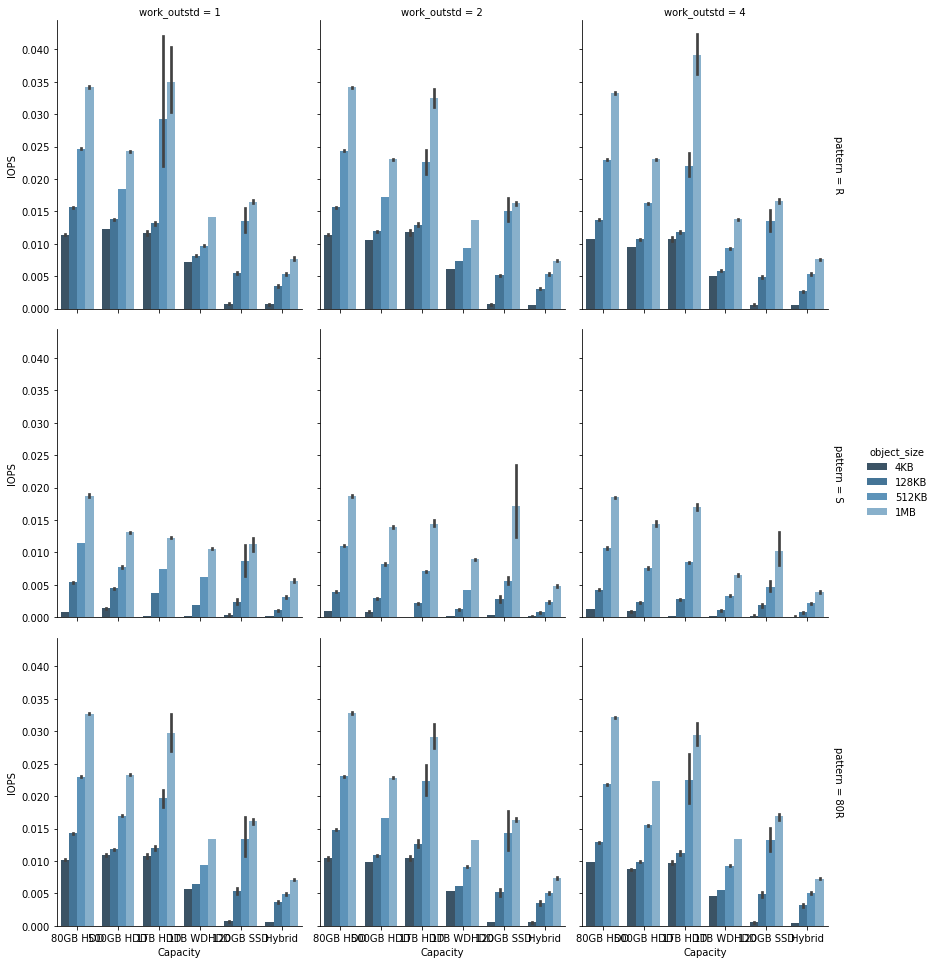

In [124]:
#CENARIO 1

## MIX IOPS

fig = sns.catplot(x="capacity", y="iops_total", hue="object_size", data=dataset_mix_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "IOPS")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('mix_iops.pdf', dpi=1200)

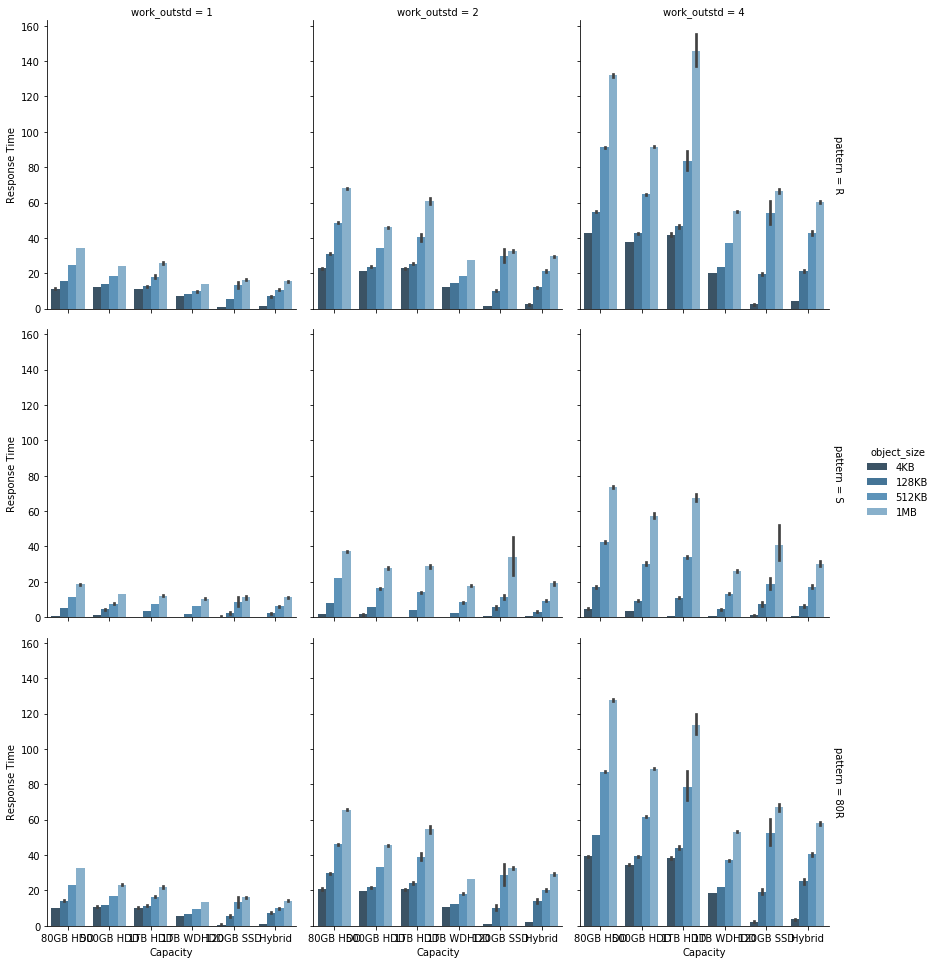

In [125]:
# CENARIO 1

## MIX RESPONSE TIME

fig = sns.catplot(x="capacity", y="avg_response_time_total", hue="object_size", data=dataset_mix_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Response Time")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('mix_responsetime.pdf', dpi=1200)

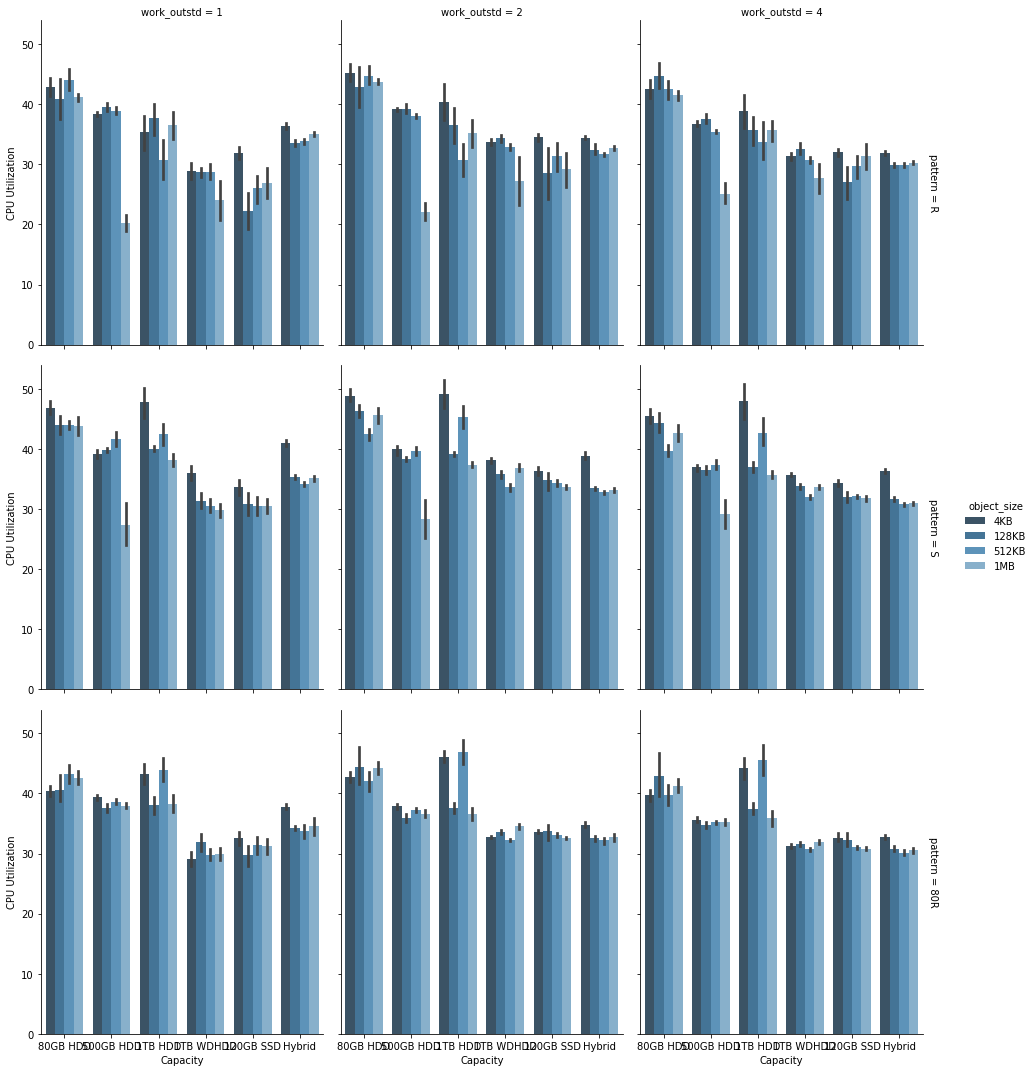

In [126]:
# CENARIO 1

## MIX CPU UTILIZATION

fig = sns.catplot(x="capacity", y="cpu_utilization", hue="object_size", data=dataset_mix_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "CPU Utilization")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])
plt.savefig('mix_cpuutilization.pdf', dpi=1200)

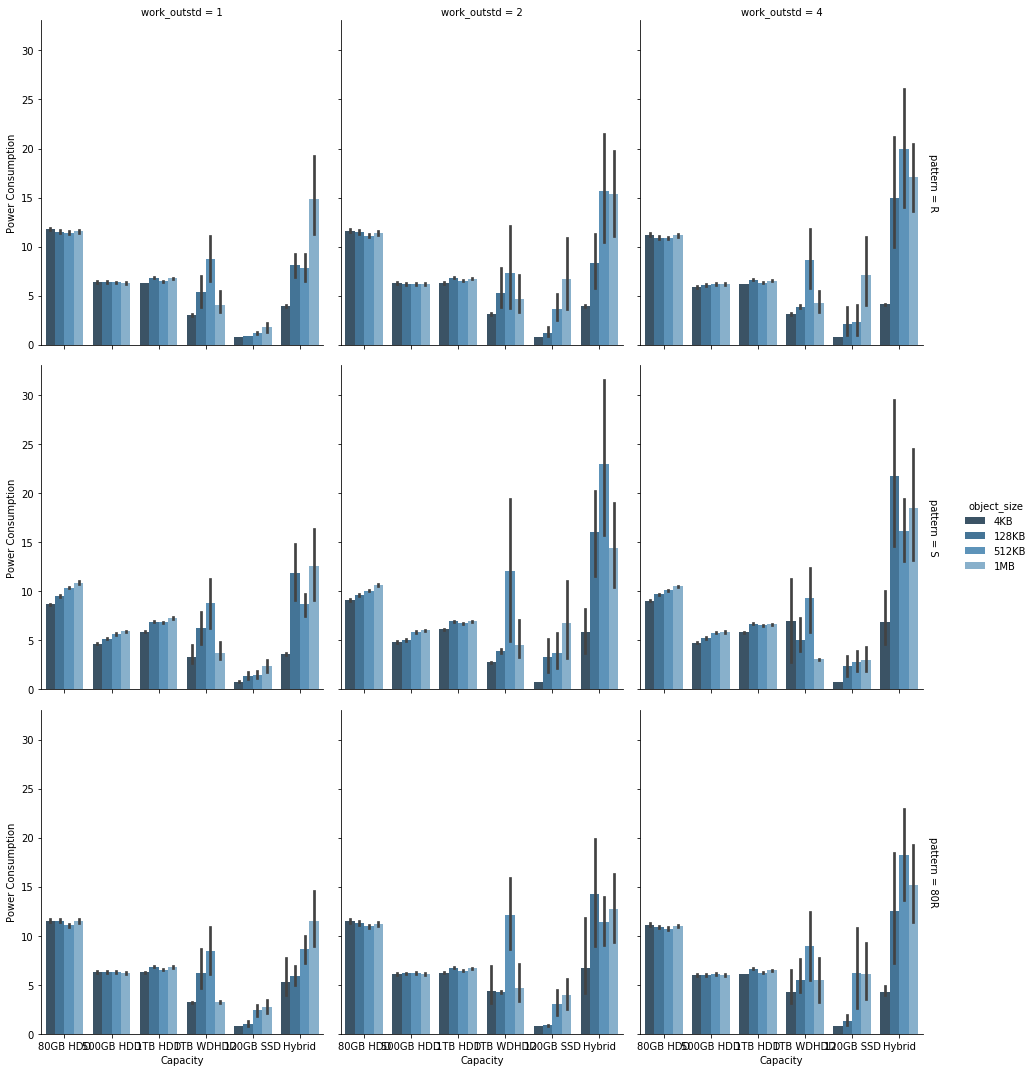

In [127]:
# CENARIO 1

## MIX POWER CONSUMPTION

fig = sns.catplot(x="capacity", y="power_total", hue="object_size", data=dataset_mix_cenUm,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Power Consumption")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])

plt.savefig('mix_power_consumption.pdf', dpi=1200)

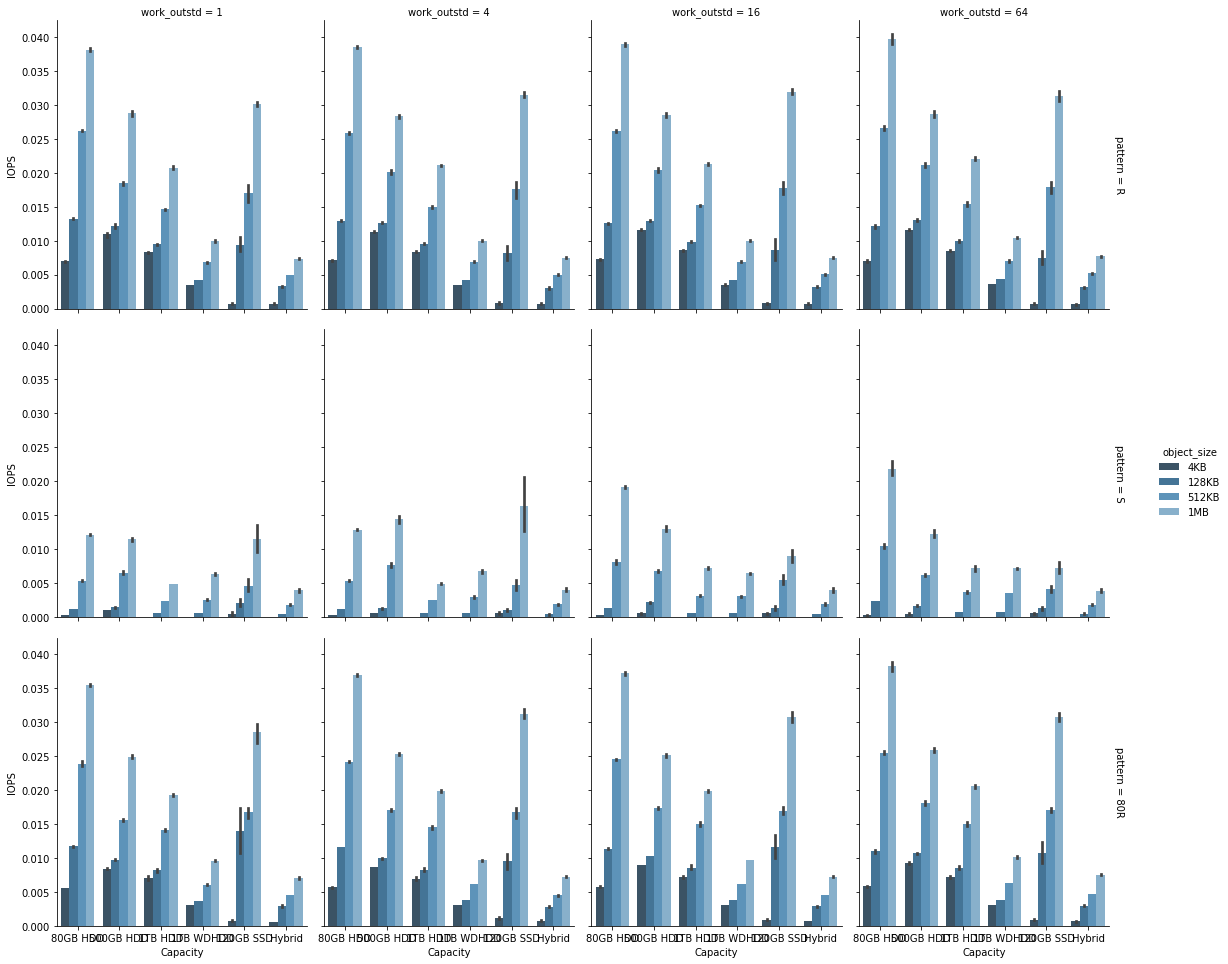

In [128]:
#CENARIO 2

## WRITE IOPS

fig = sns.catplot(x="capacity", y="iops_total", hue="object_size", data=dataset_write_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "IOPS")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('write_iops_cenDois.pdf', dpi=1200)

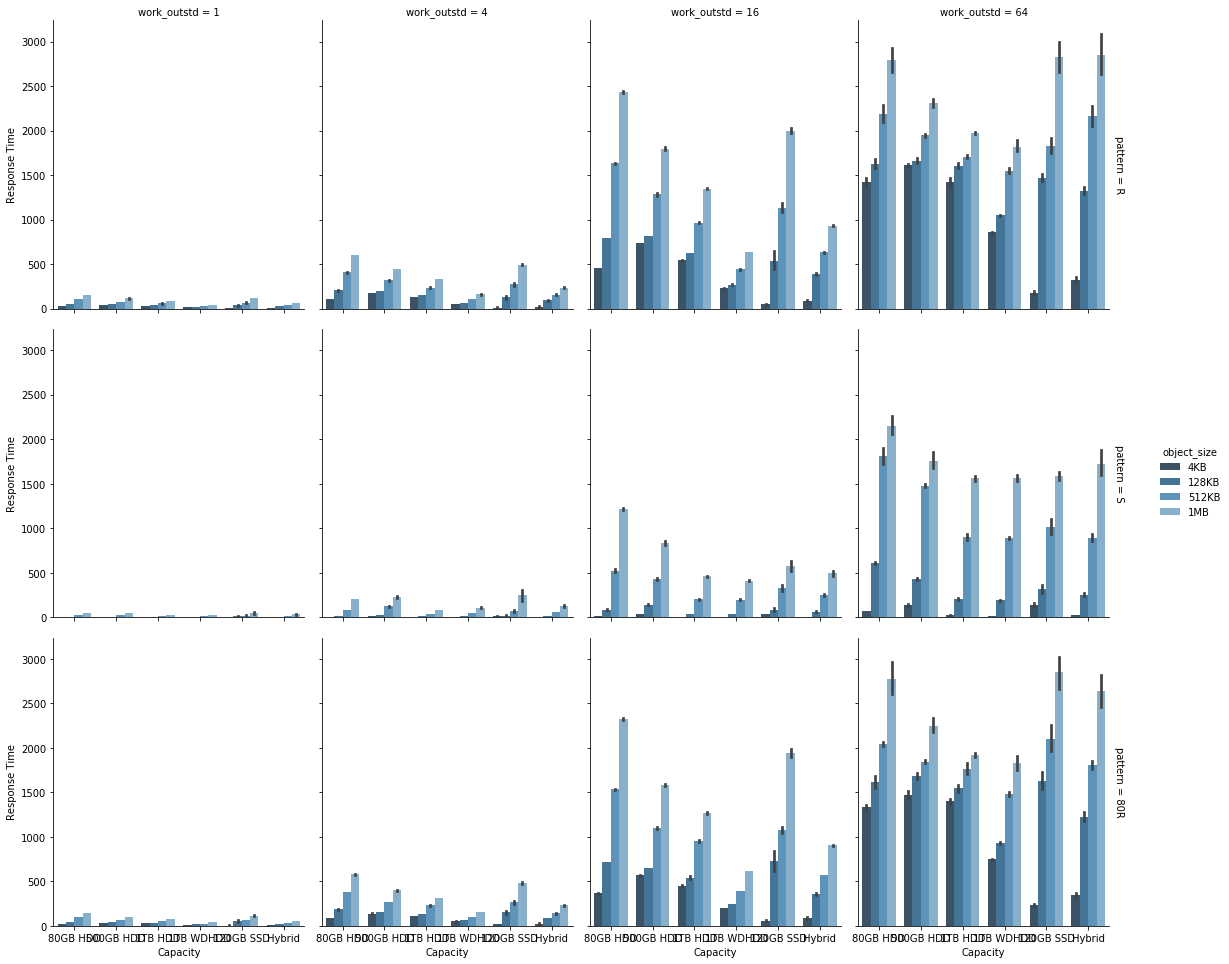

In [129]:
# CENARIO 2

## WRITE RESPONSE TIME

fig = sns.catplot(x="capacity", y="avg_response_time_total", hue="object_size", data=dataset_write_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Response Time")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('write_responsetime_cenDois.pdf', dpi=1200)

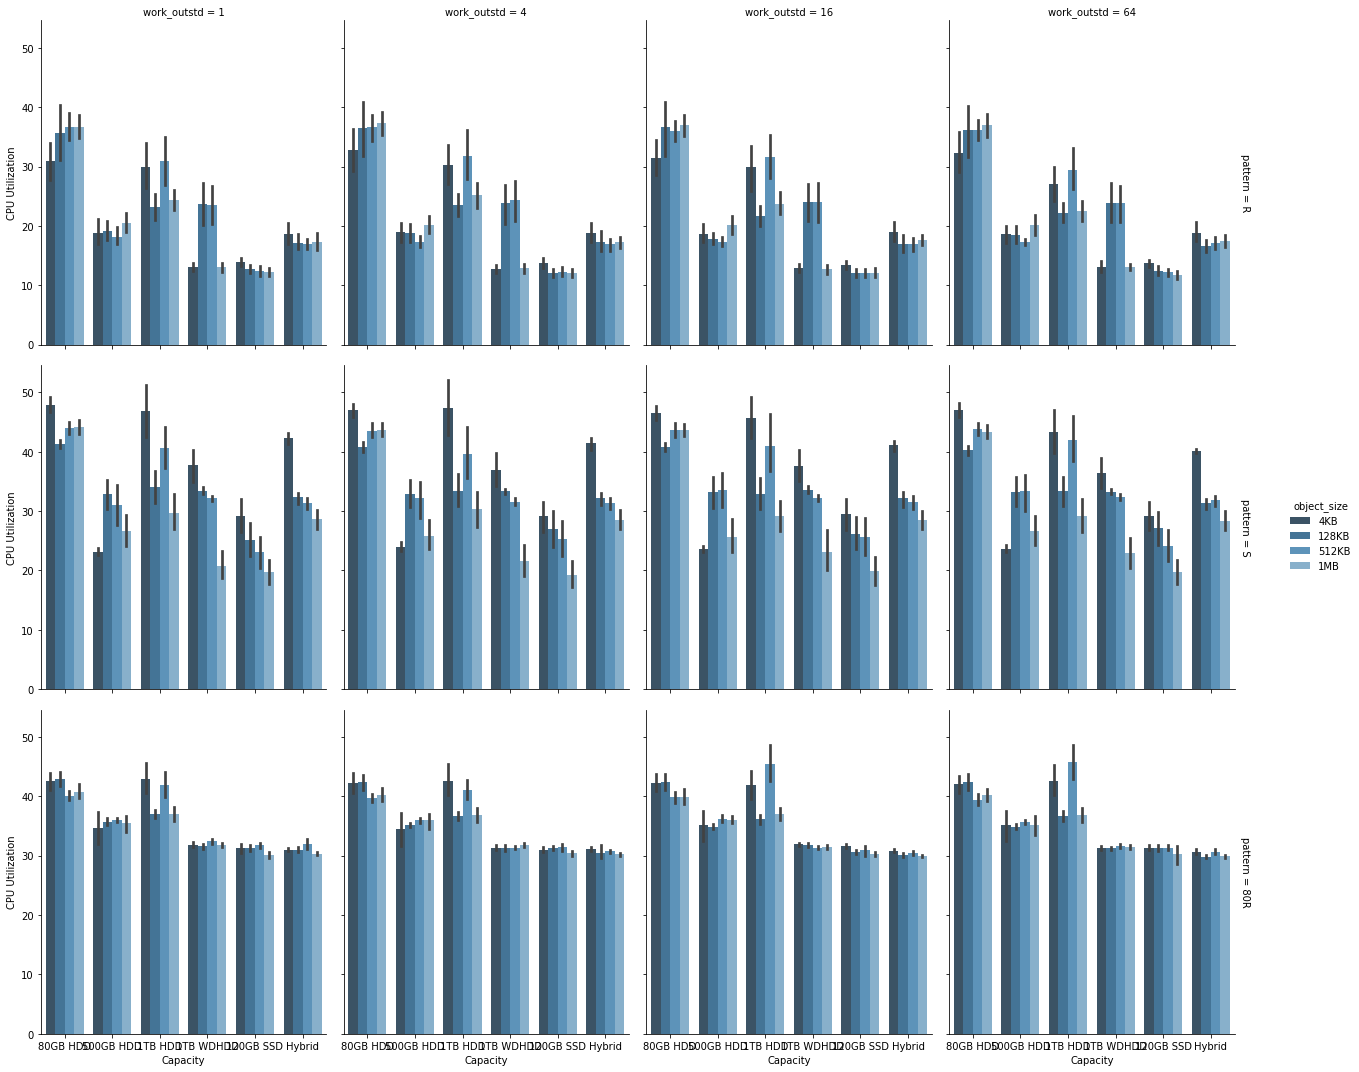

In [130]:
# CENARIO 2

## WRITE CPU UTILIZATION

fig = sns.catplot(x="capacity", y="cpu_utilization", hue="object_size", data=dataset_write_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "CPU Utilization")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])
plt.savefig('write_cpuutilization_cenDois.pdf', dpi=1200)

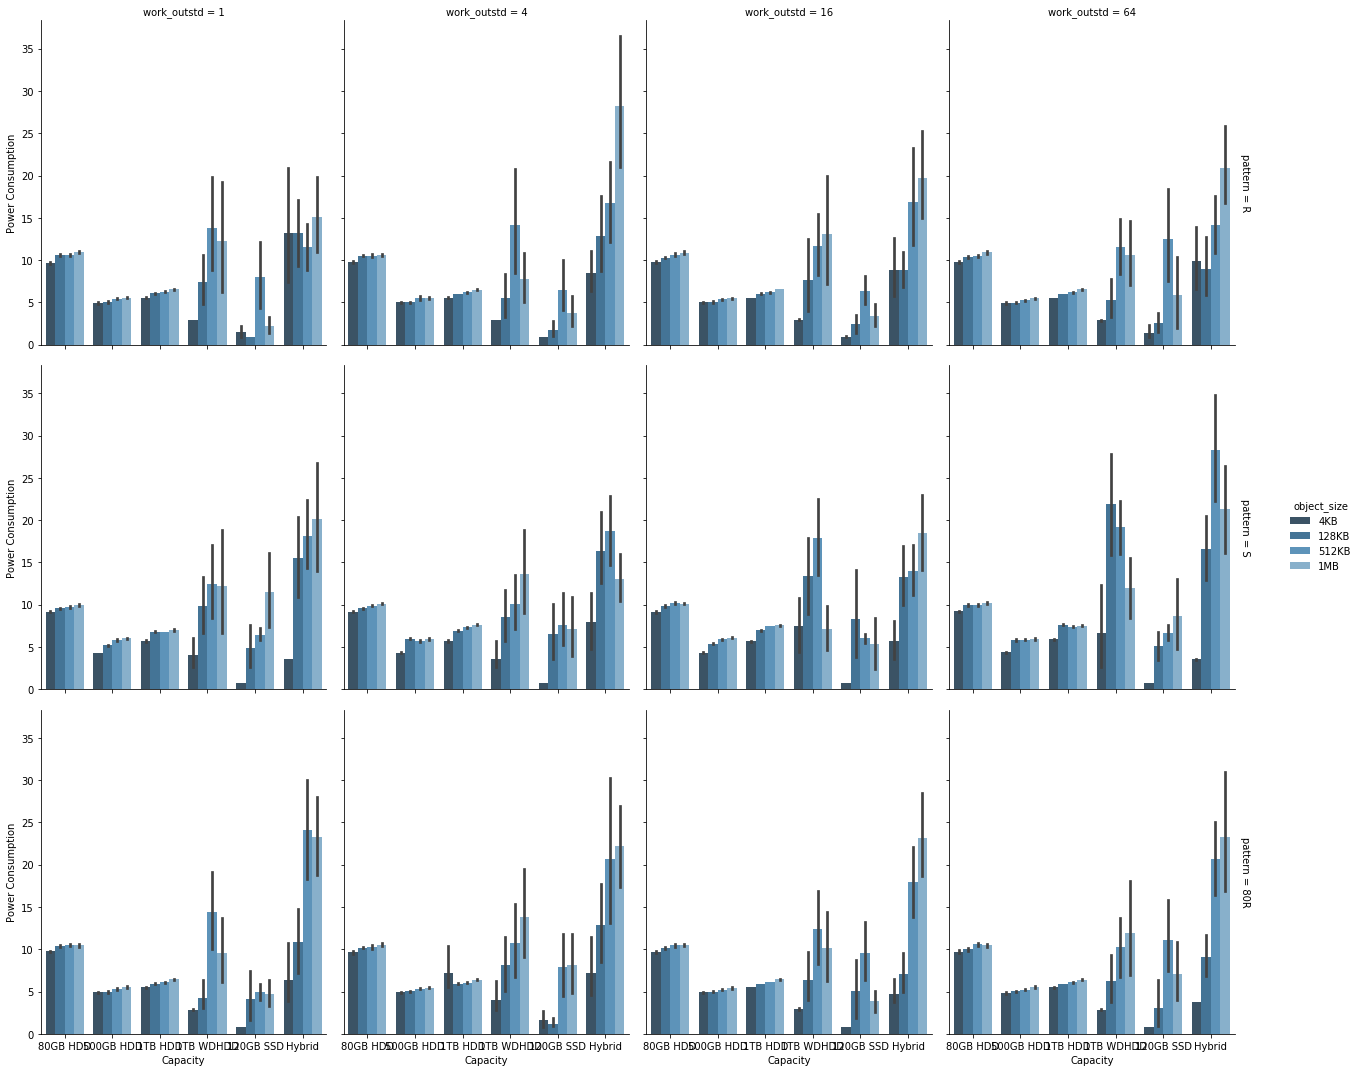

In [162]:
# CENARIO 2

## WRITE POWER CONSUMPTION

fig = sns.catplot(x="capacity", y="power_total", hue="object_size", data=dataset_write_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Power Consumption")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])

plt.savefig('write_power_consumption_cenDois.pdf', dpi=1200)

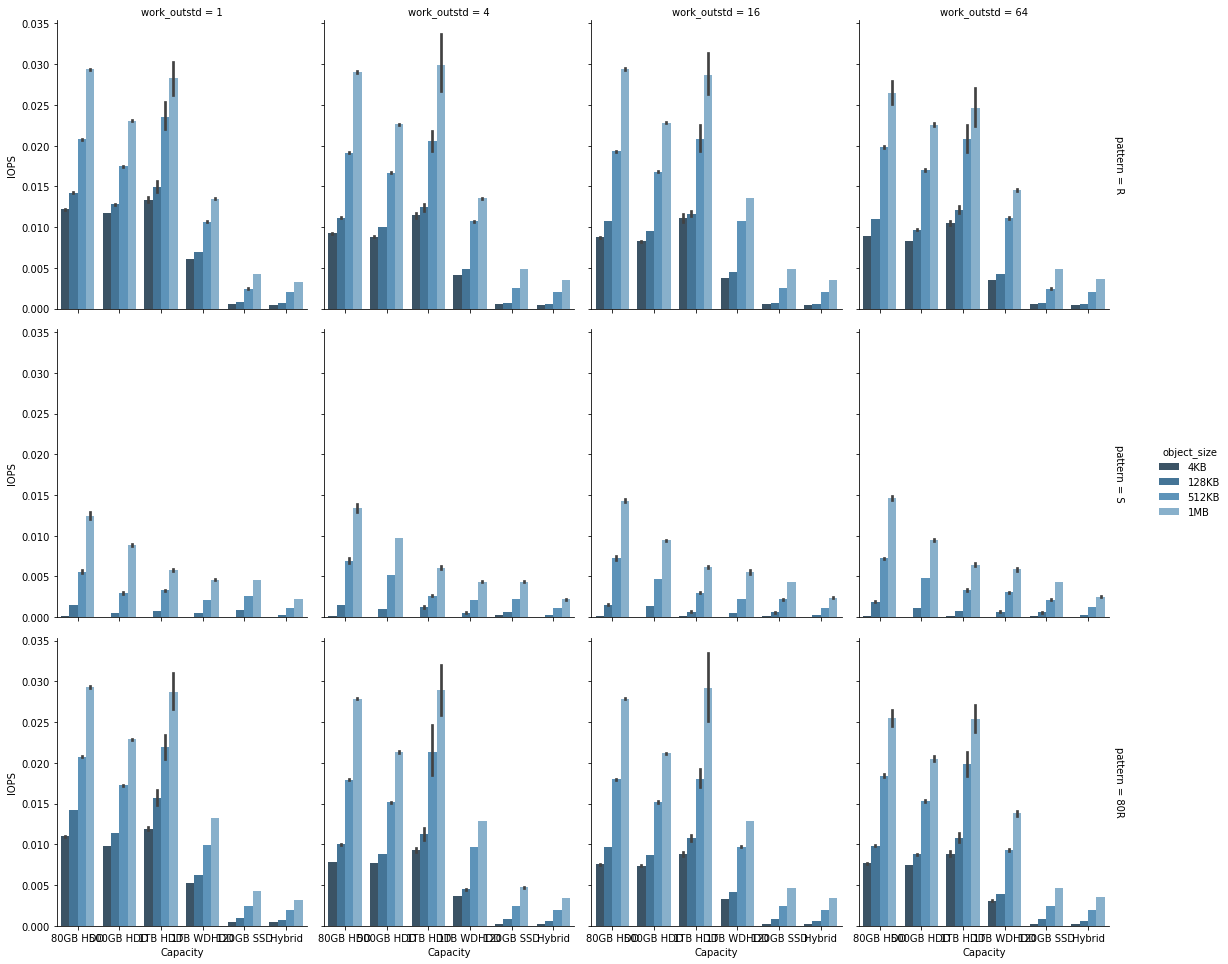

In [171]:
#CENARIO 2

## READ IOPS

fig = sns.catplot(x="capacity", y="iops_total", hue="object_size", data=dataset_read_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "IOPS")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('read_iops_cenDois.pdf', dpi=1200)

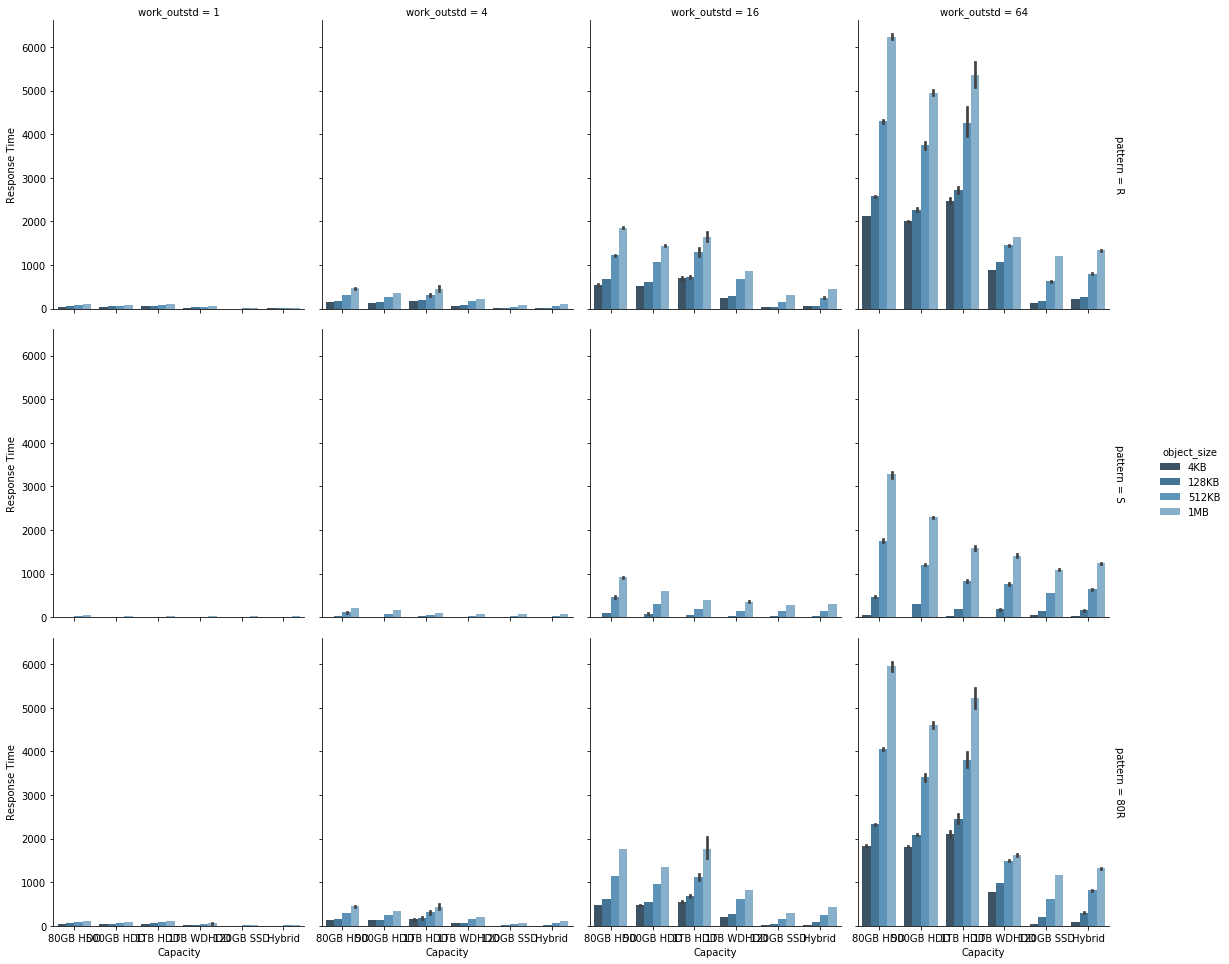

In [133]:
# CENARIO 2

## READ RESPONSE TIME

fig = sns.catplot(x="capacity", y="avg_response_time_total", hue="object_size", data=dataset_read_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Response Time")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('read_responsetime_cenDois.pdf', dpi=1200)

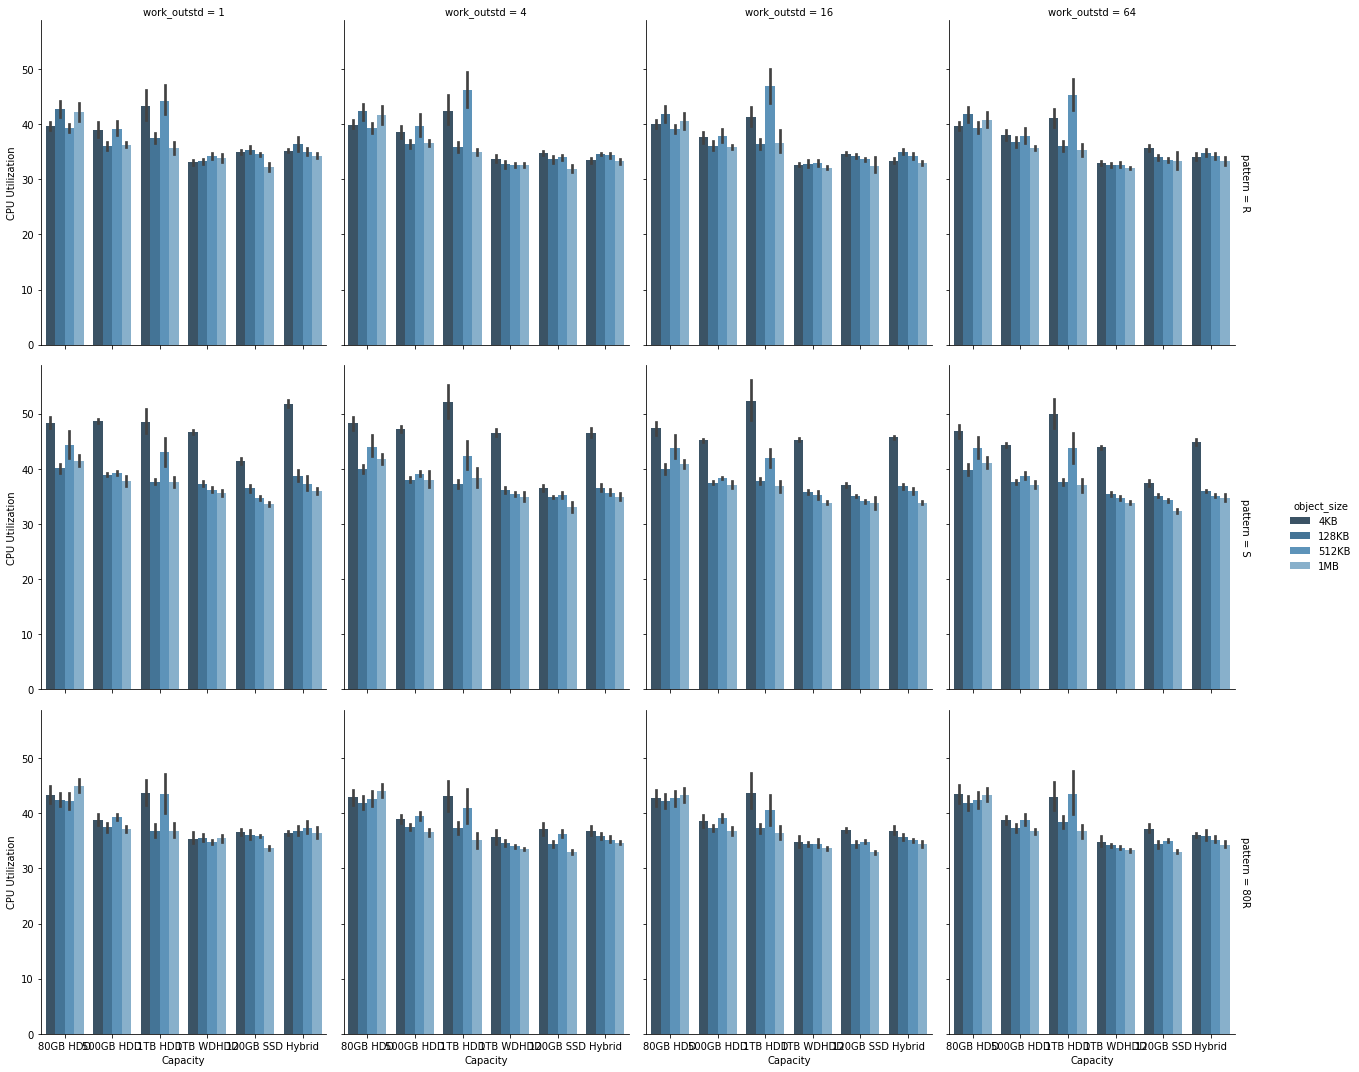

In [134]:
# CENARIO 2

## READ CPU UTILIZATION

fig = sns.catplot(x="capacity", y="cpu_utilization", hue="object_size", data=dataset_read_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "CPU Utilization")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])
plt.savefig('read_cpuutilization_cenDois.pdf', dpi=1200)

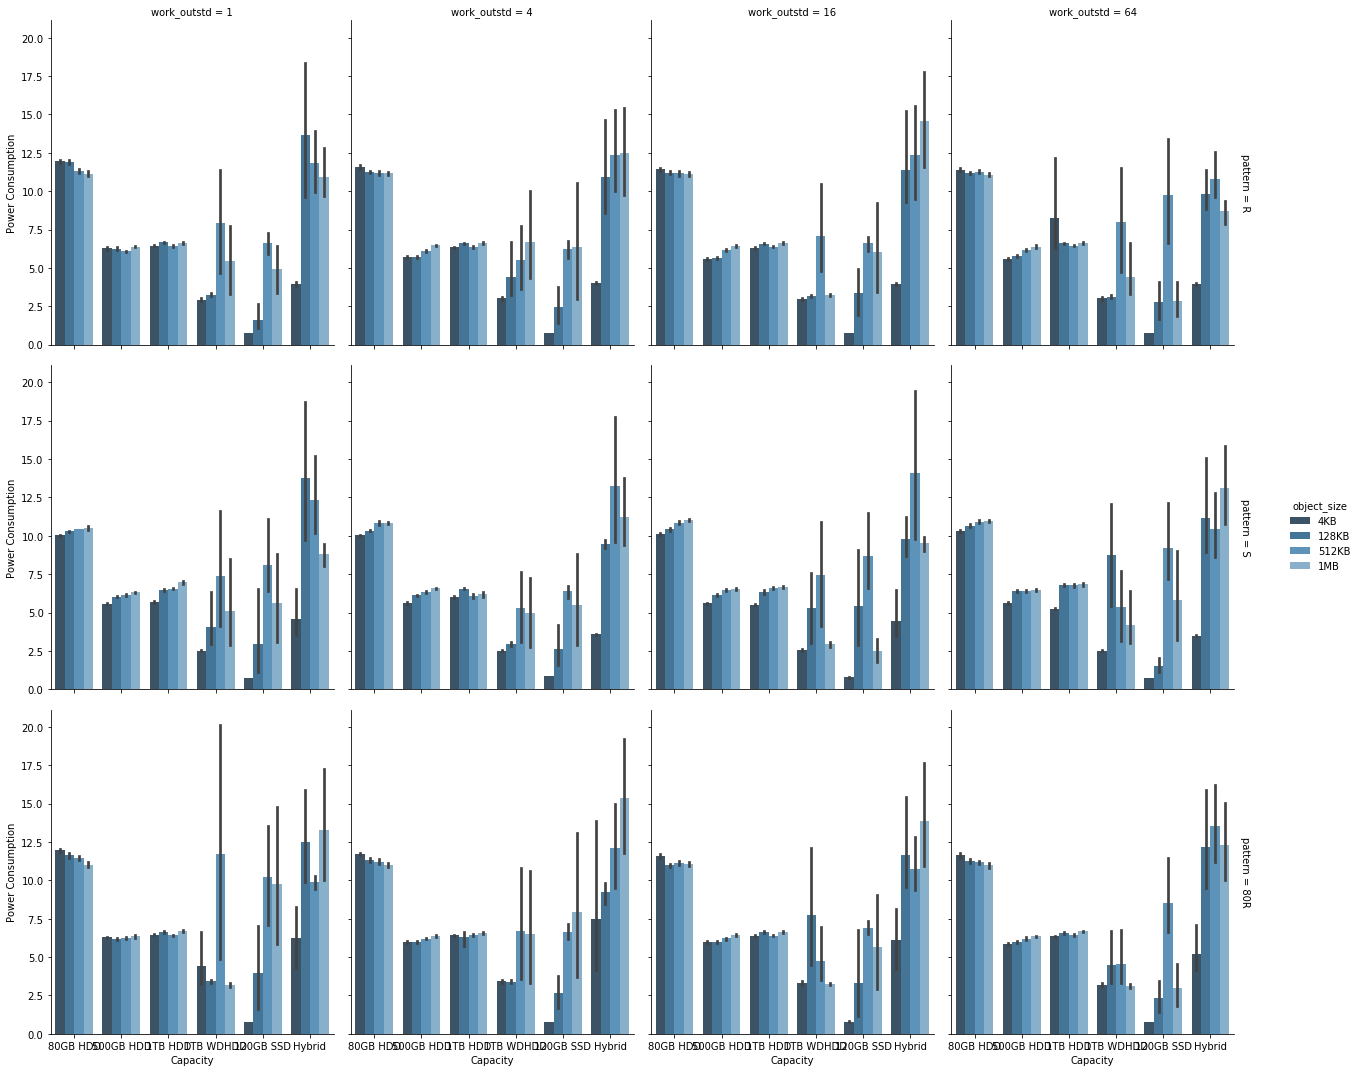

In [163]:
# CENARIO 2

## READ POWER CONSUMPTION

fig = sns.catplot(x="capacity", y="power_total", hue="object_size", data=dataset_read_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Power Consumption")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])

plt.savefig('read_power_consumption_cenDois.pdf', dpi=1200)

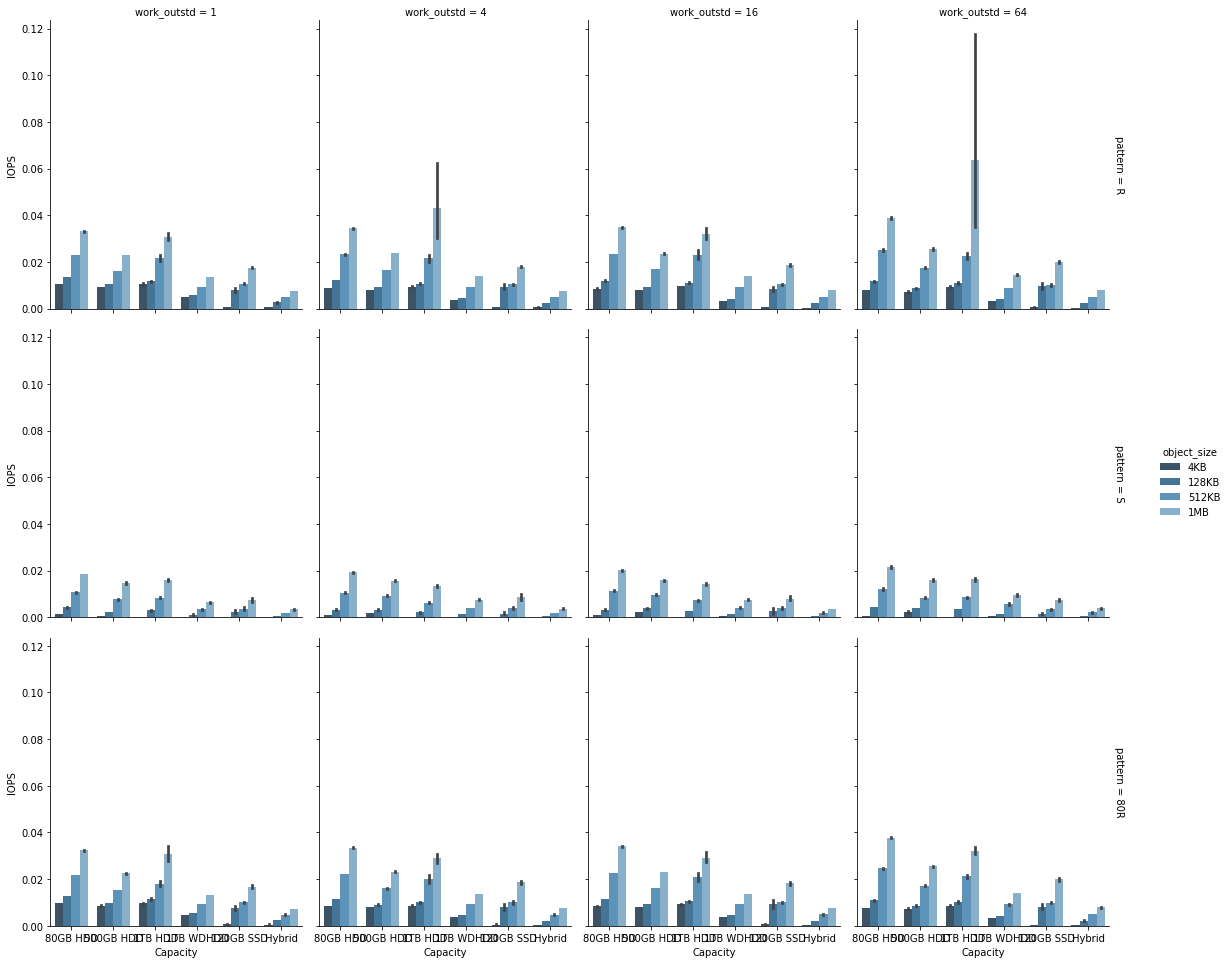

In [172]:
#CENARIO 2

## MIX IOPS

fig = sns.catplot(x="capacity", y="iops_total", hue="object_size", data=dataset_mix_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "IOPS")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('mix_iops_cenDois.pdf', dpi=1200)

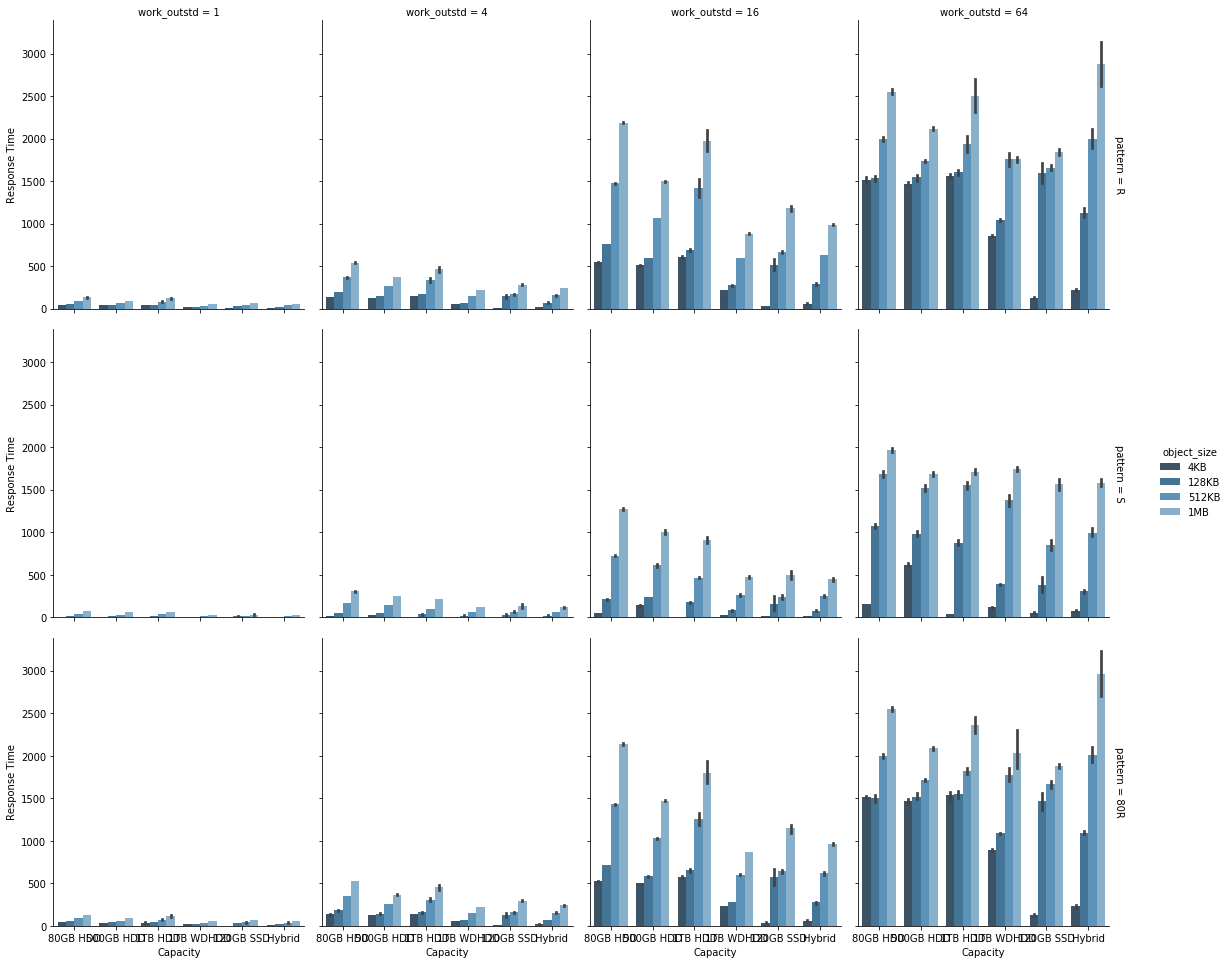

In [137]:
# CENARIO 2

## MIX RESPONSE TIME

fig = sns.catplot(x="capacity", y="avg_response_time_total", hue="object_size", data=dataset_mix_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Response Time")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])

plt.savefig('mix_responsetime_cenDois.pdf', dpi=1200)

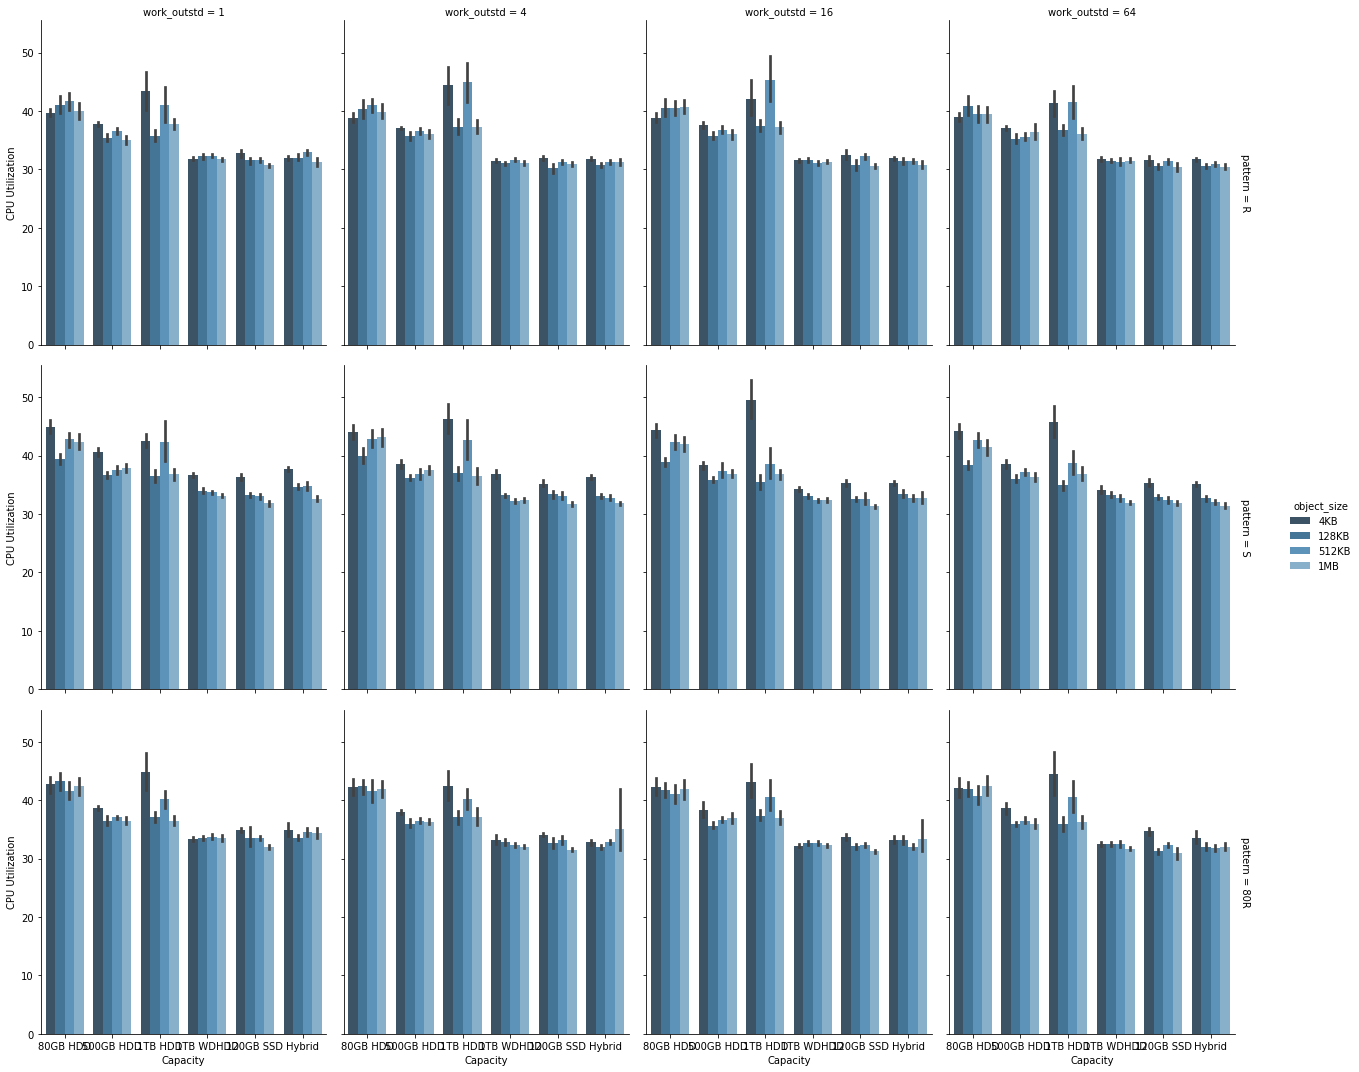

In [138]:
# CENARIO 2

## MIX CPU UTILIZATION

fig = sns.catplot(x="capacity", y="cpu_utilization", hue="object_size", data=dataset_mix_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "CPU Utilization")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])
plt.savefig('mix_cpuutilization_cenDois.pdf', dpi=1200)

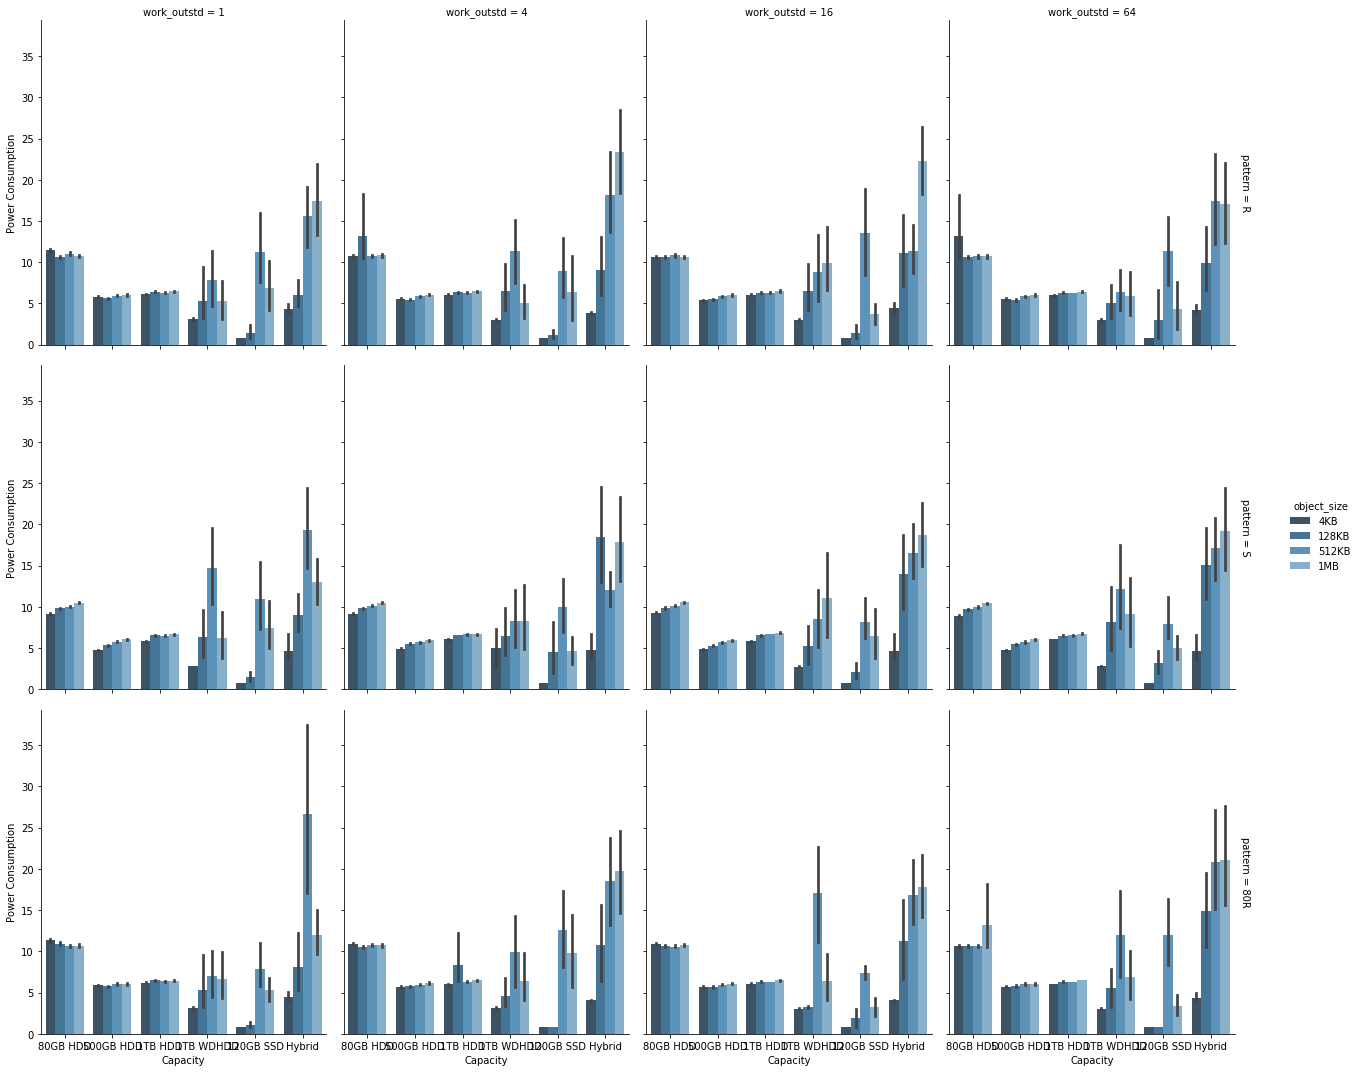

In [164]:
# CENARIO 2

## MIX POWER CONSUMPTION

fig = sns.catplot(x="capacity", y="power_total", hue="object_size", data=dataset_mix_cenDois,
               row="pattern", col="work_outstd", kind="bar", ci=90, palette="Blues_d", aspect=0.9,legend_out = True, margin_titles = True)

fig.set_axis_labels("Capacity", "Power Consumption")
fig.set_xticklabels(["80GB HDD", "500GB HDD", "1TB HDD", "1TB WDHDD", "120GB SSD", "Hybrid"])
#fig.set_yticklabels([0,3,6,9,14,15])

plt.savefig('mix_power_consumption_cenDois.pdf', dpi=1200)

In [ ]:
teste = dataset_write_cenUm.query('pattern == "R" & work_outstd == 2 & capacity == "1TBHDD" & object_size == "1MB"')
teste.power_average1

teste.power_average1 = teste.power_average1.astype(str)
teste['power_average1'] = teste['power_average1'].apply(lambda x: x.split("e")[0])
teste.power_average1 = teste.power_average1.astype(float)
teste.power_average1


## EXAMPLES

#teste.power_average1.mean()
#dataset_write_cenUm.iops_total.isnull().sum()
#teste.power_average1[teste['power_average1'].str.contains('e')] = teste['power_average1'].apply(lambda x: x.split("e")[0])
#df['coluna'] = df['coluna'].apply(lambda x: x.split("%")[1])
#df.column = df.column.astype(float)
#dataset_write_cenUm.iops_total[dataset_write_cenUm.iops_total != 0] = (1/dataset_write_cenUm.iops_total)


In [ ]:
teste = dataset_cenUm.query('repetition==2 & individual_total == "I" & operation == "W" & pattern == "R" & work_outstd == 4 & capacity == "1TBHDD" & object_size == "4KB"')
if (not teste.empty):
    print ('eh')
else:
    x = teste.iops_total.get_values()[0]
    print (x)
    

    
           
#teste.iops_total
#teste.info()
#print (teste.iops_total.to_string(index=False))

In [ ]:
kind = 'hybrid'

if (not (kind == 'hybrid')):
    print ('eh')
else:
    print ('n')

In [ ]:
#df = dataset.query('object_size == "128KB" & capacity == "120GBSSD" & scenario == 2')

#df.shape

dataset.info()

#dataset_write_cenUm.shape


In [ ]:
#BORRÃO

#df_temp = dfTemp_80HDDBenchCenUm4KB[dfTemp_80HDDBenchCenUm4KB.timestamp.dt.day == 26]

#df_temp = dfTemp_80HDDBenchCenUm4KB.query(('timestamp.dt.day == 26') and ('timestamp.dt.hour == 12') and ('timestamp.dt.minute == 45') and ('timestamp.dt.second == 54'))



#df = df_80HDDBenchCenUm4KB.query('timestamp.dt.day == 26 & timestamp.dt.hour == 12 & timestamp.dt.minute == 45 & timestamp.dt.second == 53')

#teste = float(df.maximum_1.get_values()[0].replace(',','.'))
#teste2 = teste.replace(',','.')

#teste3 = float(teste2)#
#testeF = [0.0 , 0.1, 0.2]array =


array =[1,2,3,4]

array2 = [0.1,0.2,0,0.3]

#array2 = [array2[0] + array[0],array2[1] + array[1],array2[2] + array[2],array2[3] + array[3]]

array3 = array + array2

#array3

condicao =  1
index = 0
y = array

for x in y:
    print (x)
    index = index + 1
    if (index == 3 and condicao == 1):
        index = 0
        y = array2
        condicao = 2
    

#testeF[2]
#type(teste)
#print(teste)

#teste2 = teste.replace(',','.')
#print(teste2 + "dd")
#aqui = "4,5"
#aqui2 = aqui.replace(',','.')
#aqui3 = float(aqui2)
#aqui4 = aqui3 + 5.1
#type(aqui4)


